# **<span style="color: blue;">Business Case: Walmart - Confidence Interval and CLT</span>**
By Santanu Dash


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
from scipy.stats import norm, binom, geom, poisson # Distributions
from scipy.stats import zscore, ttest_1samp, ttest_ind, ttest_rel # Z-Test & T-Test
from scipy.stats import chisquare, chi2_contingency, chi2 # ChiSqured Test
from scipy.stats import f_oneway, kruskal, shapiro, levene, ks_2samp # Anova Test
from scipy.stats import spearmanr # Co-Relation Test

from statsmodels.graphics.gofplots import qqplot

sns.set_theme(style="darkgrid")

>## **<span style="color: #6666ff;">**About Walmart**</span>**

* Walmart is an American multinational retail corporation that operates a chain of supercenters, discount departmental stores, and grocery stores from the United States. 
* Walmart has more than 100 million customers worldwide.

> ## **<span style="color: #6666ff;">**About DataSet**</span>**
 * User_ID:	User ID
 * Product_ID:	Product ID
 * Gender:	Sex of User
 * Age:	Age in bins
 * Occupation:	Occupation(Masked)
 * City_Category:	Category of the City (A,B,C)
 * StayInCurrentCityYears:	Number of years stay in current city
 * Marital_Status:	Marital Status
 * ProductCategory:	Product Category (Masked)
 * Purchase:	Purchase Amount

In [2]:
walmart_raw = pd.read_csv("./walmart_data.csv")
walmart_raw.head(5)

User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category  Purchase  
0                          2               0                 3      8370  
1                          2               0                 1     15200  
2                          2               0                12      1422  
3                          2               0                12      1057  
4                         4+               0                 8      7969

## **<span style="color: #ff0080;">**Business Problem**</span>**

* The Management team at Walmart Inc. wants to analyze the customer purchase behavior (specifically,` purchase` amount) against the customer’s `gender` and the various other factors to help the business make better decisions. 
* They want to understand if the spending habits differ between **male** and **female** customers: 
  * `Do women spend more on Black Friday than men?` (Assume 50 million customers are male and 50 million are female).


## **<span style="color: black;">Exploring The Data Set</span>**


In [3]:
walmart_raw.shape

(550068, 10)

In [4]:
walmart_raw.size

5500680

In [5]:
walmart_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


### **<span style="color: #660033;">Missing value detection & fill with relevent data.</span>**

In [6]:
walmart_raw.isnull().sum()

User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category              0
Purchase                      0
dtype: int64

### ****<span style="color: green;">Consolidated Data</span>****

In [7]:
walmart_raw.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category',
       'Purchase'],
      dtype='object')

In [8]:
def gender_convert(x):
    return 1 if(x=='M') else 0
walmart_raw['gender'] = walmart_raw.apply(lambda row: gender_convert(row['Gender']),axis=1)

def gender_rename(x):
    return "Male" if(x=='M') else ("Female" if(x=='F') else "")
walmart_raw['Gender'] = walmart_raw.apply(lambda row: gender_rename(row['Gender']),axis=1)

def matial_status_convert(x):
    return 'Single' if(x==0) else 'Partnered'
walmart_raw['marital_status'] = walmart_raw.apply(lambda row: matial_status_convert(row['Marital_Status']),axis=1)

def age_convert(x):
    if ('+' in x):
        return int(x.split('+')[0])
    if ('-' in x):
        return (int(x.split('-')[0])+int(x.split('-')[1]))/2
walmart_raw['age'] = walmart_raw.apply(lambda row: age_convert(row['Age']),axis=1)

def purchase_categorise(df):
    df["Purchase_group"] = pd.cut(x=df['Purchase'], bins=[0,100,500,1000,2500,5000,7500,10000,12500,15000,17500,20000,22500,25000],  
                    labels=["0-100", "101-500", "501-1K", "1K-2.5K", "2.5K-5K", "5K-7.5K", "7.5K-10K", "10K-12.5K", "12.5K-15K", "15K-17.5K", "17.5K-20K", "20K-22.5K", "22.5K-25K"])
    df['Purchase_group'] = df['Purchase_group'].astype('category')
    return df
walmart_raw = purchase_categorise(walmart_raw)



In [9]:
walmart_raw = walmart_raw[['User_ID', 'Gender', 'gender', 'Marital_Status', 'marital_status', 'Age', 'age', 'City_Category',
       'Stay_In_Current_City_Years', 'Occupation', 'Product_ID',  'Product_Category',
       'Purchase', 'Purchase_group']]

In [10]:
walmart_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   User_ID                     550068 non-null  int64   
 1   Gender                      550068 non-null  object  
 2   gender                      550068 non-null  int64   
 3   Marital_Status              550068 non-null  int64   
 4   marital_status              550068 non-null  object  
 5   Age                         550068 non-null  object  
 6   age                         550068 non-null  float64 
 7   City_Category               550068 non-null  object  
 8   Stay_In_Current_City_Years  550068 non-null  object  
 9   Occupation                  550068 non-null  int64   
 10  Product_ID                  550068 non-null  object  
 11  Product_Category            550068 non-null  int64   
 12  Purchase                    550068 non-null  int64   
 13 

### **<span style="color: #ff6600;">Check for Outliers</span>**

In [11]:
def check_outlier(df, x):
    Q1 = df[x].quantile(0.25)
    Q3 = df[x].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    lower_outlier = df[x][df[x] < lower]
    upper_outlier = df[x][df[x] > upper]

    return {
        'lower': {
            'list': lower_outlier,
            'length': len(lower_outlier)
        },
        'upper': {
            'list': upper_outlier,
            'length': len(upper_outlier)
        }}

In [12]:
for i in walmart_raw[['User_ID', 'age', 'Occupation', 'Product_Category', 'Purchase']].columns:
    # print(i)
    outlier = check_outlier(walmart_raw, i)
    print("{} : \n\t'Lower Outliers': {} \n\t'HIgher Outliers': {} \n\t'Mean - Median': {}\n".format(i, outlier['lower']['length'], outlier['upper']['length'], round(walmart_raw[i].mean()-walmart_raw[i].median(),4)))

User_ID : 
	'Lower Outliers': 0 
	'HIgher Outliers': 0 
	'Mean - Median': -48.1576

age : 
	'Lower Outliers': 15102 
	'HIgher Outliers': 0 
	'Mean - Median': 3.752

Occupation : 
	'Lower Outliers': 0 
	'HIgher Outliers': 0 
	'Mean - Median': 1.0767

Product_Category : 
	'Lower Outliers': 0 
	'HIgher Outliers': 4153 
	'Mean - Median': 0.4043

Purchase : 
	'Lower Outliers': 0 
	'HIgher Outliers': 2677 
	'Mean - Median': 1216.9687



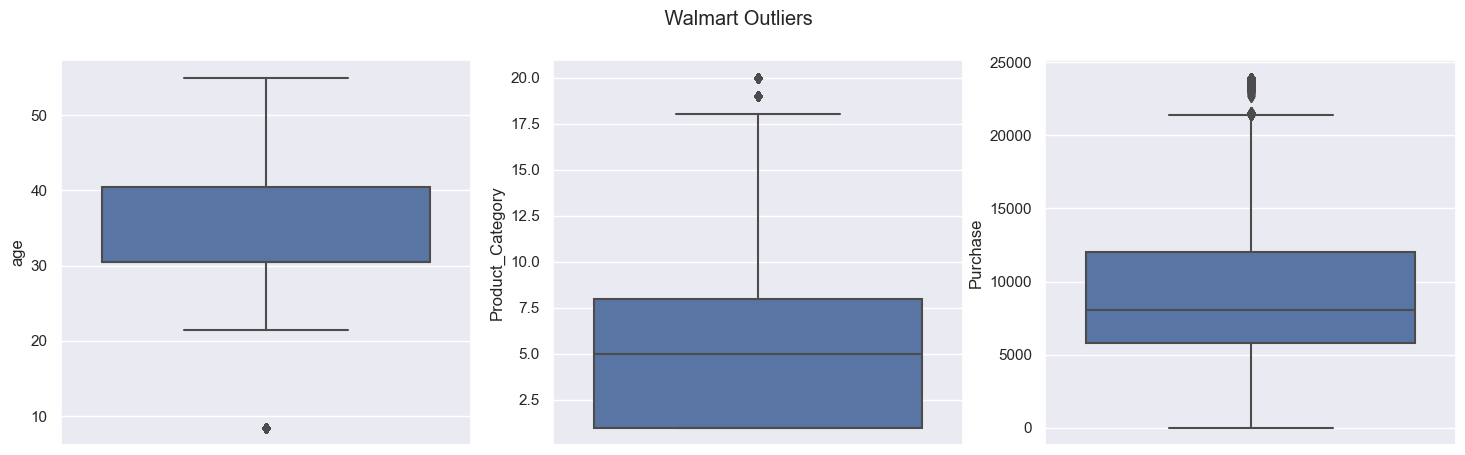

In [13]:
plt.figure(figsize=(18,5)).suptitle(" Walmart Outliers")
plt.subplot(1,3,1)
sns.boxplot(walmart_raw, y='age')
plt.subplot(1,3,2)
sns.boxplot(walmart_raw, y='Product_Category')
plt.subplot(1,3,3)
sns.boxplot(walmart_raw, y='Purchase')
plt.show()

### **<span style="color: #cc99ff;">Conversion of categorical attributes to 'category'.</span>**

In [14]:
walmart_raw['Gender'] = walmart_raw['Gender'].astype('category')
walmart_raw['marital_status'] = walmart_raw['marital_status'].astype('category')
walmart_raw['Age'] = walmart_raw['Age'].astype('category')
walmart_raw['City_Category'] = walmart_raw['City_Category'].astype('category')
walmart_raw['Stay_In_Current_City_Years'] = walmart_raw['Stay_In_Current_City_Years'].astype('category')
# walmart_raw['Occupation'] = walmart_raw['Occupation'].astype('category')
# walmart_raw['Product_Category'] = walmart_raw['Product_Category'].astype('category')
walmart_raw['User_ID'] = walmart_raw['User_ID'].astype('object')
walmart_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 14 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   User_ID                     550068 non-null  object  
 1   Gender                      550068 non-null  category
 2   gender                      550068 non-null  int64   
 3   Marital_Status              550068 non-null  int64   
 4   marital_status              550068 non-null  category
 5   Age                         550068 non-null  category
 6   age                         550068 non-null  float64 
 7   City_Category               550068 non-null  category
 8   Stay_In_Current_City_Years  550068 non-null  category
 9   Occupation                  550068 non-null  int64   
 10  Product_ID                  550068 non-null  object  
 11  Product_Category            550068 non-null  int64   
 12  Purchase                    550068 non-null  int64   
 13 

>Insight
* '`Gender`', '`Marital_Status`', '`Age`', '`City_Category`', '`Stay_In_Current_City_Years`' are Converted as Type Category.


### **<span style="color: #0099ff;">Statitical Summary</span>**

#### Descriptive `Statistits`

In [15]:
walmart_raw[['User_ID', 'Gender', 'marital_status', 'Age', 'City_Category',
       'Stay_In_Current_City_Years', 'Product_ID']].describe()

User_ID  Gender marital_status     Age City_Category  \
count    550068  550068         550068  550068        550068   
unique     5891       2              2       7             3   
top     1001680    Male         Single   26-35             B   
freq       1026  414259         324731  219587        231173   

       Stay_In_Current_City_Years Product_ID  
count                      550068     550068  
unique                          5       3631  
top                             1  P00265242  
freq                       193821       1880

In [16]:
walmart_raw[['age', 'Occupation', 'Product_Category', 'Purchase']].describe()

age     Occupation  Product_Category       Purchase
count  550068.000000  550068.000000     550068.000000  550068.000000
mean       34.251962       8.076707          5.404270    9263.968713
std        10.873372       6.522660          3.936211    5023.065394
min         8.500000       0.000000          1.000000      12.000000
25%        30.500000       2.000000          1.000000    5823.000000
50%        30.500000       7.000000          5.000000    8047.000000
75%        40.500000      14.000000          8.000000   12054.000000
max        55.000000      20.000000         20.000000   23961.000000

#### Unique Count

In [17]:
walmart_raw.nunique()

User_ID                        5891
Gender                            2
gender                            2
Marital_Status                    2
marital_status                    2
Age                               7
age                               7
City_Category                     3
Stay_In_Current_City_Years        5
Occupation                       21
Product_ID                     3631
Product_Category                 20
Purchase                      18105
Purchase_group                   13
dtype: int64

#### Mean

In [18]:
walmart_raw[['age', 'Occupation', 'Product_Category', 'Purchase']].mean()

age                   34.251962
Occupation             8.076707
Product_Category       5.404270
Purchase            9263.968713
dtype: float64

#### Median

In [19]:
walmart_raw[['age', 'Occupation', 'Product_Category', 'Purchase']].median()

age                   30.5
Occupation             7.0
Product_Category       5.0
Purchase            8047.0
dtype: float64

#### Mode

In [20]:
for i in walmart_raw.columns:
  print(i,':',walmart_raw[i].mode()[0])

User_ID : 1001680
Gender : Male
gender : 1
Marital_Status : 0
marital_status : Single
Age : 26-35
age : 30.5
City_Category : B
Stay_In_Current_City_Years : 1
Occupation : 4
Product_ID : P00265242
Product_Category : 5
Purchase : 7011
Purchase_group : 5K-7.5K


## **<span style="color: Cyan;">Uni Variate Analysis</span>**


### **<span style="color: orange;">User ID</span>**

In [21]:
walmart_raw['User_ID'].unique()

array([1000001, 1000002, 1000003, ..., 1004113, 1005391, 1001529],
      dtype=object)

In [22]:
walmart_raw['User_ID'].value_counts()

1001680    1026
1004277     979
1001941     898
1001181     862
1000889     823
           ... 
1002690       7
1002111       7
1005810       7
1004991       7
1000708       6
Name: User_ID, Length: 5891, dtype: int64

#### **<span style="color: #0099ff;">Statitical Analysis</span>**

In [23]:
walmart_raw['User_ID'].describe()

count      550068
unique       5891
top       1001680
freq         1026
Name: User_ID, dtype: int64

In [24]:
walmart_raw['User_ID'].mode()[0]

1001680

#### **<span style="color: #818cf8;">Find Probability</span>**

In [25]:
walmart_raw['User_ID'].value_counts(normalize=True)*100

1001680    0.186522
1004277    0.177978
1001941    0.163253
1001181    0.156708
1000889    0.149618
             ...   
1002690    0.001273
1002111    0.001273
1005810    0.001273
1004991    0.001273
1000708    0.001091
Name: User_ID, Length: 5891, dtype: float64

### **<span style="color: orange;">Gender</span>**

In [26]:
walmart_raw['Gender'].unique()

['Female', 'Male']
Categories (2, object): ['Female', 'Male']

In [27]:
walmart_raw['Gender'].value_counts()

Male      414259
Female    135809
Name: Gender, dtype: int64

In [28]:
walmart_raw['Gender'].value_counts(normalize=True)*100

Male      75.310507
Female    24.689493
Name: Gender, dtype: float64

#### **<span style="color: #0099ff;">Statitical Analysis</span>**

In [29]:
walmart_raw['Gender'].describe()

count     550068
unique         2
top         Male
freq      414259
Name: Gender, dtype: object

In [30]:
walmart_raw['Gender'].mode()[0]

'Male'

In [31]:
walmart_raw.groupby('Gender')["Occupation"].describe()

count     mean       std  min  25%  50%   75%   max
Gender                                                        
Female  135809.0  6.74054  6.239639  0.0  1.0  4.0  11.0  20.0
Male    414259.0  8.51475  6.553790  0.0  3.0  7.0  15.0  20.0

#### **<span style="color: #b05abc;">Plot the Graph</span>**

##### `Heat Map`

Text(0.5, 1.0, 'Probabbility of Gender ∩ Gender')

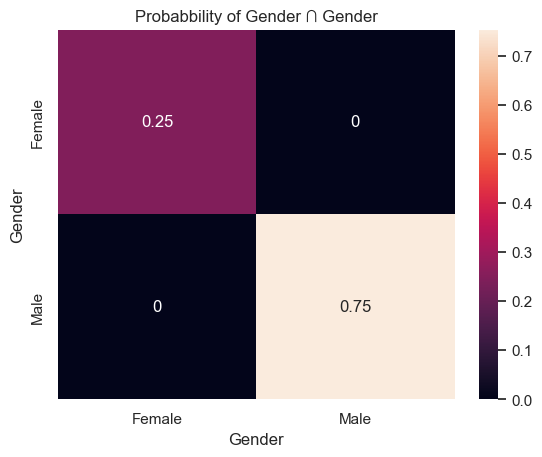

In [32]:
sns.heatmap(pd.crosstab(walmart_raw['Gender'], walmart_raw['Gender'], normalize='all'),annot=True)
plt.title('Probabbility of Gender ∩ Gender', fontsize=12)

##### `Descriptive` Plot

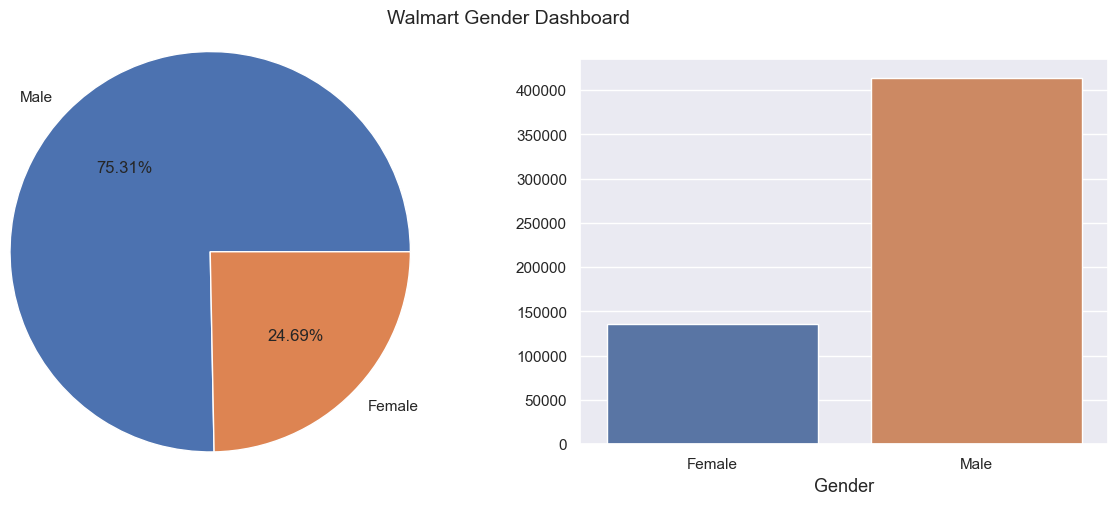

In [33]:
plt.figure(figsize=(15,5)).suptitle("Walmart Gender Dashboard",fontsize=14)

plt.subplot(1, 2, 1)
plt.pie(walmart_raw['Gender'].value_counts().values,labels = walmart_raw['Gender'].value_counts().index,radius = 1.3,autopct = '%1.2f%%',) # type: ignore

plt.subplot(1, 2
, 2)
sns.countplot(walmart_raw, x='Gender')
plt.ylabel('', fontsize=12)
plt.xlabel('Gender', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)

plt.show()

### **<span style="color: orange;">Marital Status</span>**

In [34]:
walmart_raw['marital_status'].unique()

['Single', 'Partnered']
Categories (2, object): ['Partnered', 'Single']

In [35]:
walmart_raw['marital_status'].value_counts()

Single       324731
Partnered    225337
Name: marital_status, dtype: int64

In [36]:
walmart_raw['marital_status'].value_counts(normalize=True)*100

Single       59.034701
Partnered    40.965299
Name: marital_status, dtype: float64

#### **<span style="color: #0099ff;">Statitical Analysis</span>**

In [37]:
walmart_raw['marital_status'].describe()

count     550068
unique         2
top       Single
freq      324731
Name: marital_status, dtype: object

In [38]:
walmart_raw['marital_status'].mode()[0]

'Single'

In [39]:
walmart_raw.groupby('Gender')["marital_status"].describe()

count unique     top    freq
Gender                               
Female  135809      2  Single   78821
Male    414259      2  Single  245910

#### **<span style="color: #818cf8;">Find Probability</span>**

##### Probability of a `Gender` & `Marital Status` across all Combination ***"Product ∩ Marital Status"***

In [40]:
pd.crosstab(walmart_raw['marital_status'], walmart_raw['Gender'], normalize=True, margins=True)*100

Gender             Female       Male         All
marital_status                                  
Partnered       10.360174  30.605125   40.965299
Single          14.329319  44.705382   59.034701
All             24.689493  75.310507  100.000000

##### Probability of `Gender's` for given `Marital Status`  ***"Product | Marital Status"***

In [41]:
pd.crosstab(walmart_raw['marital_status'], walmart_raw['Gender'], normalize='index', margins=True)*100

Gender             Female       Male
marital_status                      
Partnered       25.290121  74.709879
Single          24.272706  75.727294
All             24.689493  75.310507

##### Probability of `Marital Status` for given `Gender` ***"Marital Status | Product"***

In [42]:
pd.crosstab(walmart_raw['marital_status'], walmart_raw['Gender'], normalize='columns', margins=True)*100

Gender             Female       Male        All
marital_status                                 
Partnered       41.961873  40.638586  40.965299
Single          58.038127  59.361414  59.034701

#### **<span style="color: #b05abc;">Plot the Graph</span>**

##### `Heat Map`

Text(0.5, 1.0, 'Probabbility of Gender ∩ Marital Status')

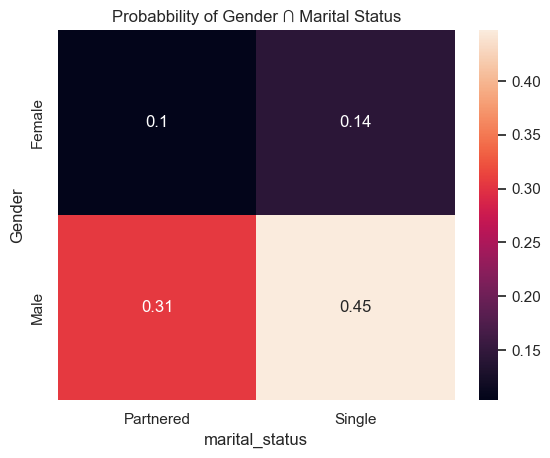

In [43]:
sns.heatmap(pd.crosstab(walmart_raw['Gender'], walmart_raw['marital_status'], normalize='all'),annot=True)
plt.title('Probabbility of Gender ∩ Marital Status', fontsize=12)

##### `Descriptive` Plot

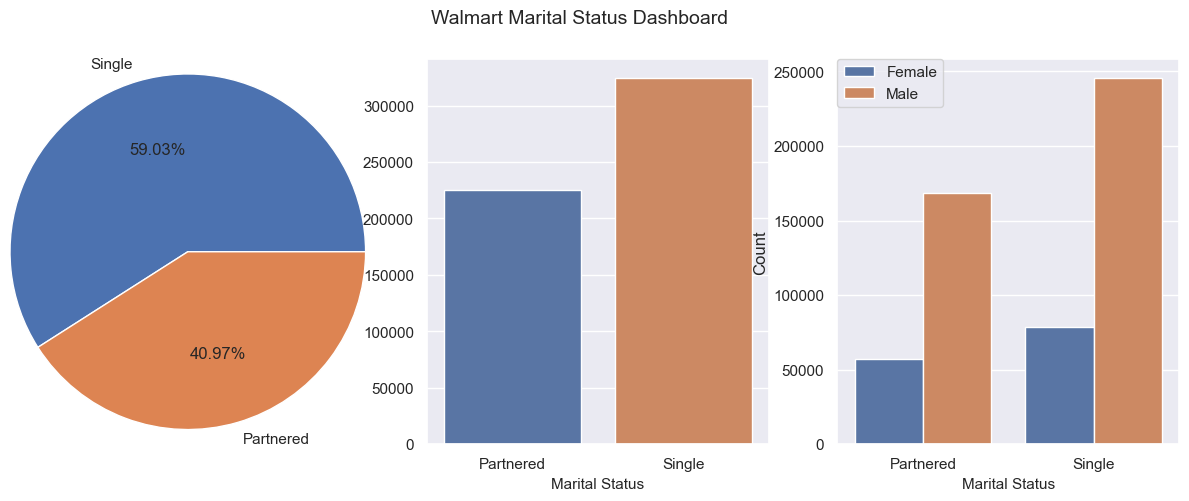

In [44]:
plt.figure(figsize=(15,5)).suptitle("Walmart Marital Status Dashboard",fontsize=14)

plt.subplot(1, 3, 1)
plt.pie(walmart_raw['marital_status'].value_counts().values,labels = walmart_raw['marital_status'].value_counts().index,radius = 1.3,autopct = '%1.2f%%',) # type: ignore

plt.subplot(1, 3, 2)
sns.countplot(walmart_raw, x='marital_status')
plt.ylabel('', fontsize=12)
plt.xlabel('Marital Status', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)

plt.subplot(1, 3, 3)
sns.countplot(walmart_raw, x='marital_status', hue='Gender')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Marital Status', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)
plt.legend(borderaxespad=0, ncol=1)

plt.show()

##### `Probability` Plot

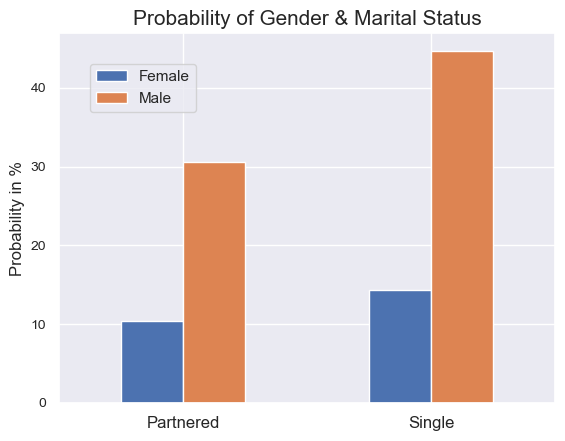

In [45]:
(pd.crosstab(walmart_raw['marital_status'], walmart_raw['Gender'], normalize=True)*100).plot(kind='bar')
plt.title('Probability of Gender & Marital Status', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=10)
plt.legend(borderaxespad=2, ncol=1)
plt.show()

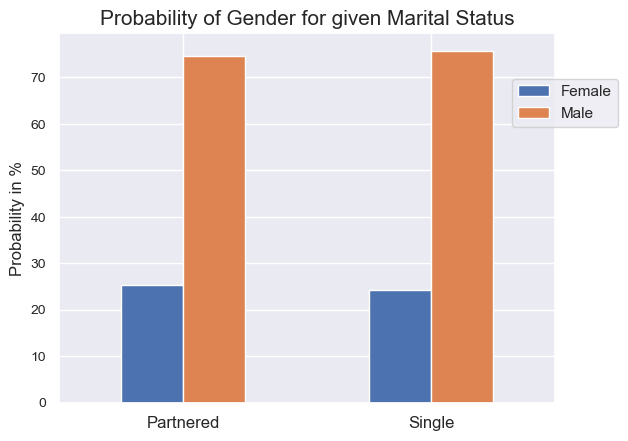

In [46]:
(pd.crosstab(walmart_raw['marital_status'], walmart_raw['Gender'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of Gender for given Marital Status', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper center', borderaxespad=3)
plt.show()

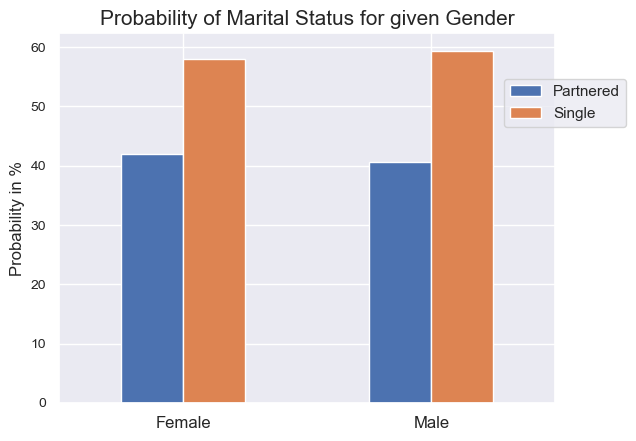

In [47]:
(pd.crosstab(walmart_raw['Gender'], walmart_raw['marital_status'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of Marital Status for given Gender', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper center', borderaxespad=3)
plt.show()

##### `Population` Plot

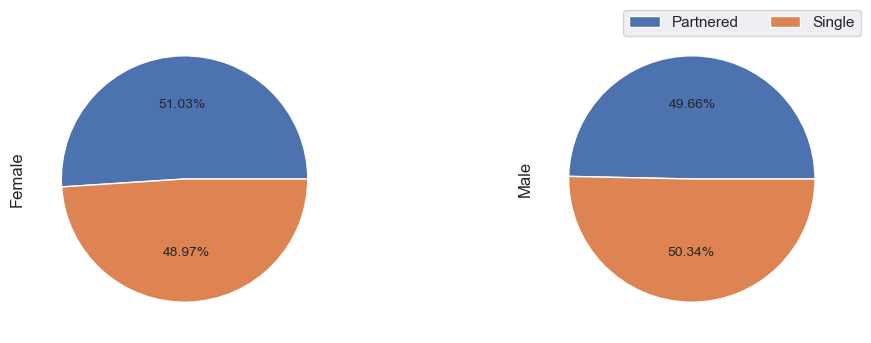

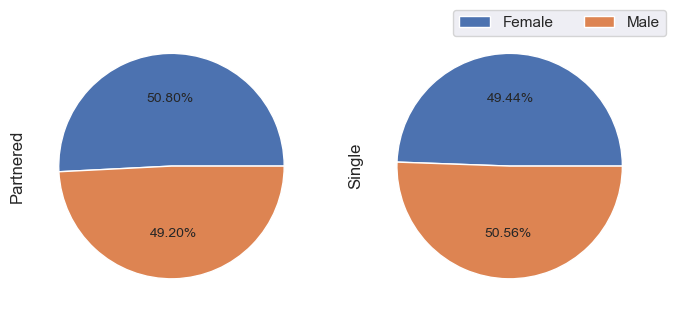

In [48]:
pd.crosstab(walmart_raw['marital_status'], walmart_raw['Gender'], normalize="index").plot(kind='pie', subplots=True, figsize=(12,4), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=3)
plt.show()
pd.crosstab(walmart_raw['Gender'], walmart_raw['marital_status'], normalize="index").plot(kind='pie', subplots=True, figsize=(8,4), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=3)
plt.show()

### **<span style="color: orange;">Age</span>**

In [49]:
walmart_raw['Age'].unique()

['0-17', '55+', '26-35', '46-50', '51-55', '36-45', '18-25']
Categories (7, object): ['0-17', '18-25', '26-35', '36-45', '46-50', '51-55', '55+']

In [50]:
walmart_raw['Age'].value_counts()[:5]

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
Name: Age, dtype: int64

In [51]:
walmart_raw['Age'].value_counts(normalize=True)[:5]*100

26-35    39.919974
36-45    19.999891
18-25    18.117760
46-50     8.308246
51-55     6.999316
Name: Age, dtype: float64

#### **<span style="color: #0099ff;">Statitical Analysis</span>**

In [52]:
walmart_raw['Age'].describe()

count     550068
unique         7
top        26-35
freq      219587
Name: Age, dtype: object

In [53]:
walmart_raw['age'].mean()

34.251961575659735

In [54]:
walmart_raw['age'].median()

30.5

In [55]:
walmart_raw['Age'].mode()[0]

'26-35'

In [56]:
walmart_raw.groupby('Gender')["Age"].describe()

count unique    top    freq
Gender                              
Female  135809      7  26-35   50752
Male    414259      7  26-35  168835

#### **<span style="color: #ff6600;">Check for Outliers</span>**

In [57]:
check_outlier(walmart_raw, 'age')['upper']

{'list': Series([], Name: age, dtype: float64), 'length': 0}

In [58]:
check_outlier(walmart_raw, 'age')['lower']

{'list': 0         8.5
 1         8.5
 2         8.5
 3         8.5
 85        8.5
          ... 
 549904    8.5
 550012    8.5
 550024    8.5
 550035    8.5
 550046    8.5
 Name: age, Length: 15102, dtype: float64,
 'length': 15102}

#### **<span style="color: #818cf8;">Find Probability</span>**

##### Probability of a `Age` & `Gender` across all Combination ***"Age ∩ Gender"***

In [59]:
pd.crosstab(walmart_raw['Gender'], walmart_raw['age'], normalize=True, margins=True)*100

age          8.5       21.5       30.5       40.5      48.0      53.0  \
Gender                                                                  
Female  0.924068   4.477265   9.226496   4.939389  2.399522  1.798687   
Male    1.821411  13.640495  30.693478  15.060502  5.908724  5.200630   
All     2.745479  18.117760  39.919974  19.999891  8.308246  6.999316   

age         55.0         All  
Gender                        
Female  0.924068   24.689493  
Male    2.985267   75.310507  
All     3.909335  100.000000

##### Probability of `Age's` for given `Gender`  ***"Age | Gender"***

In [60]:
pd.crosstab(walmart_raw['Gender'], walmart_raw['age'], normalize='index', margins=True)*100

age          8.5       21.5       30.5       40.5      48.0      53.0  \
Gender                                                                  
Female  3.742756  18.134292  37.370130  20.006038  9.718796  7.285231   
Male    2.418535  18.112340  40.755904  19.997876  7.845816  6.905583   
All     2.745479  18.117760  39.919974  19.999891  8.308246  6.999316   

age         55.0  
Gender            
Female  3.742756  
Male    3.963945  
All     3.909335

##### Probability of `Gender` for given `Age` ***"Gender | Age"***

In [61]:
pd.crosstab(walmart_raw['Gender'], walmart_raw['age'], normalize='columns', margins=True)*100

age           8.5       21.5       30.5       40.5       48.0       53.0  \
Gender                                                                     
Female  33.657794  24.712021  23.112479  24.697081  28.881206  25.698034   
Male    66.342206  75.287979  76.887521  75.302919  71.118794  74.301966   

age          55.0        All  
Gender                        
Female  23.637463  24.689493  
Male    76.362537  75.310507

#### **<span style="color: #b05abc;">Plot the Graph</span>**

##### `Heat Map`

Text(0.5, 1.0, 'Probabbility of Age ∩ Gender')

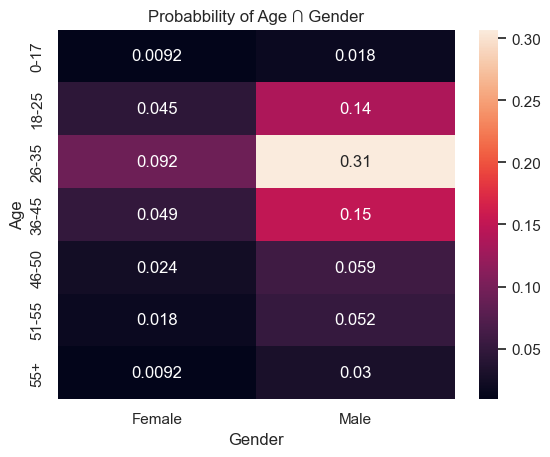

In [62]:
sns.heatmap(pd.crosstab(walmart_raw['Age'], walmart_raw['Gender'], normalize='all'),annot=True)
plt.title('Probabbility of Age ∩ Gender', fontsize=12)

##### `Descriptive` Plot

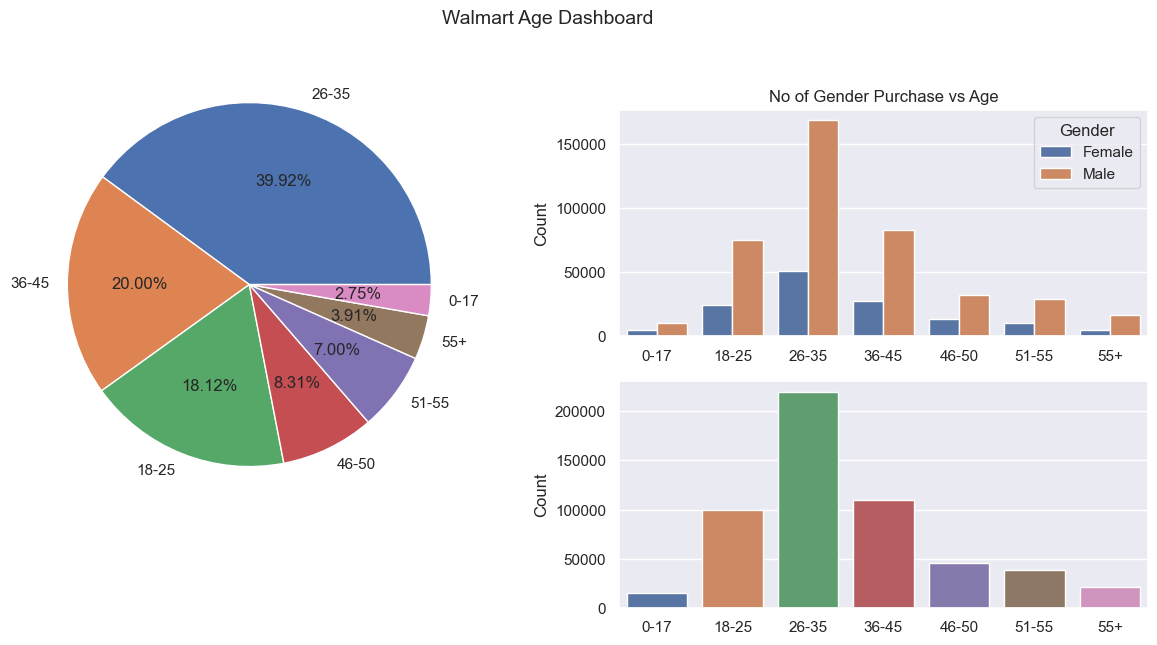

In [63]:
plt.figure(figsize=(15,10)).suptitle("Walmart Age Dashboard",fontsize=14)

plt.subplot(2, 2, 1)
plt.pie(walmart_raw['Age'].value_counts().values,labels = walmart_raw['Age'].value_counts().index,radius = 1.3,autopct = '%1.2f%%') # type: ignore

plt.subplot(3, 2, 2)
sns.countplot(walmart_raw, x='Age', hue='Gender')
plt.title('No of Gender Purchase vs Age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)

plt.subplot(3, 2, 4)
sns.countplot(walmart_raw, x='Age')
plt.ylabel('Count', fontsize=12)
plt.xlabel('', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)

plt.show()

##### `Probability` Plot

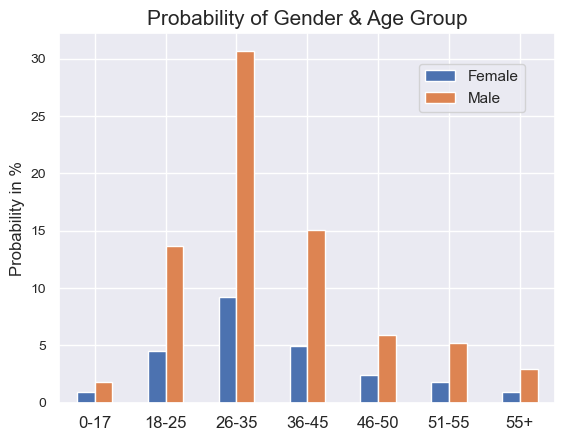

In [64]:
(pd.crosstab(walmart_raw['Age'], walmart_raw['Gender'], normalize=True)*100).plot(kind='bar')
plt.title('Probability of Gender & Age Group', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=10)
plt.legend(borderaxespad=2, ncol=1)
plt.show()

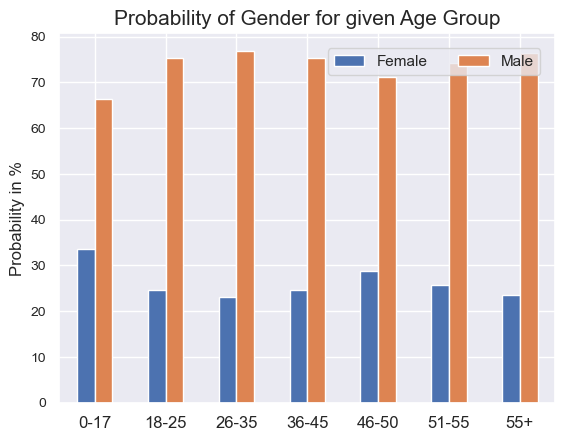

In [65]:
(pd.crosstab(walmart_raw['Age'], walmart_raw['Gender'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of Gender for given Age Group', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=10)
plt.legend(borderaxespad=1, ncol=3)
plt.show()

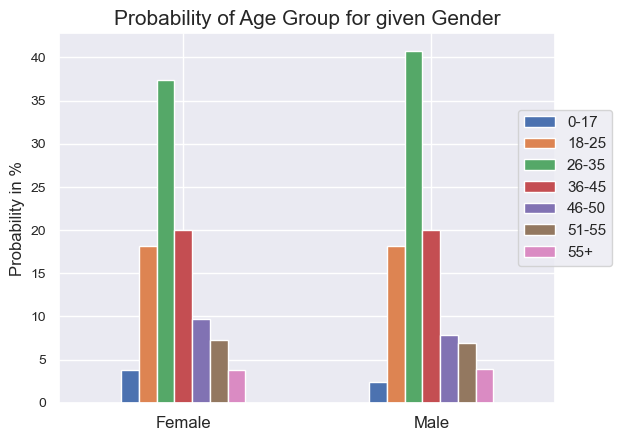

In [66]:
(pd.crosstab(walmart_raw['Gender'], walmart_raw['Age'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of Age Group for given Gender', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=10)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper center', borderaxespad=5)

plt.show()

##### `Population` Plot

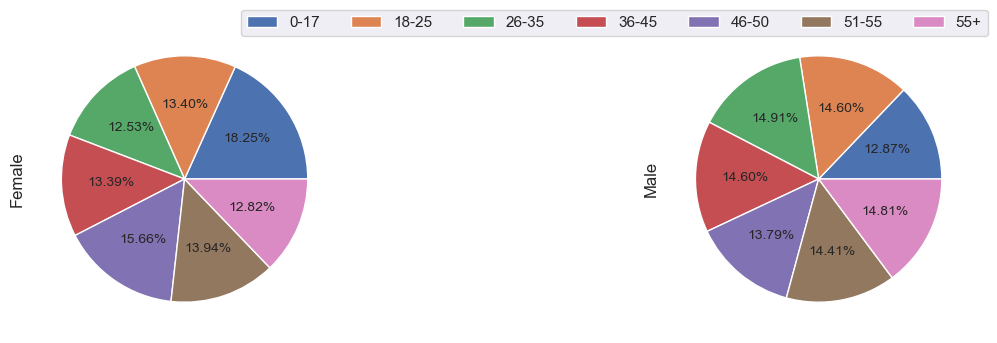

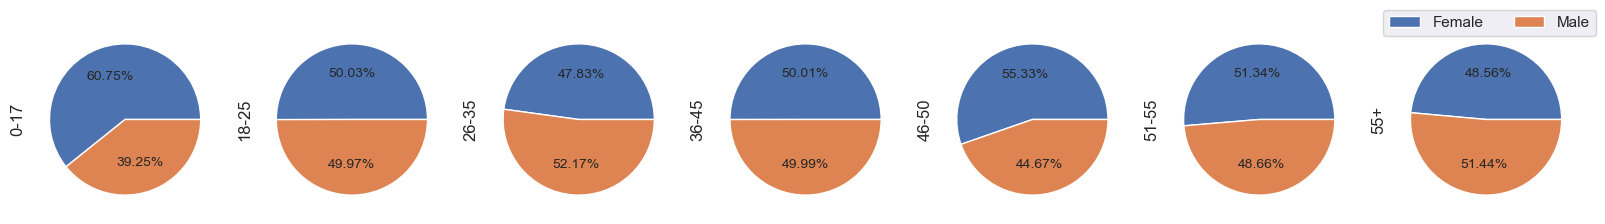

In [67]:
pd.crosstab(walmart_raw['Age'], walmart_raw['Gender'], normalize="index").plot(kind='pie', subplots=True, figsize=(15,4), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=7)
plt.show()
pd.crosstab(walmart_raw['Gender'], walmart_raw['Age'], normalize="index").plot(kind='pie', subplots=True, figsize=(20,5), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=3)
plt.show()

### **<span style="color: orange;">City Category</span>**

In [68]:
walmart_raw['City_Category'].unique()

['A', 'C', 'B']
Categories (3, object): ['A', 'B', 'C']

In [69]:
walmart_raw['City_Category'].value_counts()

B    231173
C    171175
A    147720
Name: City_Category, dtype: int64

In [70]:
walmart_raw['City_Category'].value_counts(normalize=True)*100

B    42.026259
C    31.118880
A    26.854862
Name: City_Category, dtype: float64

#### **<span style="color: #0099ff;">Statitical Analysis</span>**

In [71]:
walmart_raw['City_Category'].describe()

count     550068
unique         3
top            B
freq      231173
Name: City_Category, dtype: object

In [72]:
walmart_raw['City_Category'].mode()[0]

'B'

In [73]:
walmart_raw.groupby('Gender')["City_Category"].describe()

count unique top    freq
Gender                           
Female  135809      3   B   57796
Male    414259      3   B  173377

#### **<span style="color: #818cf8;">Find Probability</span>**

##### Probability of a `Gender` & `City Category` across all Combination ***"Gender ∩ City Category"***

In [74]:
pd.crosstab(walmart_raw['City_Category'], walmart_raw['Gender'], normalize=True, margins=True)*100

Gender            Female       Male         All
City_Category                                  
A               6.490834  20.364028   26.854862
B              10.507065  31.519194   42.026259
C               7.691594  23.427285   31.118880
All            24.689493  75.310507  100.000000

##### Probability of `Gender's` for given `City Category`  ***"Gender | City Category"***

In [75]:
pd.crosstab(walmart_raw['City_Category'], walmart_raw['Gender'], normalize='index', margins=True)*100

Gender            Female       Male
City_Category                      
A              24.170051  75.829949
B              25.001190  74.998810
C              24.716810  75.283190
All            24.689493  75.310507

##### Probability of `City Category` for given `Gender` ***"City Category | Product"***

In [76]:
pd.crosstab(walmart_raw['City_Category'], walmart_raw['Gender'], normalize='columns', margins=True)*100

Gender            Female       Male        All
City_Category                                 
A              26.289863  27.040088  26.854862
B              42.556826  41.852319  42.026259
C              31.153311  31.107592  31.118880

#### **<span style="color: #b05abc;">Plot the Graph</span>**

##### `Heat Map`

Text(0.5, 1.0, 'Probabbility of Gender ∩ City Category')

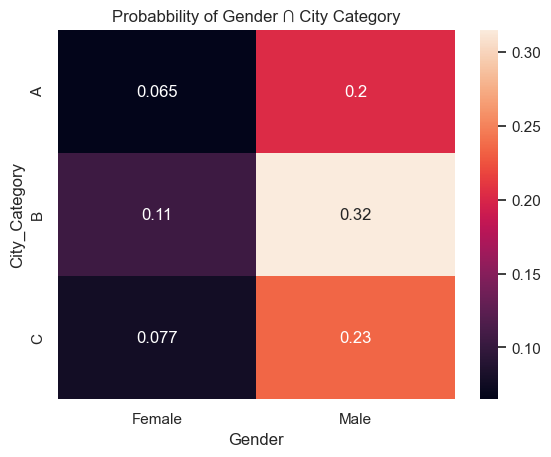

In [77]:
sns.heatmap(pd.crosstab(walmart_raw['City_Category'], walmart_raw['Gender'], normalize='all'),annot=True)
plt.title('Probabbility of Gender ∩ City Category', fontsize=12)

##### `Descriptive` Plot

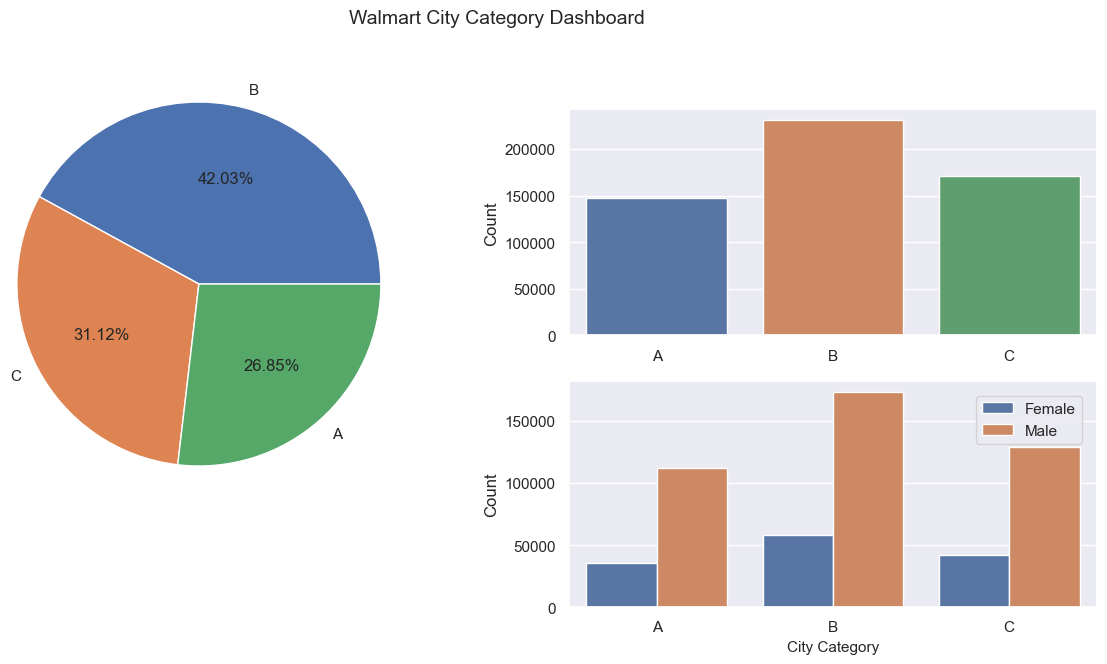

In [78]:
plt.figure(figsize=(15,10)).suptitle("Walmart City Category Dashboard",fontsize=14)

plt.subplot(2, 2, 1)
plt.pie(walmart_raw['City_Category'].value_counts().values,labels = walmart_raw['City_Category'].value_counts().index,radius = 1.3,autopct = '%1.2f%%') # type: ignore

plt.subplot(3, 2, 2)
sns.countplot(walmart_raw, x='City_Category')
plt.ylabel('Count', fontsize=12)
plt.xlabel('', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)

plt.subplot(3, 2, 4)
sns.countplot(walmart_raw, x='City_Category', hue='Gender')
plt.ylabel('Count', fontsize=12)
plt.xlabel('City Category', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)
plt.legend(borderaxespad=1, ncol=1)

plt.show()

##### `Probability` Plot

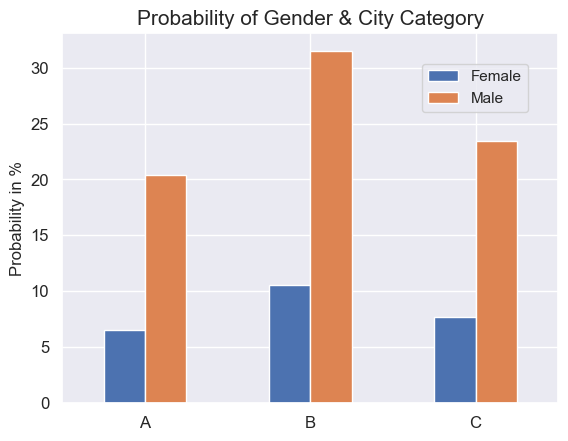

In [79]:
(pd.crosstab(walmart_raw['City_Category'], walmart_raw['Gender'], normalize=True)*100).plot(kind='bar')
plt.title('Probability of Gender & City Category', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(borderaxespad=2, ncol=1)
plt.show()

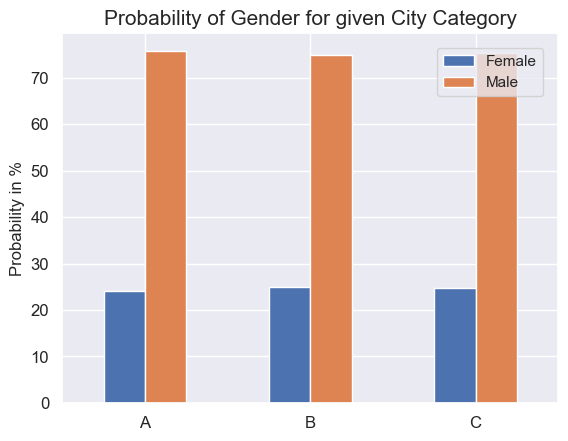

In [80]:
(pd.crosstab(walmart_raw['City_Category'], walmart_raw['Gender'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of Gender for given City Category', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(borderaxespad=1, ncol=1)
plt.show()

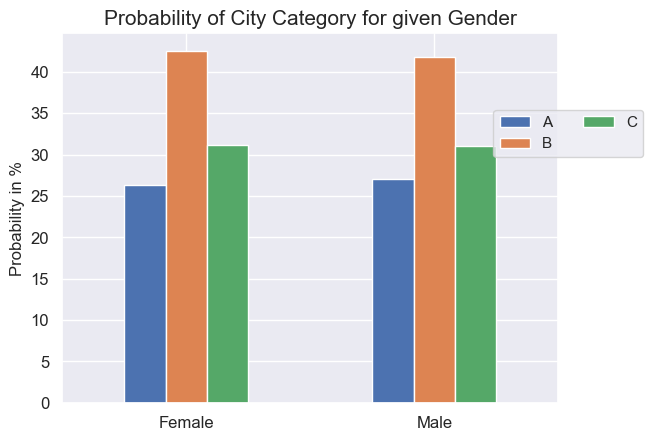

In [81]:
(pd.crosstab(walmart_raw['Gender'], walmart_raw['City_Category'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of City Category for given Gender', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper center', borderaxespad=5, ncol=2)

plt.show()

##### `Population` Plot

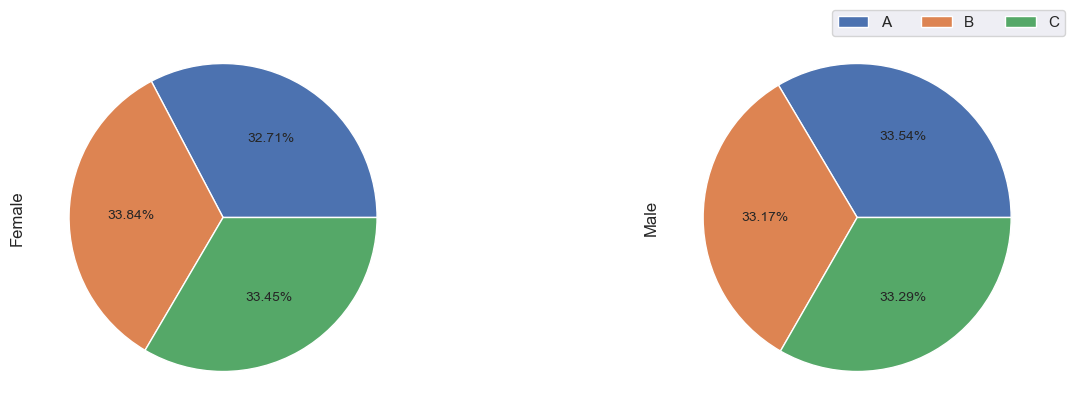

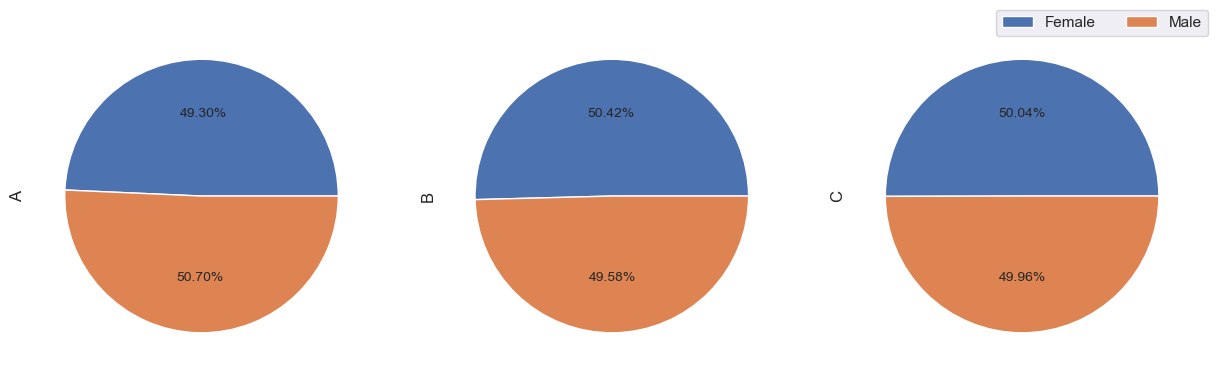

In [82]:
pd.crosstab(walmart_raw['City_Category'], walmart_raw['Gender'], normalize="index").plot(kind='pie', subplots=True, figsize=(15,5), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=7)
plt.show()
pd.crosstab(walmart_raw['Gender'], walmart_raw['City_Category'], normalize="index").plot(kind='pie', subplots=True, figsize=(15,5), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=3)
plt.show()

### **<span style="color: orange;">Stay In Current City Years</span>**

In [83]:
walmart_raw['Stay_In_Current_City_Years'].unique()

['2', '4+', '3', '1', '0']
Categories (5, object): ['0', '1', '2', '3', '4+']

In [84]:
walmart_raw['Stay_In_Current_City_Years'].value_counts()

1     193821
2     101838
3      95285
4+     84726
0      74398
Name: Stay_In_Current_City_Years, dtype: int64

In [85]:
walmart_raw['Stay_In_Current_City_Years'].value_counts(normalize=True)*100

1     35.235825
2     18.513711
3     17.322404
4+    15.402823
0     13.525237
Name: Stay_In_Current_City_Years, dtype: float64

#### **<span style="color: #0099ff;">Statitical Analysis</span>**

In [86]:
walmart_raw['Stay_In_Current_City_Years'].describe()

count     550068
unique         5
top            1
freq      193821
Name: Stay_In_Current_City_Years, dtype: object

In [87]:
walmart_raw['Stay_In_Current_City_Years'].mode()[0]

'1'

In [88]:
walmart_raw.groupby('Gender')["Stay_In_Current_City_Years"].describe()

count unique top    freq
Gender                           
Female  135809      5   1   51298
Male    414259      5   1  142523

#### **<span style="color: #818cf8;">Find Probability</span>**

##### Probability of a `Gender` & `Stay In Current City Years` across all Combination ***"Gender ∩ Stay In Current City Years"***

In [89]:
pd.crosstab(walmart_raw['Stay_In_Current_City_Years'], walmart_raw['Gender'], normalize=True, margins=True)*100

Gender                         Female       Male         All
Stay_In_Current_City_Years                                  
0                            3.101980  10.423257   13.525237
1                            9.325756  25.910069   35.235825
2                            4.423453  14.090258   18.513711
3                            4.457631  12.864773   17.322404
4+                           3.380673  12.022150   15.402823
All                         24.689493  75.310507  100.000000

##### Probability of `Gender's` for given `Stay In Current City Years`  ***"Gender | Stay In Current City Years"***

In [90]:
pd.crosstab(walmart_raw['Stay_In_Current_City_Years'], walmart_raw['Gender'], normalize='index', margins=True)*100

Gender                         Female       Male
Stay_In_Current_City_Years                      
0                           22.934756  77.065244
1                           26.466688  73.533312
2                           23.892849  76.107151
3                           25.733326  74.266674
4+                          21.948398  78.051602
All                         24.689493  75.310507

##### Probability of `Stay In Current City Years` for given `Gender` ***"Stay In Current City Years | Product"***

In [91]:
pd.crosstab(walmart_raw['Stay_In_Current_City_Years'], walmart_raw['Gender'], normalize='columns', margins=True)*100

Gender                         Female       Male        All
Stay_In_Current_City_Years                                 
0                           12.563969  13.840375  13.525237
1                           37.772165  34.404322  35.235825
2                           17.916338  18.709551  18.513711
3                           18.054768  17.082308  17.322404
4+                          13.692760  15.963443  15.402823

#### **<span style="color: #b05abc;">Plot the Graph</span>**

##### `Heat Map`

Text(0.5, 1.0, 'Probabbility of Gender ∩ Stay In Current City Years')

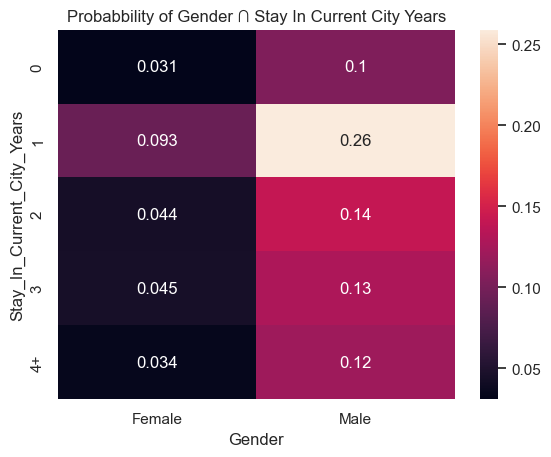

In [92]:
sns.heatmap(pd.crosstab(walmart_raw['Stay_In_Current_City_Years'], walmart_raw['Gender'], normalize='all'),annot=True)
plt.title('Probabbility of Gender ∩ Stay In Current City Years', fontsize=12)

##### `Descriptive` Plot

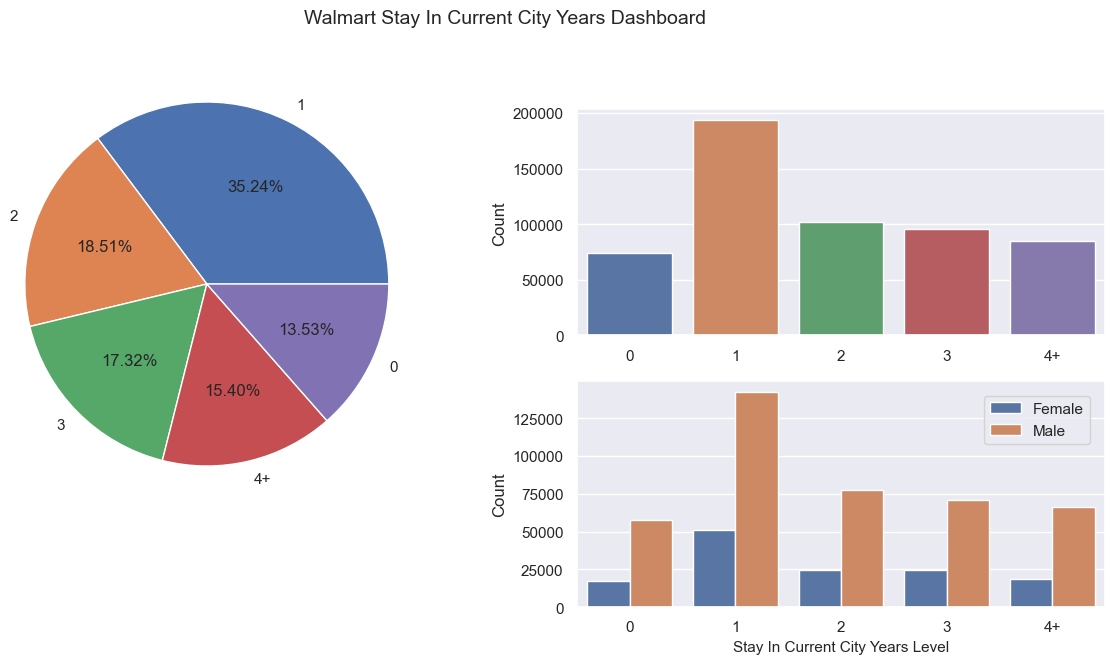

In [93]:
plt.figure(figsize=(15,10)).suptitle("Walmart Stay In Current City Years Dashboard",fontsize=14)

plt.subplot(2, 2, 1)
plt.pie(walmart_raw['Stay_In_Current_City_Years'].value_counts().values,labels = walmart_raw['Stay_In_Current_City_Years'].value_counts().index,radius = 1.3,autopct = '%1.2f%%') # type: ignore

plt.subplot(3, 2, 2)
sns.countplot(walmart_raw, x='Stay_In_Current_City_Years')
plt.ylabel('Count', fontsize=12)
plt.xlabel('', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)

plt.subplot(3, 2, 4)
sns.countplot(walmart_raw, x='Stay_In_Current_City_Years', hue='Gender')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Stay In Current City Years Level', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)
plt.legend(borderaxespad=1, ncol=1)

plt.show()

##### `Probability` Plot

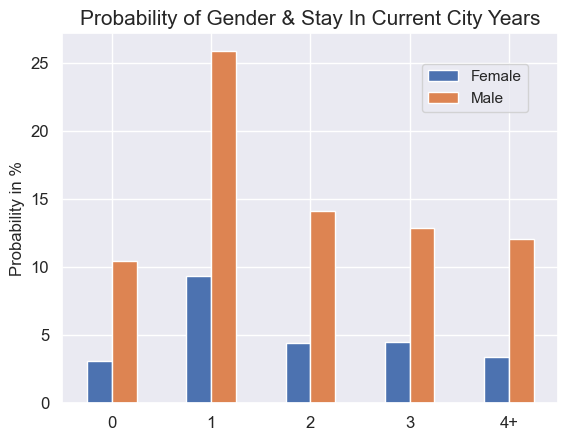

In [94]:
(pd.crosstab(walmart_raw['Stay_In_Current_City_Years'], walmart_raw['Gender'], normalize=True)*100).plot(kind='bar')
plt.title('Probability of Gender & Stay In Current City Years', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(borderaxespad=2, ncol=1)
plt.show()

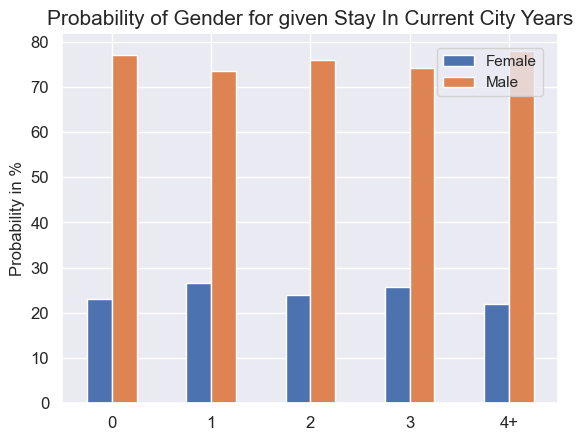

In [95]:
(pd.crosstab(walmart_raw['Stay_In_Current_City_Years'], walmart_raw['Gender'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of Gender for given Stay In Current City Years', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(borderaxespad=1, ncol=1)
plt.show()

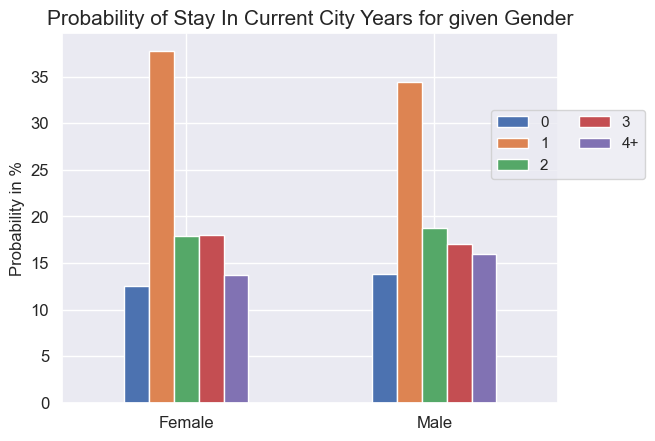

In [96]:
(pd.crosstab(walmart_raw['Gender'], walmart_raw['Stay_In_Current_City_Years'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of Stay In Current City Years for given Gender', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper center', borderaxespad=5, ncol=2)

plt.show()

##### `Population` Plot

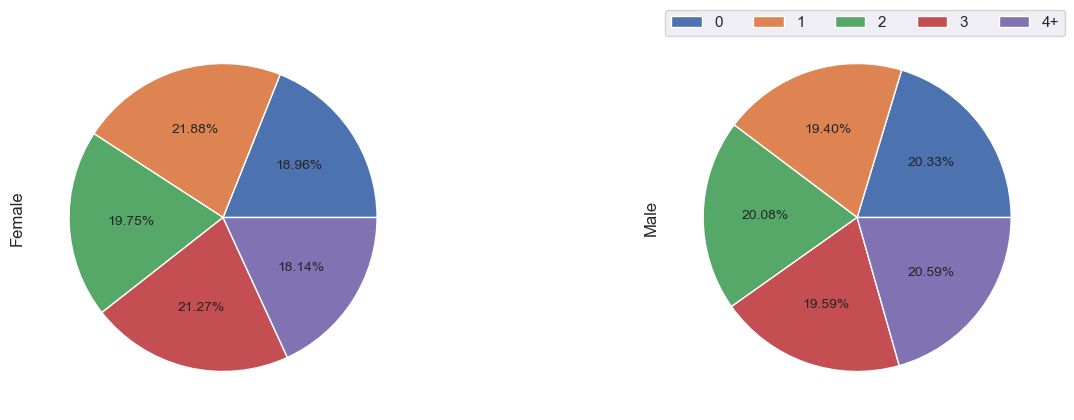

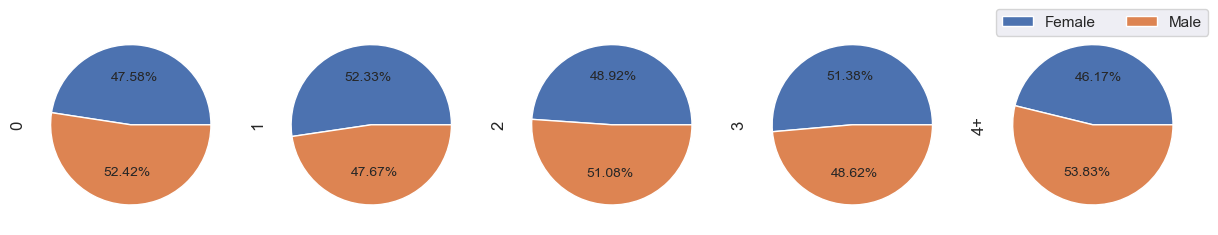

In [97]:
pd.crosstab(walmart_raw['Stay_In_Current_City_Years'], walmart_raw['Gender'], normalize="index").plot(kind='pie', subplots=True, figsize=(15,5), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=7)
plt.show()
pd.crosstab(walmart_raw['Gender'], walmart_raw['Stay_In_Current_City_Years'], normalize="index").plot(kind='pie', subplots=True, figsize=(15,5), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=3)
plt.show()

### **<span style="color: orange;">Occupation</span>**

In [98]:
walmart_raw['Occupation'].unique()

array([10, 16, 15,  7, 20,  9,  1, 12, 17,  0,  3,  4, 11,  8, 19,  2, 18,
        5, 14, 13,  6], dtype=int64)

In [99]:
walmart_raw['Occupation'].value_counts()

4     72308
0     69638
7     59133
1     47426
17    40043
20    33562
12    31179
14    27309
2     26588
16    25371
6     20355
3     17650
10    12930
5     12177
15    12165
11    11586
19     8461
13     7728
18     6622
9      6291
8      1546
Name: Occupation, dtype: int64

In [100]:
walmart_raw['Occupation'].value_counts(normalize=True)*100

4     13.145284
0     12.659889
7     10.750125
1      8.621843
17     7.279645
20     6.101427
12     5.668208
14     4.964659
2      4.833584
16     4.612339
6      3.700452
3      3.208694
10     2.350618
5      2.213726
15     2.211545
11     2.106285
19     1.538173
13     1.404917
18     1.203851
9      1.143677
8      0.281056
Name: Occupation, dtype: float64

#### **<span style="color: #0099ff;">Statitical Analysis</span>**

In [101]:
walmart_raw['Occupation'].describe()

count    550068.000000
mean          8.076707
std           6.522660
min           0.000000
25%           2.000000
50%           7.000000
75%          14.000000
max          20.000000
Name: Occupation, dtype: float64

In [102]:
walmart_raw['Occupation'].mean()

8.076706879876669

In [103]:
walmart_raw['Occupation'].median()

7.0

In [104]:
walmart_raw['Occupation'].mode()[0]

4

In [105]:
walmart_raw.groupby('Gender')["Occupation"].describe()

count     mean       std  min  25%  50%   75%   max
Gender                                                        
Female  135809.0  6.74054  6.239639  0.0  1.0  4.0  11.0  20.0
Male    414259.0  8.51475  6.553790  0.0  3.0  7.0  15.0  20.0

#### **<span style="color: #ff6600;">Check for Outliers</span>**

In [106]:
check_outlier(walmart_raw, 'Occupation')['upper']

{'list': Series([], Name: Occupation, dtype: int64), 'length': 0}

In [107]:
check_outlier(walmart_raw, 'Occupation')['lower']

{'list': Series([], Name: Occupation, dtype: int64), 'length': 0}

#### **<span style="color: #818cf8;">Find Probability</span>**

##### Probability of a `Gender` & `Occupation` across all Combination ***"Gender ∩ Occupation"***

In [108]:
pd.crosstab(walmart_raw['Occupation'], walmart_raw['Gender'], normalize=True, margins=True)*100

Gender         Female       Male         All
Occupation                                  
0            3.292684   9.367206   12.659889
1            3.269414   5.352429    8.621843
2            1.568715   3.264869    4.833584
3            1.439640   1.769054    3.208694
4            3.242508   9.902776   13.145284
5            0.403586   1.810140    2.213726
6            1.483453   2.216999    3.700452
7            1.823047   8.927078   10.750125
8            0.065628   0.215428    0.281056
9            1.062232   0.081444    1.143677
10           0.727728   1.622890    2.350618
11           0.272694   1.833591    2.106285
12           0.630649   5.037559    5.668208
13           0.272330   1.132587    1.404917
14           1.229484   3.735175    4.964659
15           0.434492   1.777053    2.211545
16           0.746635   3.865704    4.612339
17           0.714275   6.565370    7.279645
18           0.041813   1.162038    1.203851
19           0.366682   1.171492    1.538173
20           1.601802   4.499626    6.101427
All         24.689493  75.310507  100.000000

##### Probability of `Gender's` for given `Occupation`  ***"Gender | Occupation"***

In [109]:
pd.crosstab(walmart_raw['Occupation'], walmart_raw['Gender'], normalize='index', margins=True)*100

Gender         Female       Male
Occupation                      
0           26.008788  73.991212
1           37.920128  62.079872
2           32.454491  67.545509
3           44.866856  55.133144
4           24.666704  75.333296
5           18.231091  81.768909
6           40.088430  59.911570
7           16.958382  83.041618
8           23.350582  76.649418
9           92.878716   7.121284
10          30.959010  69.040990
11          12.946660  87.053340
12          11.126078  88.873922
13          19.384058  80.615942
14          24.764730  75.235270
15          19.646527  80.353473
16          16.187773  83.812227
17           9.811952  90.188048
18           3.473271  96.526729
19          23.838790  76.161210
20          26.252905  73.747095
All         24.689493  75.310507

##### Probability of `Occupation` for given `Gender` ***"Occupation | Product"***

In [110]:
pd.crosstab(walmart_raw['Occupation'], walmart_raw['Gender'], normalize='columns', margins=True)*100

Gender         Female       Male        All
Occupation                                 
0           13.336377  12.438112  12.659889
1           13.242127   7.107148   8.621843
2            6.353776   4.335211   4.833584
3            5.830983   2.349014   3.208694
4           13.133150  13.149262  13.145284
5            1.634649   2.403569   2.213726
6            6.008438   2.943811   3.700452
7            7.383899  11.853695  10.750125
8            0.265814   0.286053   0.281056
9            4.302366   0.108145   1.143677
10           2.947522   2.154932   2.350618
11           1.104492   2.434709   2.106285
12           2.554323   6.689052   5.668208
13           1.103020   1.503890   1.404917
14           4.979788   4.959699   4.964659
15           1.759824   2.359635   2.211545
16           3.024100   5.133021   4.612339
17           2.893034   8.717735   7.279645
18           0.169355   1.542996   1.203851
19           1.485174   1.555549   1.538173
20           6.487788   5.974765   6.101427

#### **<span style="color: #b05abc;">Plot the Graph</span>**

##### `Heat Map`

Text(0.5, 1.0, 'Probabbility of Gender ∩ Occupation')

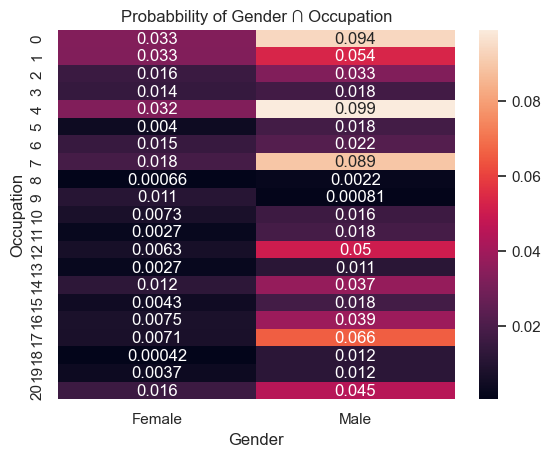

In [111]:
sns.heatmap(pd.crosstab(walmart_raw['Occupation'], walmart_raw['Gender'], normalize='all'),annot=True)
plt.title('Probabbility of Gender ∩ Occupation', fontsize=12)

##### `Descriptive` Plot

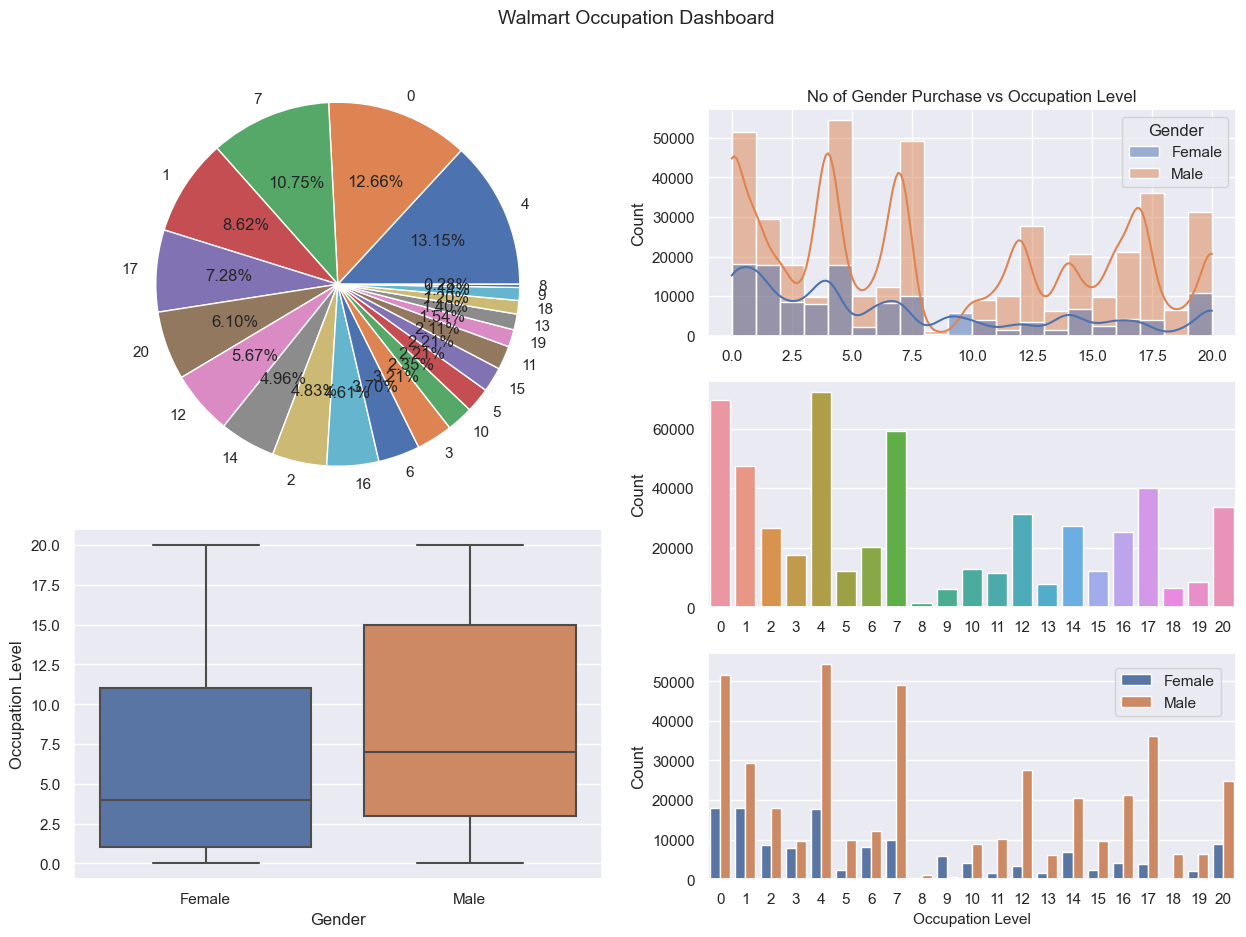

In [112]:
plt.figure(figsize=(15,10)).suptitle("Walmart Occupation Dashboard",fontsize=14)

plt.subplot(2, 2, 1)
plt.pie(walmart_raw['Occupation'].value_counts().values,labels = walmart_raw['Occupation'].value_counts().index,radius = 1.3,autopct = '%1.2f%%') # type: ignore

plt.subplot(2, 2, 3)
sns.boxplot(walmart_raw, y="Occupation", x='Gender')
plt.ylabel('Occupation Level', fontsize=12)

plt.subplot(3, 2, 2)
sns.histplot(walmart_raw, x='Occupation', binwidth=1, kde=True, hue="Gender")
plt.title('No of Gender Purchase vs Occupation Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)

plt.subplot(3, 2, 4)
sns.countplot(walmart_raw, x='Occupation')
plt.ylabel('Count', fontsize=12)
plt.xlabel('', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)

plt.subplot(3, 2, 6)
sns.countplot(walmart_raw, x='Occupation', hue='Gender')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Occupation Level', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)
plt.legend(borderaxespad=1, ncol=1)

plt.show()

##### `Probability` Plot

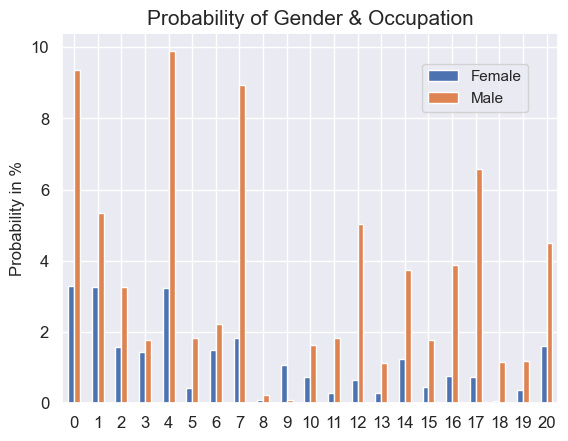

In [113]:
(pd.crosstab(walmart_raw['Occupation'], walmart_raw['Gender'], normalize=True)*100).plot(kind='bar')
plt.title('Probability of Gender & Occupation', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(borderaxespad=2, ncol=1)
plt.show()

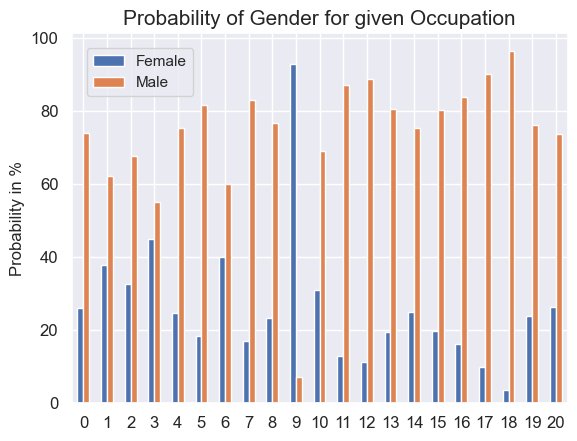

In [114]:
(pd.crosstab(walmart_raw['Occupation'], walmart_raw['Gender'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of Gender for given Occupation', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(borderaxespad=1, ncol=1)
plt.show()

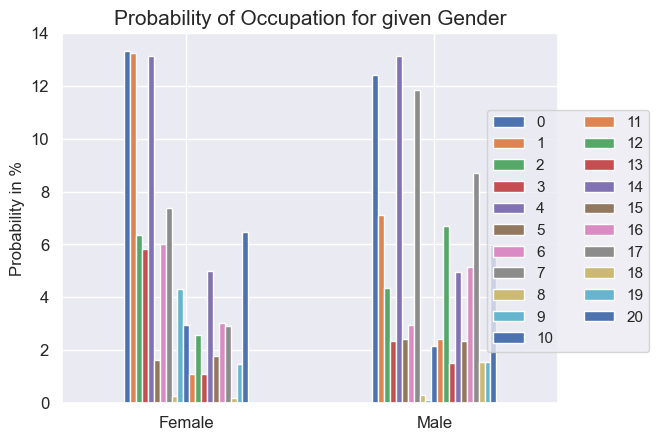

In [115]:
(pd.crosstab(walmart_raw['Gender'], walmart_raw['Occupation'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of Occupation for given Gender', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper center', borderaxespad=5, ncol=2)

plt.show()

##### `Population` Plot

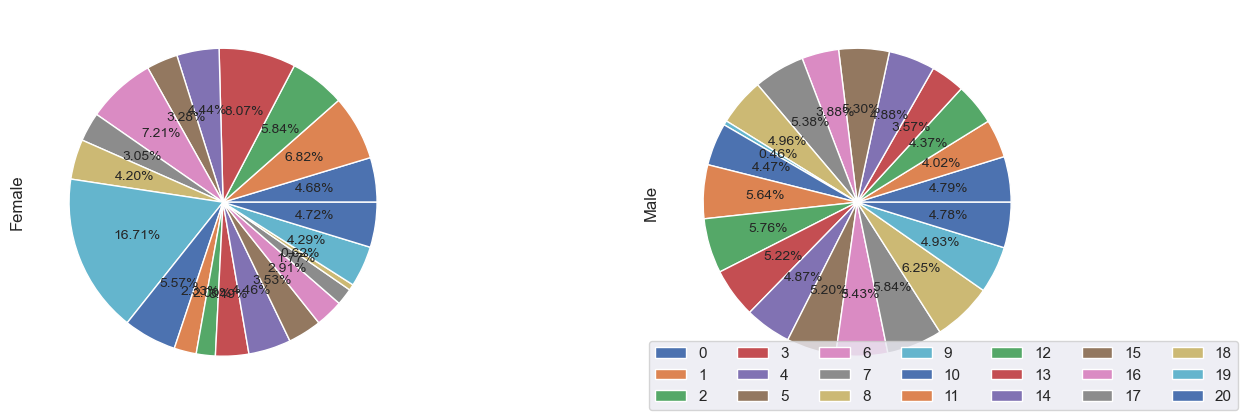

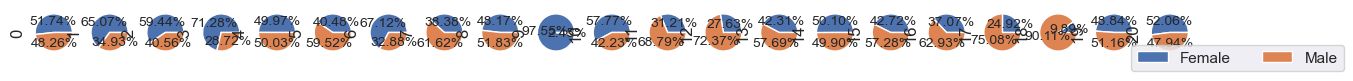

In [116]:
pd.crosstab(walmart_raw['Occupation'], walmart_raw['Gender'], normalize="index").plot(kind='pie', subplots=True, figsize=(15,5), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=7)
plt.show()
pd.crosstab(walmart_raw['Gender'], walmart_raw['Occupation'], normalize="index").plot(kind='pie', subplots=True, figsize=(15,5), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=3)
plt.show()

### **<span style="color: orange;">Product ID</span>**

In [117]:
walmart_raw['Product_ID'].unique()

array(['P00069042', 'P00248942', 'P00087842', ..., 'P00370293',
       'P00371644', 'P00370853'], dtype=object)

In [118]:
walmart_raw['Product_ID'].value_counts()

P00265242    1880
P00025442    1615
P00110742    1612
P00112142    1562
P00057642    1470
             ... 
P00314842       1
P00298842       1
P00231642       1
P00204442       1
P00066342       1
Name: Product_ID, Length: 3631, dtype: int64

#### **<span style="color: #0099ff;">Statitical Analysis</span>**

In [119]:
walmart_raw['Product_ID'].describe()

count        550068
unique         3631
top       P00265242
freq           1880
Name: Product_ID, dtype: object

In [120]:
walmart_raw['Product_ID'].mode()[0]

'P00265242'

#### **<span style="color: #818cf8;">Find Probability</span>**

In [121]:
walmart_raw['Product_ID'].value_counts(normalize=True)*100

P00265242    0.341776
P00025442    0.293600
P00110742    0.293055
P00112142    0.283965
P00057642    0.267240
               ...   
P00314842    0.000182
P00298842    0.000182
P00231642    0.000182
P00204442    0.000182
P00066342    0.000182
Name: Product_ID, Length: 3631, dtype: float64

### **<span style="color: orange;">Product Category</span>**

In [122]:
walmart_raw['Product_Category'].unique()

array([ 3,  1, 12,  8,  5,  4,  2,  6, 14, 11, 13, 15,  7, 16, 18, 10, 17,
        9, 20, 19], dtype=int64)

In [123]:
walmart_raw['Product_Category'].value_counts()

5     150933
1     140378
8     113925
11     24287
2      23864
6      20466
3      20213
4      11753
16      9828
15      6290
13      5549
10      5125
12      3947
7       3721
18      3125
20      2550
19      1603
14      1523
17       578
9        410
Name: Product_Category, dtype: int64

In [124]:
walmart_raw['Product_Category'].value_counts(normalize=True)*100

5     27.438971
1     25.520118
8     20.711076
11     4.415272
2      4.338373
6      3.720631
3      3.674637
4      2.136645
16     1.786688
15     1.143495
13     1.008784
10     0.931703
12     0.717548
7      0.676462
18     0.568112
20     0.463579
19     0.291419
14     0.276875
17     0.105078
9      0.074536
Name: Product_Category, dtype: float64

#### **<span style="color: #0099ff;">Statitical Analysis</span>**

In [125]:
walmart_raw['Product_Category'].describe()

count    550068.000000
mean          5.404270
std           3.936211
min           1.000000
25%           1.000000
50%           5.000000
75%           8.000000
max          20.000000
Name: Product_Category, dtype: float64

In [126]:
walmart_raw['Product_Category'].mean()

5.404270017525106

In [127]:
walmart_raw['Product_Category'].median()

5.0

In [128]:
walmart_raw['Product_Category'].mode()[0]

5

In [129]:
walmart_raw.groupby('Gender')["Product_Category"].describe()

count      mean       std  min  25%  50%  75%   max
Gender                                                        
Female  135809.0  5.717714  3.696752  1.0  3.0  5.0  8.0  20.0
Male    414259.0  5.301512  4.006275  1.0  1.0  5.0  8.0  20.0

#### **<span style="color: #ff6600;">Check for Outliers</span>**

In [130]:
check_outlier(walmart_raw, 'Product_Category')['upper']

{'list': 545915    20
 545916    20
 545917    20
 545918    20
 545919    20
           ..
 550063    20
 550064    20
 550065    20
 550066    20
 550067    20
 Name: Product_Category, Length: 4153, dtype: int64,
 'length': 4153}

In [131]:
check_outlier(walmart_raw, 'Product_Category')['lower']

{'list': Series([], Name: Product_Category, dtype: int64), 'length': 0}

#### **<span style="color: #818cf8;">Find Probability</span>**

##### Probability of a `Gender` & `Product Category` across all Combination ***"Gender ∩ Product Category"***

In [132]:
pd.crosstab(walmart_raw['Product_Category'], walmart_raw['Gender'], normalize=True, margins=True)*100

Gender               Female       Male         All
Product_Category                                  
1                  4.514169  21.005948   25.520118
2                  1.028600   3.309773    4.338373
3                  1.091865   2.582772    3.674637
4                  0.661555   1.475090    2.136645
5                  7.628330  19.810642   27.438971
6                  0.828807   2.891824    3.720631
7                  0.171433   0.505028    0.676462
8                  6.100700  14.610375   20.711076
9                  0.012726   0.061811    0.074536
10                 0.211247   0.720456    0.931703
11                 0.861530   3.553742    4.415272
12                 0.278511   0.439037    0.717548
13                 0.265785   0.742999    1.008784
14                 0.113259   0.163616    0.276875
15                 0.190158   0.953337    1.143495
16                 0.436673   1.350015    1.786688
17                 0.011271   0.093807    0.105078
18                 0.069446   0.498666    0.568112
19                 0.081990   0.209429    0.291419
20                 0.131438   0.332141    0.463579
All               24.689493  75.310507  100.000000

##### Probability of `Gender's` for given `Product Category`  ***"Gender | Product Category"***

In [133]:
pd.crosstab(walmart_raw['Product_Category'], walmart_raw['Gender'], normalize='index', margins=True)*100

Gender               Female       Male
Product_Category                      
1                 17.688669  82.311331
2                 23.709353  76.290647
3                 29.713551  70.286449
4                 30.962307  69.037693
5                 27.801077  72.198923
6                 22.275970  77.724030
7                 25.342650  74.657350
8                 29.456221  70.543779
9                 17.073171  82.926829
10                22.673171  77.326829
11                19.512496  80.487504
12                38.814289  61.185711
13                26.347090  73.652910
14                40.906106  59.093894
15                16.629571  83.370429
16                24.440374  75.559626
17                10.726644  89.273356
18                12.224000  87.776000
19                28.134747  71.865253
20                28.352941  71.647059
All               24.689493  75.310507

##### Probability of `Product Category` for given `Gender` ***"Product Category | Product"***

In [134]:
pd.crosstab(walmart_raw['Product_Category'], walmart_raw['Gender'], normalize='columns', margins=True)*100

Gender               Female       Male        All
Product_Category                                 
1                 18.283766  27.892454  25.520118
2                  4.166145   4.394835   4.338373
3                  4.422387   3.429497   3.674637
4                  2.679498   1.958678   2.136645
5                 30.897069  26.305282  27.438971
6                  3.356920   3.839868   3.720631
7                  0.694358   0.670595   0.676462
8                 24.709703  19.400182  20.711076
9                  0.051543   0.082074   0.074536
10                 0.855613   0.956648   0.931703
11                 3.489459   4.718787   4.415272
12                 1.128055   0.582969   0.717548
13                 1.076512   0.986581   1.008784
14                 0.458732   0.217255   0.276875
15                 0.770199   1.265875   1.143495
16                 1.768660   1.792598   1.786688
17                 0.045652   0.124560   0.105078
18                 0.281277   0.662146   0.568112
19                 0.332084   0.278087   0.291419
20                 0.532365   0.441028   0.463579

#### **<span style="color: #b05abc;">Plot the Graph</span>**

##### `Heat Map`

Text(0.5, 1.0, 'Probabbility of Gender ∩ Product Category')

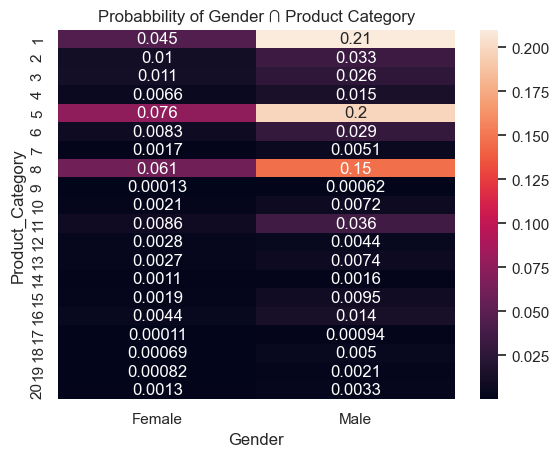

In [135]:
sns.heatmap(pd.crosstab(walmart_raw['Product_Category'], walmart_raw['Gender'], normalize='all'),annot=True)
plt.title('Probabbility of Gender ∩ Product Category', fontsize=12)

##### `Descriptive` Plot

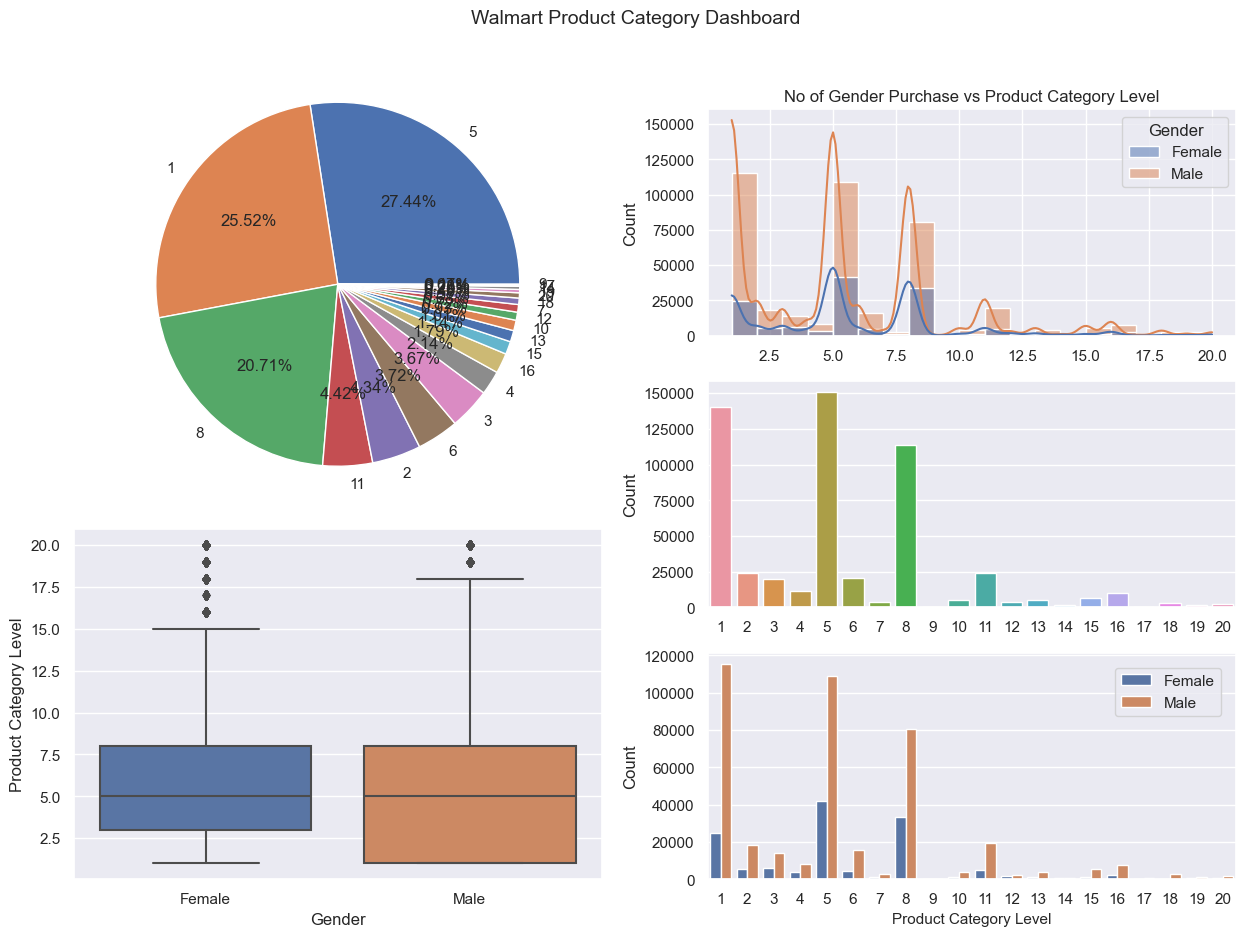

In [136]:
plt.figure(figsize=(15,10)).suptitle("Walmart Product Category Dashboard",fontsize=14)

plt.subplot(2, 2, 1)
plt.pie(walmart_raw['Product_Category'].value_counts().values,labels = walmart_raw['Product_Category'].value_counts().index,radius = 1.3,autopct = '%1.2f%%') # type: ignore

plt.subplot(2, 2, 3)
sns.boxplot(walmart_raw, y="Product_Category", x='Gender')
plt.ylabel('Product Category Level', fontsize=12)

plt.subplot(3, 2, 2)
sns.histplot(walmart_raw, x='Product_Category', binwidth=1, kde=True, hue="Gender")
plt.title('No of Gender Purchase vs Product Category Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)

plt.subplot(3, 2, 4)
sns.countplot(walmart_raw, x='Product_Category')
plt.ylabel('Count', fontsize=12)
plt.xlabel('', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)

plt.subplot(3, 2, 6)
sns.countplot(walmart_raw, x='Product_Category', hue='Gender')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Product Category Level', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)
plt.legend(borderaxespad=1, ncol=1)

plt.show()

##### `Probability` Plot

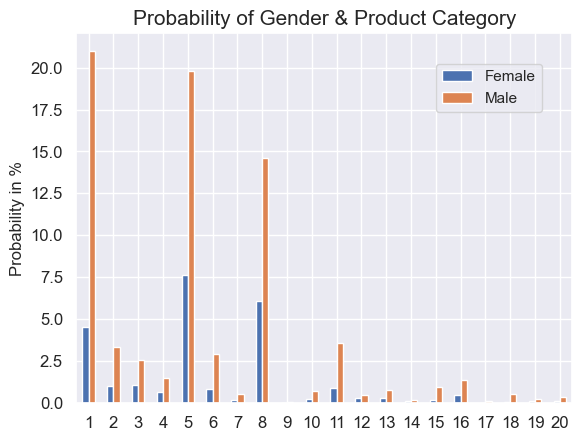

In [137]:
(pd.crosstab(walmart_raw['Product_Category'], walmart_raw['Gender'], normalize=True)*100).plot(kind='bar')
plt.title('Probability of Gender & Product Category', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(borderaxespad=2, ncol=1)
plt.show()

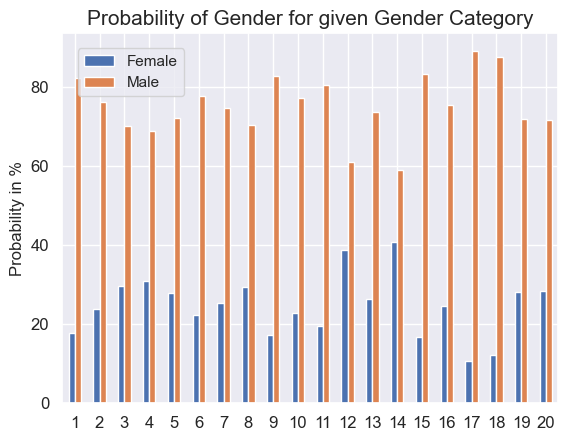

In [138]:
(pd.crosstab(walmart_raw['Product_Category'], walmart_raw['Gender'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of Gender for given Gender Category', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(borderaxespad=1, ncol=1)
plt.show()

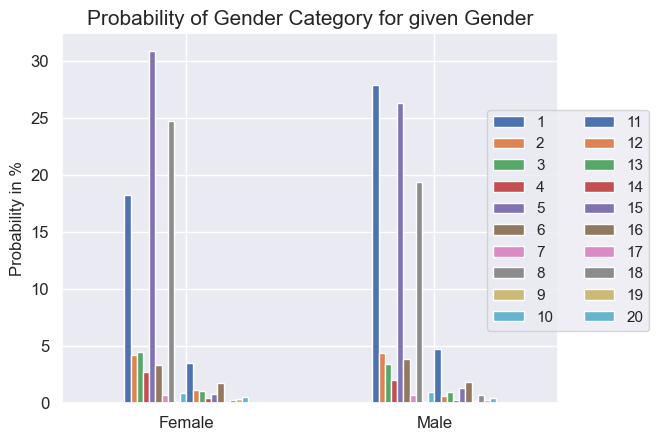

In [139]:
(pd.crosstab(walmart_raw['Gender'], walmart_raw['Product_Category'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of Gender Category for given Gender', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper center', borderaxespad=5, ncol=2)

plt.show()

##### `Population` Plot

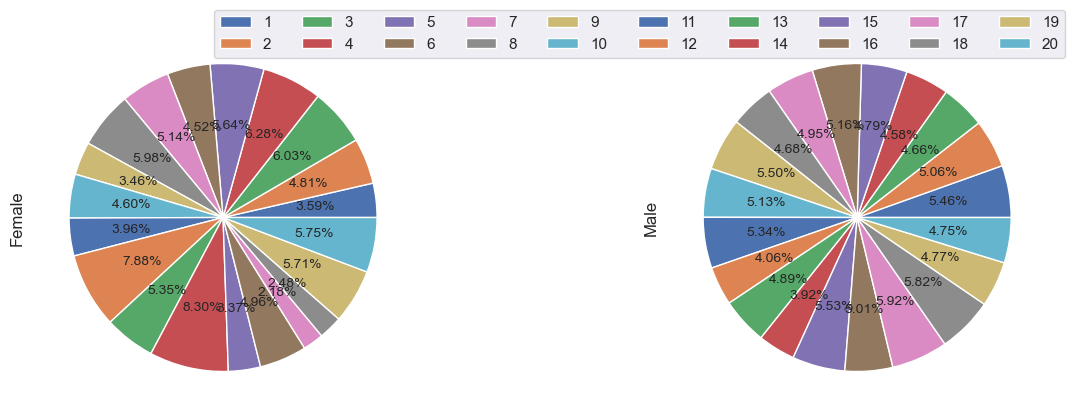

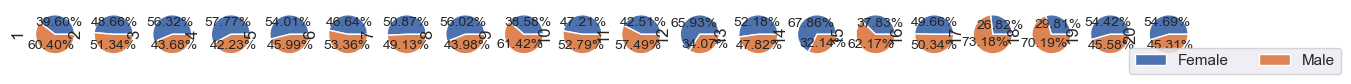

In [140]:
pd.crosstab(walmart_raw['Product_Category'], walmart_raw['Gender'], normalize="index").plot(kind='pie', subplots=True, figsize=(15,5), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=10)
plt.show()
pd.crosstab(walmart_raw['Gender'], walmart_raw['Product_Category'], normalize="index").plot(kind='pie', subplots=True, figsize=(15,5), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=3)
plt.show()

### **<span style="color: orange;">Purchase</span>**

In [141]:
walmart_raw['Purchase_group'].unique()

['7.5K-10K', '15K-17.5K', '1K-2.5K', '17.5K-20K', '5K-7.5K', ..., '501-1K', '20K-22.5K', '22.5K-25K', '101-500', '0-100']
Length: 13
Categories (13, object): ['0-100' < '101-500' < '501-1K' < '1K-2.5K' ... '15K-17.5K' < '17.5K-20K' < '20K-22.5K' < '22.5K-25K']

In [142]:
walmart_raw['Purchase_group'].value_counts()

5K-7.5K      133795
7.5K-10K     131900
15K-17.5K     66463
10K-12.5K     59974
2.5K-5K       58079
17.5K-20K     31369
1K-2.5K       25514
12.5K-15K     18953
20K-22.5K     10341
501-1K         7003
101-500        2724
22.5K-25K      2350
0-100          1603
Name: Purchase_group, dtype: int64

In [143]:
walmart_raw['Purchase_group'].value_counts(normalize=True)*100

5K-7.5K      24.323356
7.5K-10K     23.978854
15K-17.5K    12.082688
10K-12.5K    10.903016
2.5K-5K      10.558513
17.5K-20K     5.702749
1K-2.5K       4.638336
12.5K-15K     3.445574
20K-22.5K     1.879949
501-1K        1.273115
101-500       0.495212
22.5K-25K     0.427220
0-100         0.291419
Name: Purchase_group, dtype: float64

#### **<span style="color: #0099ff;">Statitical Analysis</span>**

##### Purchase as Number

In [144]:
walmart_raw['Purchase'].describe()

count    550068.000000
mean       9263.968713
std        5023.065394
min          12.000000
25%        5823.000000
50%        8047.000000
75%       12054.000000
max       23961.000000
Name: Purchase, dtype: float64

In [145]:
walmart_raw['Purchase'].mean()

9263.968712959126

In [146]:
walmart_raw['Purchase'].median()

8047.0

In [147]:
walmart_raw['Purchase'].mode()[0]

7011

In [148]:
walmart_raw.groupby('Gender')["Purchase"].describe()

count         mean          std   min     25%     50%      75%  \
Gender                                                                      
Female  135809.0  8734.565765  4767.233289  12.0  5433.0  7914.0  11400.0   
Male    414259.0  9437.526040  5092.186210  12.0  5863.0  8098.0  12454.0   

            max  
Gender           
Female  23959.0  
Male    23961.0

##### Purchase as Category

In [149]:
walmart_raw['Purchase_group'].describe()

count      550068
unique         13
top       5K-7.5K
freq       133795
Name: Purchase_group, dtype: object

In [150]:
walmart_raw['Purchase_group'].mode()[0]

'5K-7.5K'

In [151]:
walmart_raw.groupby('Gender')["Purchase_group"].describe()

count unique      top   freq
Gender                               
Female  135809     13  5K-7.5K  36785
Male    414259     13  5K-7.5K  97010

#### **<span style="color: #ff6600;">Check for Outliers</span>**

In [152]:
check_outlier(walmart_raw, 'Purchase')['upper']

{'list': 343       23603
 375       23792
 652       23233
 736       23595
 1041      23341
           ...  
 544488    23753
 544704    23724
 544743    23529
 545663    23663
 545787    23496
 Name: Purchase, Length: 2677, dtype: int64,
 'length': 2677}

In [153]:
check_outlier(walmart_raw, 'Purchase')['lower']

{'list': Series([], Name: Purchase, dtype: int64), 'length': 0}

#### **<span style="color: #818cf8;">Find Probability</span>**

##### Probability of a `Gender` & `Purchase` across all Combination ***"Gender ∩ Purchase"***

In [154]:
pd.crosstab(walmart_raw['Purchase_group'], walmart_raw['Gender'], normalize=True, margins=True)*100

Gender             Female       Male         All
Purchase_group                                  
0-100            0.081990   0.209429    0.291419
101-500          0.129439   0.365773    0.495212
501-1K           0.334322   0.938793    1.273115
1K-2.5K          1.315292   3.323044    4.638336
2.5K-5K          2.545503   8.013009   10.558513
5K-7.5K          6.687355  17.636001   24.323356
7.5K-10K         6.516285  17.462568   23.978854
10K-12.5K        2.294625   8.608390   10.903016
12.5K-15K        0.888981   2.556593    3.445574
15K-17.5K        2.340983   9.741705   12.082688
17.5K-20K        1.041689   4.661060    5.702749
20K-22.5K        0.415221   1.464728    1.879949
22.5K-25K        0.097806   0.329414    0.427220
All             24.689493  75.310507  100.000000

##### Probability of `Gender's` for given `Purchase`  ***"Gender | Purchase"***

In [155]:
pd.crosstab(walmart_raw['Purchase_group'], walmart_raw['Gender'], normalize='index', margins=True)*100

Gender             Female       Male
Purchase_group                      
0-100           28.134747  71.865253
101-500         26.138032  73.861968
501-1K          26.260174  73.739826
1K-2.5K         28.356980  71.643020
2.5K-5K         24.108542  75.891458
5K-7.5K         27.493554  72.506446
7.5K-10K        27.175133  72.824867
10K-12.5K       21.045787  78.954213
12.5K-15K       25.800665  74.199335
15K-17.5K       19.374690  80.625310
17.5K-20K       18.266441  81.733559
20K-22.5K       22.086839  77.913161
22.5K-25K       22.893617  77.106383
All             24.689493  75.310507

##### Probability of `Purchase` for given `Gender` ***"Purchase | Product"***

In [156]:
pd.crosstab(walmart_raw['Purchase_group'], walmart_raw['Gender'], normalize='columns', margins=True)*100

Gender             Female       Male        All
Purchase_group                                 
0-100            0.332084   0.278087   0.291419
101-500          0.524266   0.485686   0.495212
501-1K           1.354108   1.246563   1.273115
1K-2.5K          5.327335   4.412457   4.638336
2.5K-5K         10.310068  10.639962  10.558513
5K-7.5K         27.085834  23.417717  24.323356
7.5K-10K        26.392949  23.187426  23.978854
10K-12.5K        9.293935  11.430530  10.903016
12.5K-15K        3.600645   3.394736   3.445574
15K-17.5K        9.481699  12.935386  12.082688
17.5K-20K        4.219161   6.189123   5.702749
20K-22.5K        1.681774   1.944919   1.879949
22.5K-25K        0.396145   0.437408   0.427220

#### **<span style="color: #b05abc;">Plot the Graph</span>**

##### `Heat Map`

Text(0.5, 1.0, 'Probabbility of Gender ∩ Purchase')

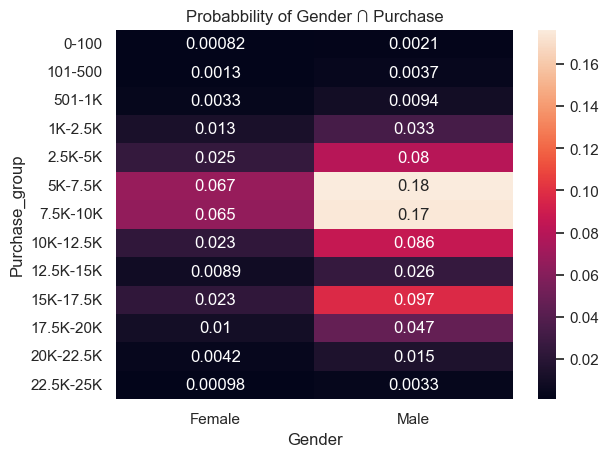

In [157]:
sns.heatmap(pd.crosstab(walmart_raw['Purchase_group'], walmart_raw['Gender'], normalize='all'),annot=True)
plt.title('Probabbility of Gender ∩ Purchase', fontsize=12)

##### `Descriptive` Plot

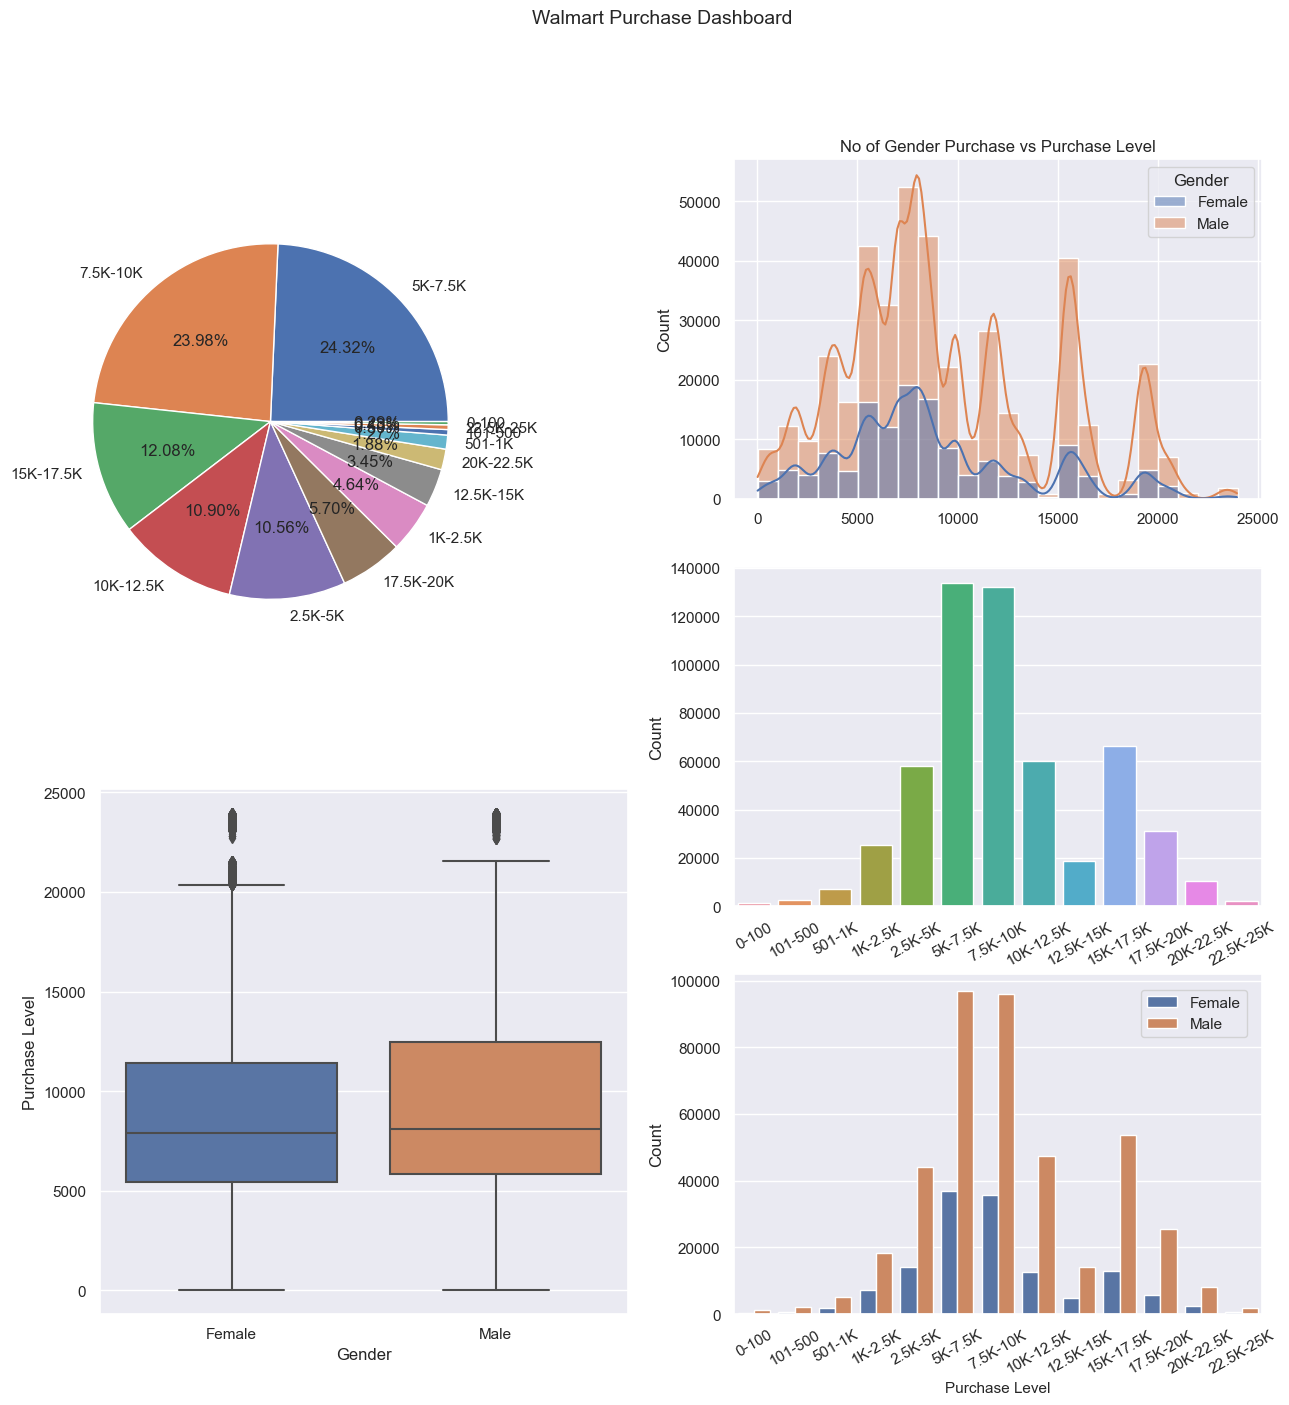

In [158]:
plt.figure(figsize=(15,15)).suptitle("Walmart Purchase Dashboard",fontsize=14)

plt.subplot(2, 3, 1)
plt.pie(walmart_raw['Purchase_group'].value_counts().values,labels = walmart_raw['Purchase_group'].value_counts().index,radius = 1.3,autopct = '%1.2f%%') # type: ignore

plt.subplot(2, 2, 3)
sns.boxplot(walmart_raw, y="Purchase", x='Gender')
plt.ylabel('Purchase Level', fontsize=12)

plt.subplot(3, 2, 2)
sns.histplot(walmart_raw, x='Purchase', binwidth=1000, kde=True, hue="Gender")
plt.title('No of Gender Purchase vs Purchase Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlabel('', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(rotation= 0, fontsize=11)

plt.subplot(3, 2, 4)
sns.countplot(walmart_raw, x='Purchase_group')
plt.ylabel('Count', fontsize=12)
plt.xlabel('', fontsize=11)
plt.xticks(rotation= 30, fontsize=11)
plt.yticks(fontsize=11)

plt.subplot(3, 2, 6)
sns.countplot(walmart_raw, x='Purchase_group', hue='Gender')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Purchase Level', fontsize=11)
plt.xticks(rotation= 30, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(borderaxespad=1, ncol=1)

plt.show()

##### `Probability` Plot

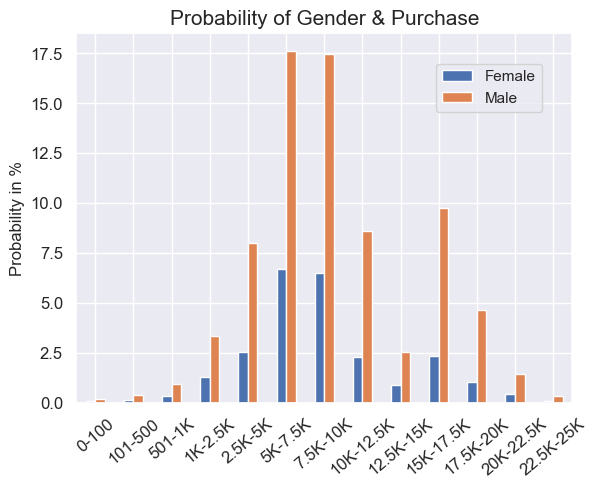

In [159]:
(pd.crosstab(walmart_raw['Purchase_group'], walmart_raw['Gender'], normalize=True)*100).plot(kind='bar')
plt.title('Probability of Gender & Purchase', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 40, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(borderaxespad=2, ncol=1)
plt.show()

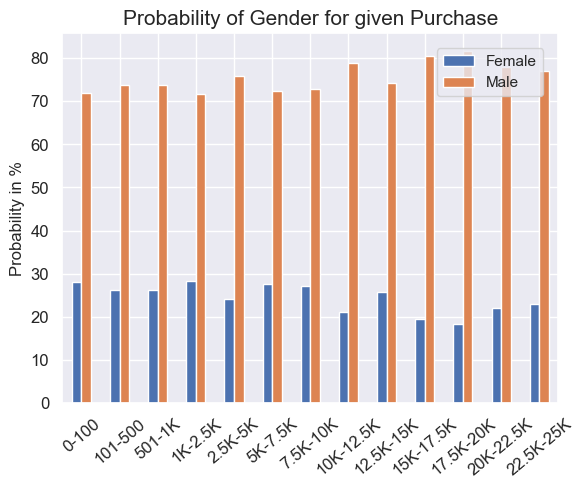

In [160]:
(pd.crosstab(walmart_raw['Purchase_group'], walmart_raw['Gender'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of Gender for given Purchase', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 40, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(borderaxespad=1, ncol=1)
plt.show()

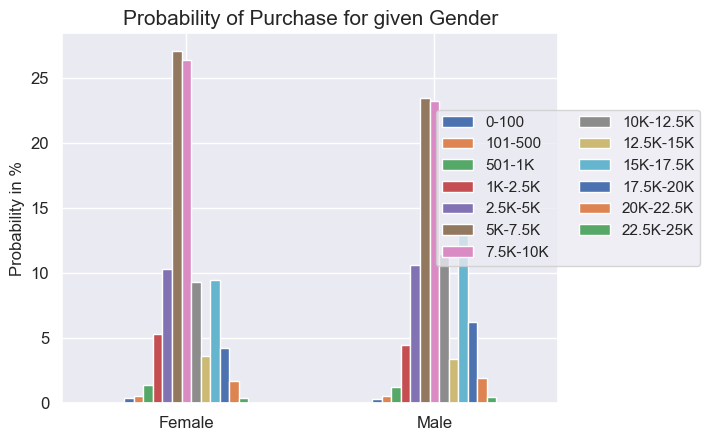

In [161]:
(pd.crosstab(walmart_raw['Gender'], walmart_raw['Purchase_group'], normalize="index")*100).plot(kind='bar')
plt.title('Probability of Purchase for given Gender', fontsize=15)
plt.ylabel('Probability in %', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation= 360, fontsize=12)
plt.yticks(rotation= 0, fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper center', borderaxespad=5, ncol=2)

plt.show()

##### `Population` Plot

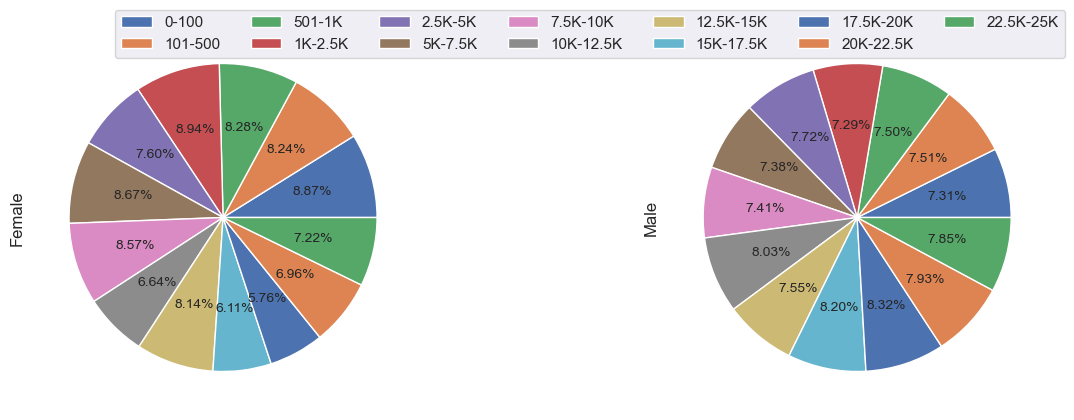

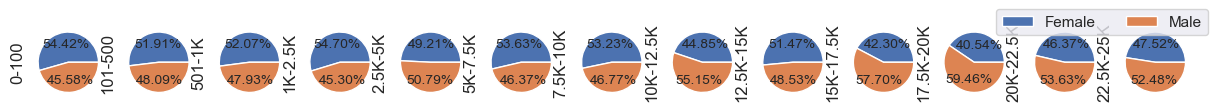

In [162]:
pd.crosstab(walmart_raw['Purchase_group'], walmart_raw['Gender'], normalize="index").plot(kind='pie', subplots=True, figsize=(15,5), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=7)
plt.show()
pd.crosstab(walmart_raw['Gender'], walmart_raw['Purchase_group'], normalize="index").plot(kind='pie', subplots=True, figsize=(15,5), labeldistance=None, fontsize=10, legend=None, autopct = '%1.2f%%')
plt.legend(borderaxespad=-1, ncol=3)
plt.show()

## **<span style="color: #4d88ff;">Customer Profile</span>**

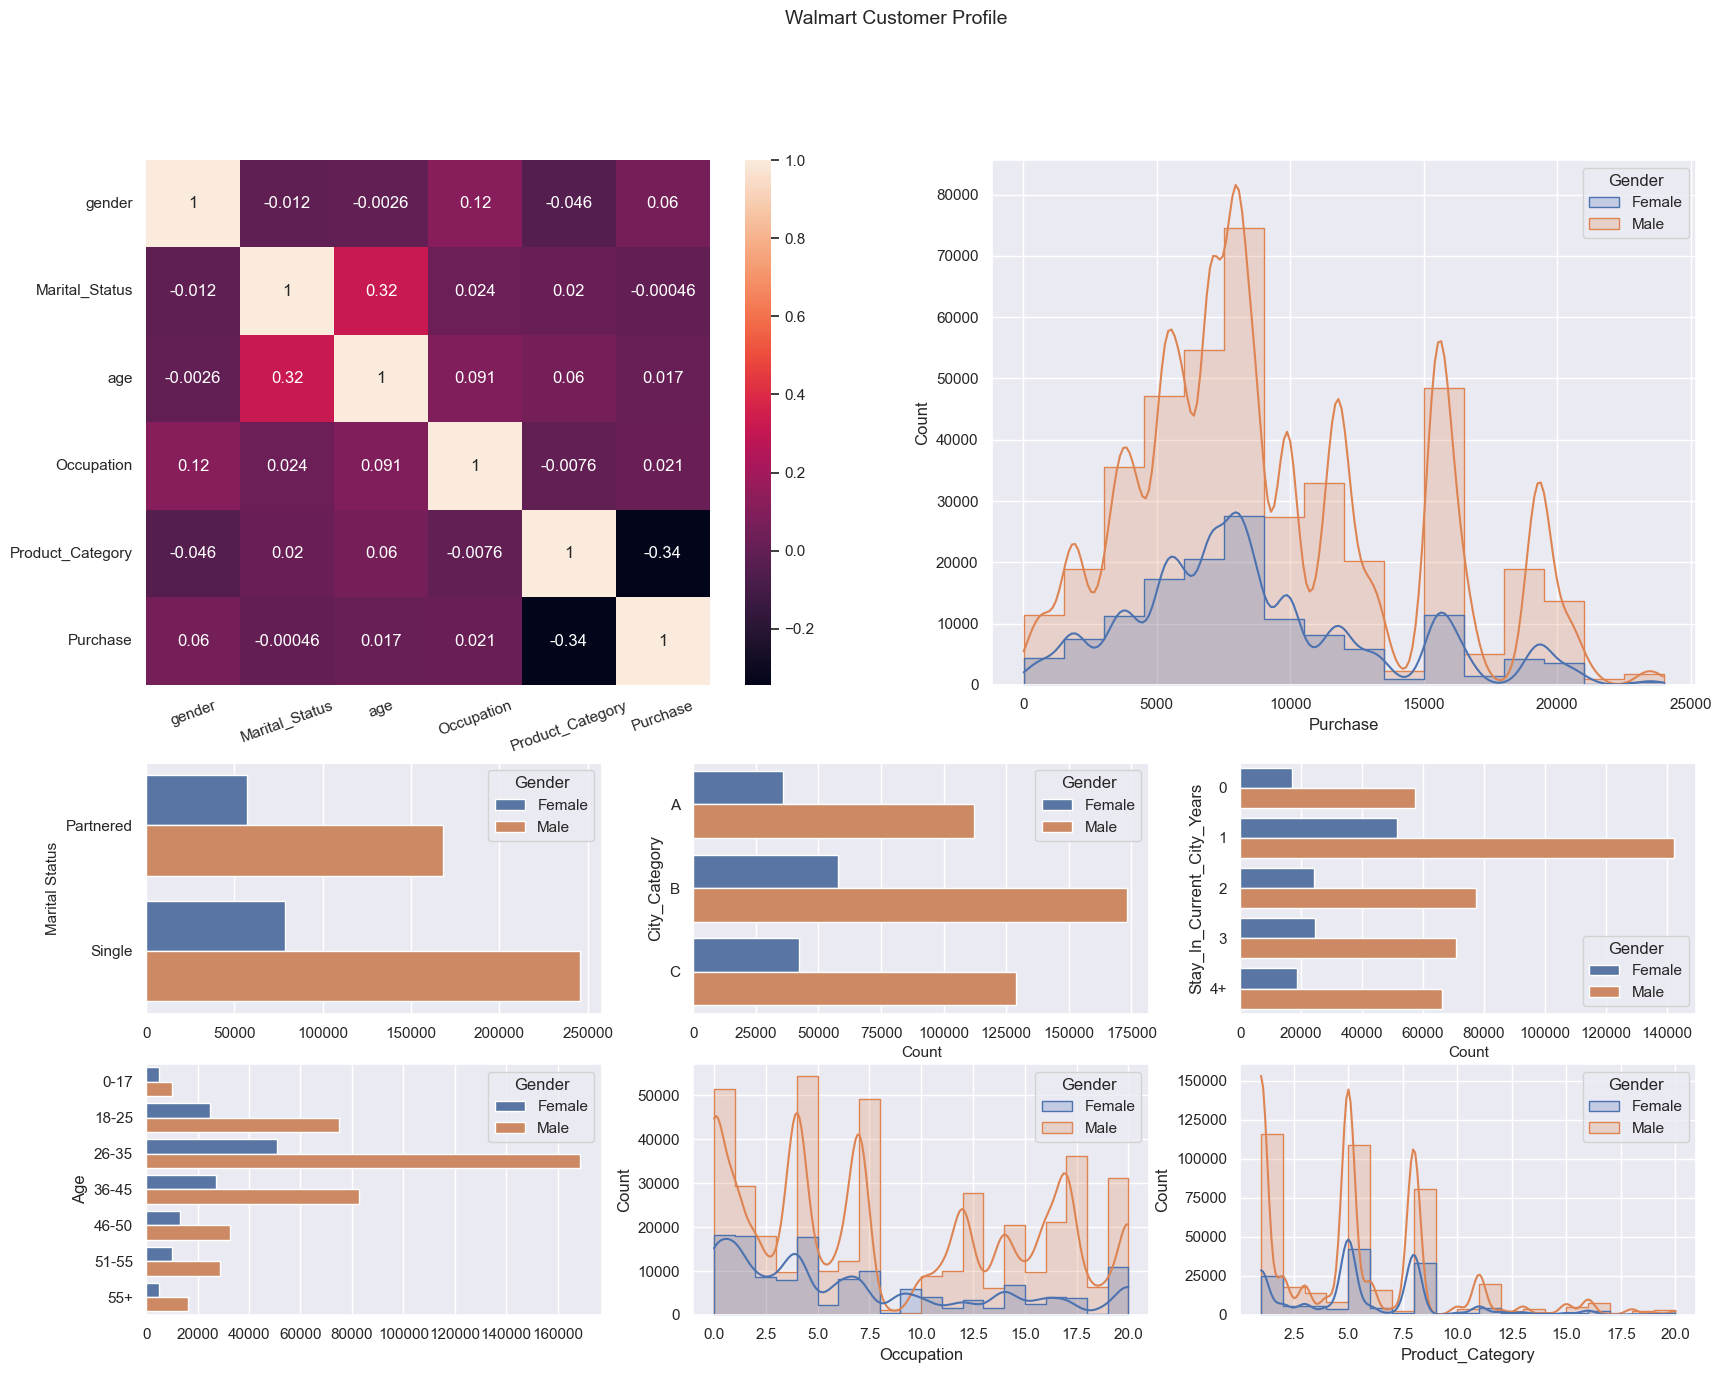

In [163]:
plt.figure(figsize=(20,15)).suptitle("Walmart Customer Profile",fontsize=14)

plt.subplot(2, 2, 1)
sns.heatmap(walmart_raw[['gender', 'Marital_Status', 'age', 'Occupation', 'Product_Category', 'Purchase']].corr(), annot=True)
plt.yticks(rotation= 0, fontsize=11)
plt.xticks(rotation= 20, fontsize=11)

plt.subplot(2, 2, 2)
sns.histplot(walmart_raw, x="Purchase", binwidth=1500, kde=True, hue="Gender", element="step")

plt.subplot(4, 3, 7)
sns.countplot(walmart_raw, y='marital_status', hue="Gender")
plt.xlabel("", fontsize=11)
plt.ylabel("Marital Status", fontsize=11)
plt.subplot(4, 3, 8)
sns.countplot(walmart_raw, y='City_Category', hue="Gender")
plt.xlabel("Count", fontsize=11)
plt.subplot(4, 3, 9)
sns.countplot(walmart_raw, y='Stay_In_Current_City_Years', hue="Gender")
plt.xlabel("Count", fontsize=11)

plt.subplot(4, 3, 10)
sns.countplot(walmart_raw, y='Age', hue="Gender")
plt.xlabel("", fontsize=11)
plt.subplot(4, 3, 11)
sns.histplot(walmart_raw, x="Occupation", binwidth=1, kde=True, hue="Gender", element="step")
plt.subplot(4, 3, 12)
sns.histplot(walmart_raw, x="Product_Category", binwidth=1, kde=True, hue="Gender", element="step")

plt.show()

### **<span style="color: orange;">Profile of *Male*</span>**

In [164]:
Male = walmart_raw.copy().loc[walmart_raw['Gender']=='Male']

In [165]:
Male.shape[0]

414259

In [166]:
Male.nunique()

User_ID                        4225
Gender                            1
gender                            1
Marital_Status                    2
marital_status                    2
Age                               7
age                               7
City_Category                     3
Stay_In_Current_City_Years        5
Occupation                       21
Product_ID                     3588
Product_Category                 20
Purchase                      17547
Purchase_group                   13
dtype: int64

#### **<span style="color: #0099ff;">Statitical Analysis</span>**

In [167]:
Male[['marital_status', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Product_ID', 'Purchase_group', 'User_ID']].describe()

marital_status     Age City_Category Stay_In_Current_City_Years  \
count          414259  414259        414259                     414259   
unique              2       7             3                          5   
top            Single   26-35             B                          1   
freq           245910  168835        173377                     142523   

       Product_ID Purchase_group  User_ID  
count      414259         414259   414259  
unique       3588             13     4225  
top     P00265242        5K-7.5K  1001680  
freq         1372          97010     1026

In [168]:
Male[['age', 'Occupation' , 'Product_Category', 'Purchase']].describe()

age    Occupation  Product_Category      Purchase
count  414259.000000  414259.00000     414259.000000  414259.00000
mean       34.235540       8.51475          5.301512    9437.52604
std        10.733197       6.55379          4.006275    5092.18621
min         8.500000       0.00000          1.000000      12.00000
25%        30.500000       3.00000          1.000000    5863.00000
50%        30.500000       7.00000          5.000000    8098.00000
75%        40.500000      15.00000          8.000000   12454.00000
max        55.000000      20.00000         20.000000   23961.00000

In [169]:
Male[['age', 'Purchase']].mean()

age           34.23554
Purchase    9437.52604
dtype: float64

In [170]:
Male[['age', 'Purchase']].median()

age           30.5
Purchase    8098.0
dtype: float64

#### **<span style="color: #818cf8;">Find Probability</span>**

In [171]:
pd.crosstab([Male.Purchase_group], [Male.Age], normalize=True, margins=True)*100

Age                 0-17      18-25      26-35      36-45     46-50     51-55  \
Purchase_group                                                                  
0-100           0.008207   0.048762   0.099937   0.054314  0.023898  0.024381   
101-500         0.013518   0.091006   0.181046   0.098489  0.038865  0.034278   
501-1K          0.035726   0.199392   0.480617   0.257327  0.114663  0.094385   
1K-2.5K         0.132767   0.831123   1.784150   0.858642  0.328297  0.294019   
2.5K-5K         0.293295   2.045097   4.602193   2.017096  0.780912  0.582727   
5K-7.5K         0.547725   4.134129   9.597377   4.801585  1.891329  1.564722   
7.5K-10K        0.528896   4.112162   9.171316   4.629471  1.922469  1.715111   
10K-12.5K       0.268190   2.102308   4.768997   2.266456  0.851400  0.763532   
12.5K-15K       0.084971   0.618936   1.323327   0.699804  0.287743  0.254913   
15K-17.5K       0.288708   2.319563   5.284617   2.638446  0.980787  0.930577   
17.5K-20K       0.160769   1.203595   2.507851   1.203112  0.439097  0.447546   
20K-22.5K       0.046589   0.352919   0.800224   0.371265  0.146044  0.149423   
22.5K-25K       0.009173   0.053348   0.154251   0.101869  0.040313  0.049969   
All             2.418535  18.112340  40.755904  19.997876  7.845816  6.905583   

Age                  55+         All  
Purchase_group                        
0-100           0.018587    0.278087  
101-500         0.028485    0.485686  
501-1K          0.064452    1.246563  
1K-2.5K         0.183460    4.412457  
2.5K-5K         0.318641   10.639962  
5K-7.5K         0.880850   23.417717  
7.5K-10K        1.108002   23.187426  
10K-12.5K       0.409647   11.430530  
12.5K-15K       0.125043    3.394736  
15K-17.5K       0.492687   12.935386  
17.5K-20K       0.227153    6.189123  
20K-22.5K       0.078453    1.944919  
22.5K-25K       0.028485    0.437408  
All             3.963945  100.000000

In [172]:
pd.crosstab([Male.marital_status, Male.City_Category], [Male.Purchase_group], normalize=True, margins=True)*100

Purchase_group                   0-100   101-500    501-1K   1K-2.5K  \
marital_status City_Category                                           
Partnered      A              0.018346  0.043451  0.131802  0.535172   
               B              0.029450  0.064935  0.219911  0.799983   
               C              0.064935  0.091006  0.180081  0.477720   
Single         A              0.028002  0.069763  0.215807  0.842227   
               B              0.049003  0.093420  0.294985  1.051275   
               C              0.088351  0.123111  0.203979  0.706080   
All                           0.278087  0.485686  1.246563  4.412457   

Purchase_group                  2.5K-5K    5K-7.5K   7.5K-10K  10K-12.5K  \
marital_status City_Category                                               
Partnered      A               1.235218   2.622997   2.397534   1.205043   
               B               1.852464   4.074504   4.026467   1.980162   
               C               1.145177   2.808147   3.157928   1.470819   
Single         A               2.039787   4.034674   3.918563   1.822290   
               B               2.715210   5.988041   5.559324   2.888531   
               C               1.652107   3.889354   4.127611   2.063685   
All                           10.639962  23.417717  23.187426  11.430530   

Purchase_group                12.5K-15K  15K-17.5K  17.5K-20K  20K-22.5K  \
marital_status City_Category                                               
Partnered      A               0.351712   1.089898   0.456478   0.172115   
               B               0.589728   2.191865   0.955924   0.324193   
               C               0.463237   1.894708   1.042102   0.284605   
Single         A               0.536621   1.970265   0.862262   0.329504   
               B               0.850193   3.217794   1.403953   0.456961   
               C               0.603246   2.570855   1.468405   0.377542   
All                            3.394736  12.935386   6.189123   1.944919   

Purchase_group                22.5K-25K         All  
marital_status City_Category                         
Partnered      A               0.040554   10.300319  
               B               0.073625   17.183211  
               C               0.074591   13.155055  
Single         A               0.070005   16.739769  
               B               0.100420   24.669108  
               C               0.078212   17.952537  
All                            0.437408  100.000000

In [173]:
pd.crosstab([Male.marital_status, Male.Stay_In_Current_City_Years], [Male.Purchase_group], normalize=True, margins=True)*100

Purchase_group                                0-100   101-500    501-1K  \
marital_status Stay_In_Current_City_Years                                 
Partnered      0                           0.012070  0.022691  0.070246   
               1                           0.043692  0.077971  0.188047   
               2                           0.023415  0.038382  0.098248   
               3                           0.017622  0.029450  0.080384   
               4+                          0.015932  0.030899  0.094868   
Single         0                           0.021243  0.041761  0.108869   
               1                           0.060832  0.095592  0.244292   
               2                           0.028002  0.054797  0.138078   
               3                           0.024864  0.049486  0.125767   
               4+                          0.030416  0.044658  0.097765   
All                                        0.278087  0.485686  1.246563   

Purchase_group                              1K-2.5K    2.5K-5K    5K-7.5K  \
marital_status Stay_In_Current_City_Years                                   
Partnered      0                           0.220152   0.541207   1.305705   
               1                           0.663595   1.577757   3.394978   
               2                           0.351954   0.746876   1.741423   
               3                           0.312124   0.713322   1.528271   
               4+                          0.265052   0.653697   1.535271   
Single         0                           0.401681   0.899196   2.012750   
               1                           0.853814   2.177623   4.593020   
               2                           0.470720   1.200215   2.616479   
               3                           0.417855   1.087725   2.487816   
               4+                          0.455512   1.042343   2.202004   
All                                        4.412457  10.639962  23.417717   

Purchase_group                              7.5K-10K  10K-12.5K  12.5K-15K  \
marital_status Stay_In_Current_City_Years                                    
Partnered      0                            1.229665   0.601315   0.174528   
               1                            3.478017   1.685178   0.518516   
               2                            1.757355   0.841261   0.255879   
               3                            1.533823   0.769808   0.227635   
               4+                           1.583068   0.758463   0.228118   
Single         0                            2.042683   0.995512   0.295709   
               1                            4.456149   2.279009   0.639938   
               2                            2.529577   1.273117   0.405302   
               3                            2.405500   1.168351   0.356299   
               4+                           2.171588   1.058517   0.292812   
All                                        23.187426  11.430530   3.394736   

Purchase_group                             15K-17.5K  17.5K-20K  20K-22.5K  \
marital_status Stay_In_Current_City_Years                                    
Partnered      0                            0.641386   0.278087   0.097282   
               1                            1.832429   0.903782   0.299330   
               2                            1.024238   0.488342   0.146044   
               3                            0.849710   0.394198   0.108869   
               4+                           0.828709   0.390094   0.129388   
Single         0                            1.084104   0.500653   0.182012   
               1                            2.573269   1.235218   0.376817   
               2                            1.468164   0.737703   0.196737   
               3                            1.415781   0.694493   0.207600   
               4+                           1.217596   0.566554   0.200841   
All                                        12.935386   6.189123   1.944

In [174]:
pd.crosstab([Male.marital_status, Male.City_Category], [Male.Age], normalize=True, margins=True)*100

Age                               0-17      18-25      26-35      36-45  \
marital_status City_Category                                              
Partnered      A              0.000000   1.016514   4.797482   2.289872   
               B              0.000000   1.561342   6.755677   3.140547   
               C              0.000000   1.005651   4.286449   2.563372   
Single         A              0.264810   4.116990   8.781946   2.420225   
               B              0.934198   6.057322  10.177449   5.667469   
               C              1.219527   4.354522   5.956901   3.916390   
All                           2.418535  18.112340  40.755904  19.997876   

Age                              46-50     51-55       55+         All  
marital_status City_Category                                            
Partnered      A              1.010720  0.728047  0.457685   10.300319  
               B              2.566269  2.541647  0.617729   17.183211  
               C              1.969782  1.883604  1.446197   13.155055  
Single         A              0.523827  0.315020  0.316951   16.739769  
               B              0.813742  0.716701  0.302226   24.669108  
               C              0.961476  0.720564  0.823157   17.952537  
All                           7.845816  6.905583  3.963945  100.000000

In [175]:
pd.crosstab([Male.marital_status, Male.Stay_In_Current_City_Years], [Male.Age], normalize=True, margins=True)*100

Age                                            0-17      18-25      26-35  \
marital_status Stay_In_Current_City_Years                                   
Partnered      0                           0.000000   0.476031   2.210694   
               1                           0.000000   1.416988   5.554737   
               2                           0.000000   0.653939   3.064749   
               3                           0.000000   0.499687   2.639653   
               4+                          0.000000   0.536862   2.369773   
Single         0                           0.365713   2.447985   3.220208   
               1                           0.804328   4.608952   8.120282   
               2                           0.531793   2.631446   4.902489   
               3                           0.383576   2.203935   4.720477   
               4+                          0.333125   2.636515   3.952841   
All                                        2.418535  18.112340  40.755904   

Age                                            36-45     46-50     51-55  \
marital_status Stay_In_Current_City_Years                                  
Partnered      0                            0.943130  0.698114  0.610246   
               1                            2.524266  2.126930  2.349255   
               2                            1.493269  1.140591  0.719840   
               3                            1.684453  0.675906  0.674457   
               4+                           1.348673  0.905231  0.799500   
Single         0                            1.693385  0.381404  0.213152   
               1                            4.189891  0.773912  0.669388   
               2                            2.275388  0.244533  0.372714   
               3                            2.447744  0.305606  0.140733   
               4+                           1.397676  0.593590  0.356299   
All                                        19.997876  7.845816  6.905583   

Age                                             55+         All  
marital_status Stay_In_Current_City_Years                        
Partnered      0                           0.280018    5.218233  
               1                           0.763773   14.735950  
               2                           0.477720    7.550108  
               3                           0.415923    6.590080  
               4+                          0.584176    6.544215  
Single         0                           0.300295    8.622142  
               1                           0.501619   19.668372  
               2                           0.201082   11.159444  
               3                           0.290157   10.492228  
               4+                          0.149182    9.419228  
All                                        3.963945  100.000000

In [176]:
pd.crosstab([Male.Age], [Male.Purchase_group], normalize=True, margins=True)*100

Purchase_group     0-100   101-500    501-1K   1K-2.5K    2.5K-5K    5K-7.5K  \
Age                                                                            
0-17            0.008207  0.013518  0.035726  0.132767   0.293295   0.547725   
18-25           0.048762  0.091006  0.199392  0.831123   2.045097   4.134129   
26-35           0.099937  0.181046  0.480617  1.784150   4.602193   9.597377   
36-45           0.054314  0.098489  0.257327  0.858642   2.017096   4.801585   
46-50           0.023898  0.038865  0.114663  0.328297   0.780912   1.891329   
51-55           0.024381  0.034278  0.094385  0.294019   0.582727   1.564722   
55+             0.018587  0.028485  0.064452  0.183460   0.318641   0.880850   
All             0.278087  0.485686  1.246563  4.412457  10.639962  23.417717   

Purchase_group   7.5K-10K  10K-12.5K  12.5K-15K  15K-17.5K  17.5K-20K  \
Age                                                                     
0-17             0.528896   0.268190   0.084971   0.288708   0.160769   
18-25            4.112162   2.102308   0.618936   2.319563   1.203595   
26-35            9.171316   4.768997   1.323327   5.284617   2.507851   
36-45            4.629471   2.266456   0.699804   2.638446   1.203112   
46-50            1.922469   0.851400   0.287743   0.980787   0.439097   
51-55            1.715111   0.763532   0.254913   0.930577   0.447546   
55+              1.108002   0.409647   0.125043   0.492687   0.227153   
All             23.187426  11.430530   3.394736  12.935386   6.189123   

Purchase_group  20K-22.5K  22.5K-25K         All  
Age                                               
0-17             0.046589   0.009173    2.418535  
18-25            0.352919   0.053348   18.112340  
26-35            0.800224   0.154251   40.755904  
36-45            0.371265   0.101869   19.997876  
46-50            0.146044   0.040313    7.845816  
51-55            0.149423   0.049969    6.905583  
55+              0.078453   0.028485    3.963945  
All              1.944919   0.437408  100.000000

In [177]:
pd.crosstab([Male.Occupation], [Male.Purchase_group], normalize=True, margins=True)*100

Purchase_group     0-100   101-500    501-1K   1K-2.5K    2.5K-5K    5K-7.5K  \
Occupation                                                                     
0               0.029450  0.053831  0.149665  0.593590   1.480233   2.953949   
1               0.021967  0.033312  0.099455  0.319365   0.726840   1.697247   
2               0.010863  0.019312  0.051417  0.204944   0.507895   1.061896   
3               0.005069  0.010380  0.033312  0.095351   0.230532   0.623523   
4               0.030416  0.064211  0.142906  0.606625   1.511856   2.956604   
5               0.004587  0.007483  0.024139  0.107421   0.266259   0.579589   
6               0.008932  0.018346  0.037175  0.147492   0.277604   0.707287   
7               0.034761  0.059383  0.140250  0.539035   1.240287   2.765661   
8               0.000724  0.001448  0.001690  0.012794   0.023657   0.070005   
9               0.000483  0.000000  0.001207  0.002655   0.010863   0.028726   
10              0.007966  0.011346  0.032830  0.115870   0.257086   0.471686   
11              0.007242  0.014725  0.033554  0.135664   0.260224   0.579106   
12              0.023898  0.035002  0.085454  0.210496   0.620385   1.517891   
13              0.005793  0.010139  0.026312  0.049727   0.123594   0.351471   
14              0.016173  0.025105  0.064935  0.188047   0.504998   1.071069   
15              0.007000  0.012311  0.024622  0.076764   0.210979   0.531552   
16              0.013277  0.021001  0.061797  0.207117   0.491239   1.274082   
17              0.030899  0.042968  0.119008  0.329987   0.802155   1.902916   
18              0.005793  0.005311  0.021001  0.064935   0.190943   0.399991   
19              0.002173  0.010139  0.024622  0.101386   0.198909   0.385508   
20              0.010621  0.029933  0.071211  0.303192   0.703425   1.487958   
All             0.278087  0.485686  1.246563  4.412457  10.639962  23.417717   

Purchase_group   7.5K-10K  10K-12.5K  12.5K-15K  15K-17.5K  17.5K-20K  \
Occupation                                                              
0                2.779421   1.466715   0.412785   1.549272   0.709942   
1                1.811669   0.782844   0.231015   0.857435   0.361127   
2                1.024963   0.448029   0.138319   0.495584   0.249844   
3                0.556174   0.245740   0.077246   0.274466   0.137595   
4                3.063060   1.486992   0.441511   1.657659   0.870711   
5                0.499687   0.319607   0.084971   0.304158   0.165597   
6                0.732392   0.298123   0.096317   0.350023   0.186840   
7                2.706037   1.323327   0.378990   1.630622   0.768360   
8                0.063245   0.040072   0.011104   0.041761   0.016173   
9                0.026553   0.011587   0.004828   0.016173   0.003862   
10               0.473617   0.247913   0.079178   0.264086   0.149182   
11               0.591659   0.234877   0.082316   0.287743   0.139043   
12               1.529478   0.798776   0.244774   0.961959   0.491721   
13               0.423648   0.152320   0.047555   0.184667   0.086902   
14               1.133108   0.592866   0.160045   0.719598   0.342298   
15               0.579348   0.267466   0.076764   0.338436   0.173804   
16               1.198526   0.580555   0.172839   0.708011   0.288467   
17               1.871776   1.171007   0.345195   1.295808   0.623040   
18               0.301985   0.196978   0.052624   0.194806   0.078695   
19               0.342298   0.169701   0.043692   0.161735   0.075557   
20               1.478785   0.595038   0.212669   0.641386   0.270362   
All             23.187426  11.430530   3.394736  12.935386   6.189123   

Purchase_group  20K-22.5K  22.5K-25K         All  
Occupation                                        
0                0.214117   0.045141   12.438112  
1                0.129629   0.035244    7.107148  
2                0.096558   0.025588    4.335211  
3                0.049727   0.009897    2.349014  
4                0.2

#### **<span style="color: #ff6600;">Check for Outliers</span>**

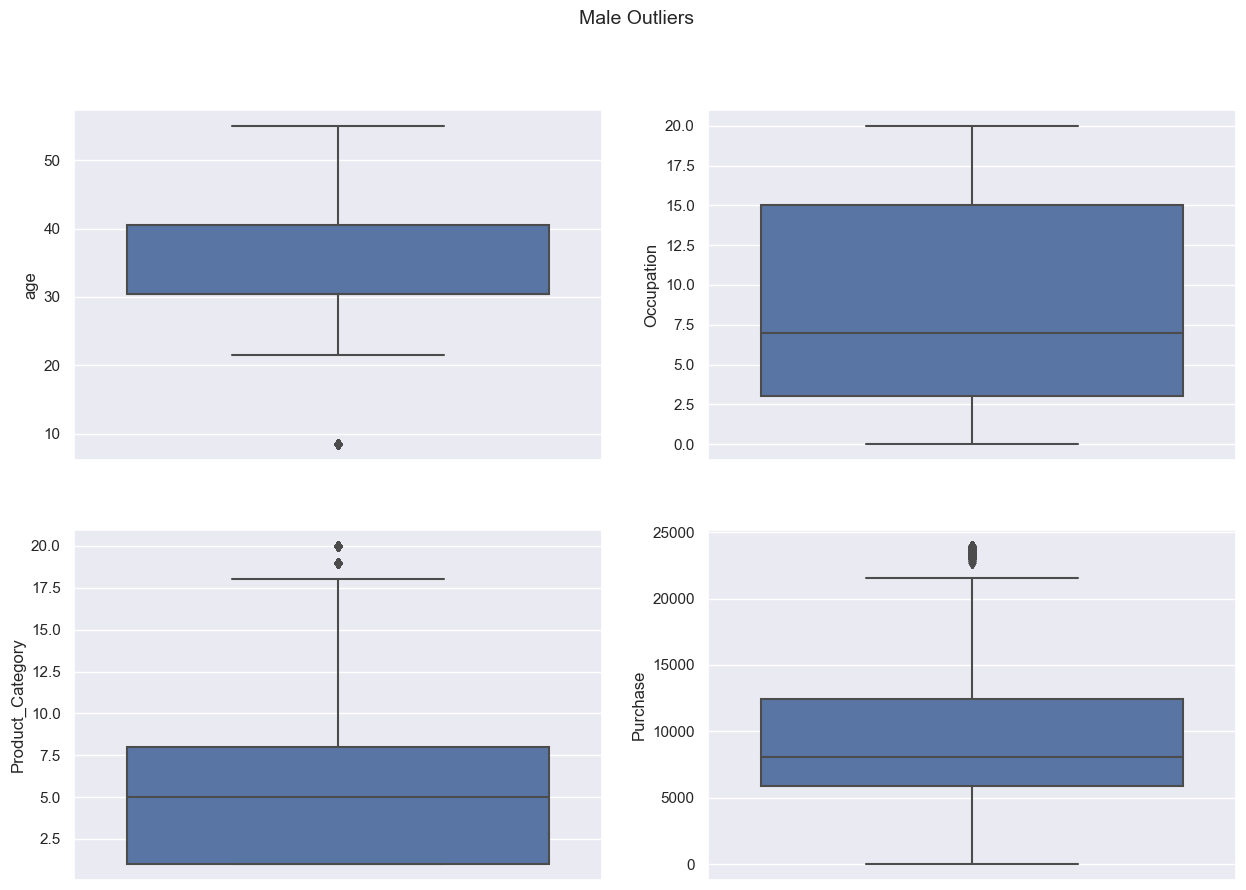

In [178]:
plt.figure(figsize=(15,10)).suptitle("Male Outliers",fontsize=14)

plt.subplot(2, 2, 1)
sns.boxplot(Male, y='age')
plt.subplot(2, 2, 2)
sns.boxplot(Male, y='Occupation')

plt.subplot(2, 2, 3)
sns.boxplot(Male, y="Product_Category")
plt.subplot(2, 2, 4)
sns.boxplot(Male, y="Purchase")

plt.show()

#### **<span style="color: #b05abc;">Plot the Graph</span>**

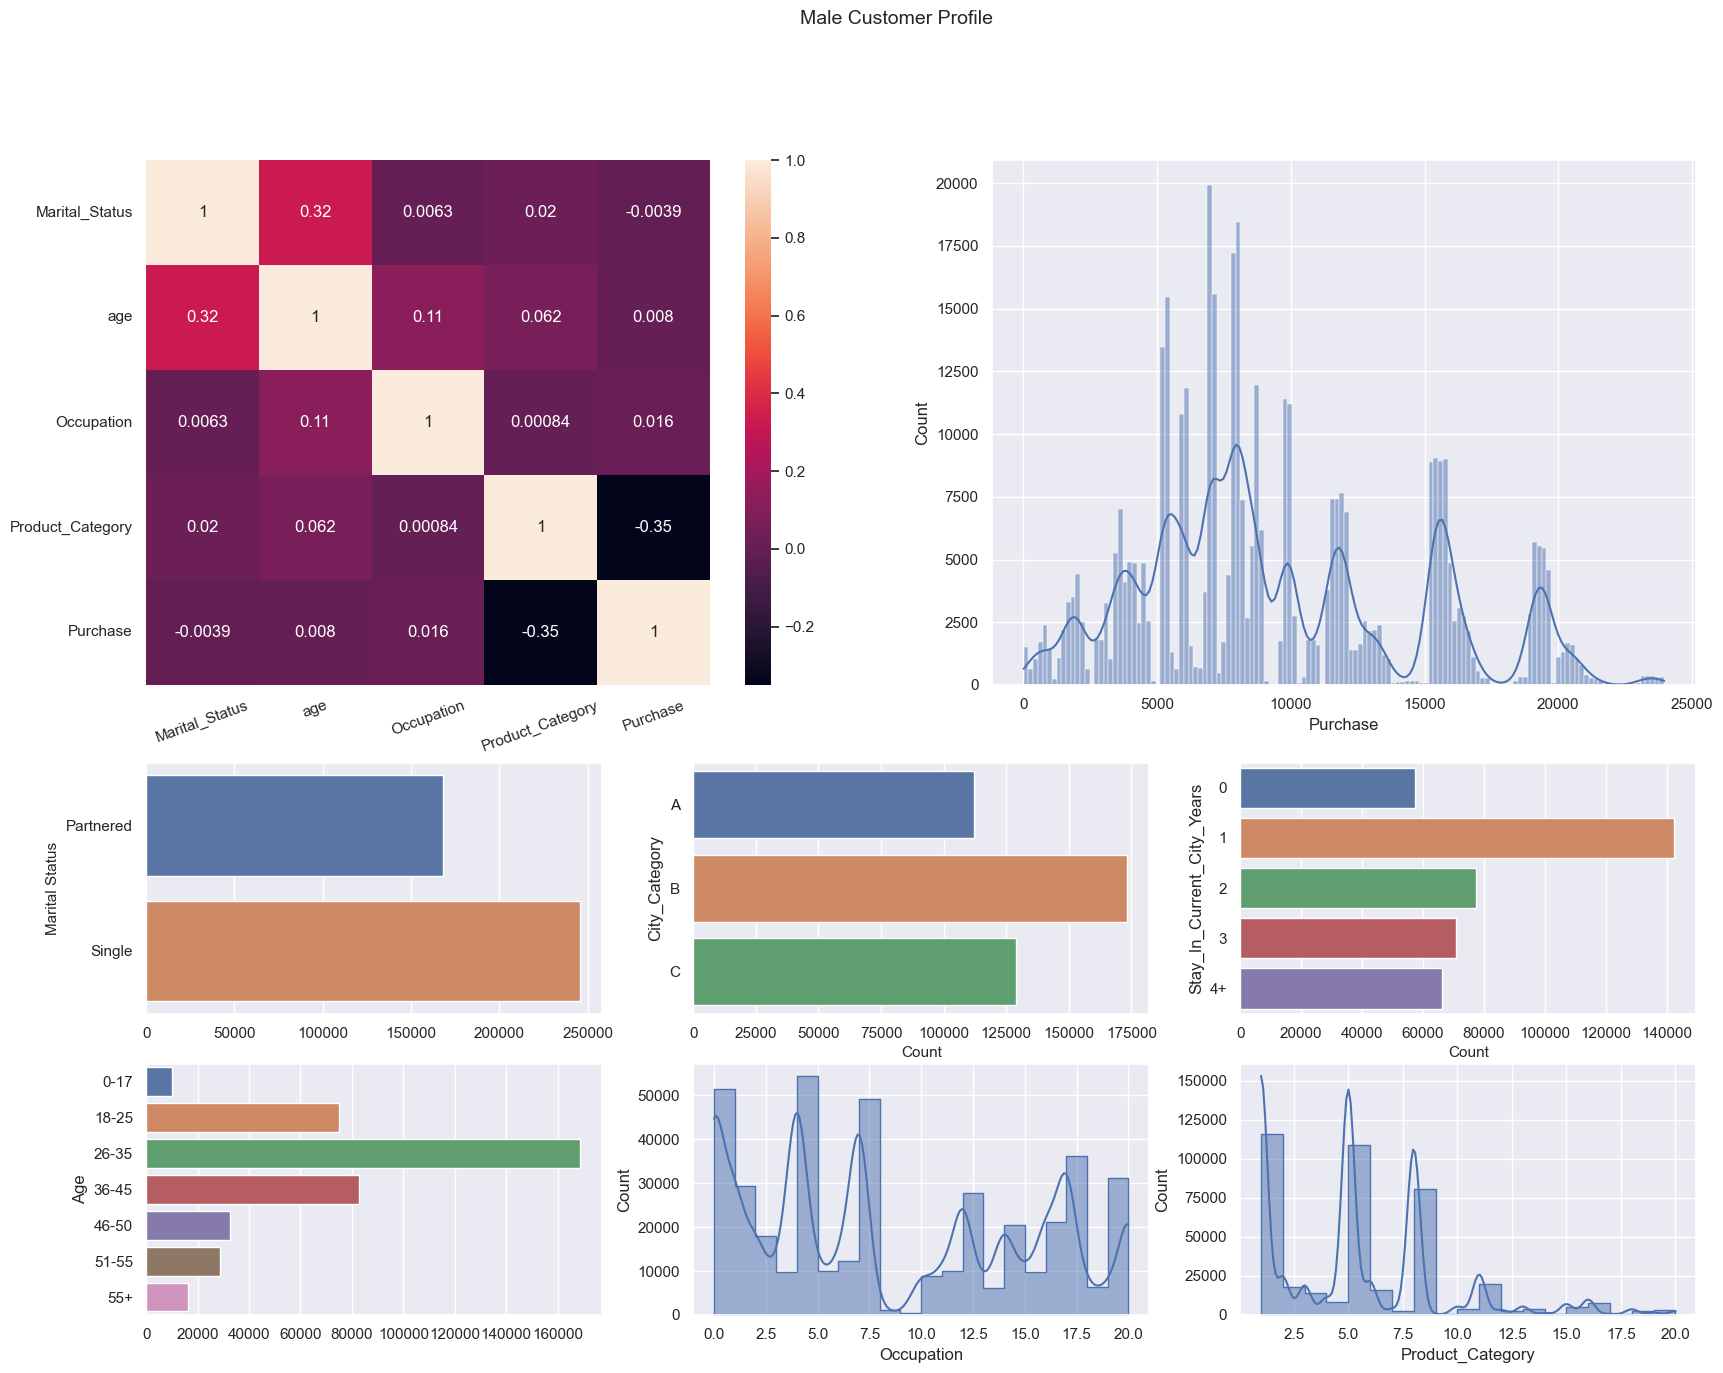

In [179]:
plt.figure(figsize=(20,15)).suptitle("Male Customer Profile",fontsize=14)

plt.subplot(2, 2, 1)
sns.heatmap(Male[['Marital_Status', 'age', 'Occupation', 'Product_Category', 'Purchase']].corr(), annot=True)
plt.yticks(rotation= 0, fontsize=11)
plt.xticks(rotation= 20, fontsize=11)

plt.subplot(2, 2, 2)
sns.histplot(Male, x="Purchase", kde=True)

plt.subplot(4, 3, 7)
sns.countplot(Male, y='marital_status')
plt.xlabel("", fontsize=11)
plt.ylabel("Marital Status", fontsize=11)
plt.subplot(4, 3, 8)
sns.countplot(Male, y='City_Category')
plt.xlabel("Count", fontsize=11)
plt.subplot(4, 3, 9)
sns.countplot(Male, y='Stay_In_Current_City_Years')
plt.xlabel("Count", fontsize=11)

plt.subplot(4, 3, 10)
sns.countplot(Male, y='Age')
plt.xlabel("", fontsize=11)
plt.subplot(4, 3, 11)
sns.histplot(Male, x="Occupation", binwidth=1, kde=True, element="step")
plt.subplot(4, 3, 12)
sns.histplot(Male, x="Product_Category", binwidth=1, kde=True, element="step")

plt.show()

### **<span style="color: orange;">Profile of *Female*</span>**

In [180]:
Female = walmart_raw.copy().loc[walmart_raw['Gender']=='Female']

In [181]:
Female.shape[0]

135809

In [182]:
Female.nunique()

User_ID                        1666
Gender                            1
gender                            1
Marital_Status                    2
marital_status                    2
Age                               7
age                               7
City_Category                     3
Stay_In_Current_City_Years        5
Occupation                       21
Product_ID                     3367
Product_Category                 20
Purchase                      14704
Purchase_group                   13
dtype: int64

#### **<span style="color: #0099ff;">Statitical Analysis</span>**

In [183]:
Female[['marital_status', 'Age', 'City_Category', 'Stay_In_Current_City_Years', 'Product_ID', 'Purchase_group', 'User_ID']].describe()

marital_status     Age City_Category Stay_In_Current_City_Years  \
count          135809  135809        135809                     135809   
unique              2       7             3                          5   
top            Single   26-35             B                          1   
freq            78821   50752         57796                      51298   

       Product_ID Purchase_group  User_ID  
count      135809         135809   135809  
unique       3367             13     1666  
top     P00265242        5K-7.5K  1001150  
freq          508          36785      752

In [184]:
Female[['age', 'Occupation' , 'Product_Category', 'Purchase']].describe()

age     Occupation  Product_Category       Purchase
count  135809.000000  135809.000000     135809.000000  135809.000000
mean       34.302053       6.740540          5.717714    8734.565765
std        11.290097       6.239639          3.696752    4767.233289
min         8.500000       0.000000          1.000000      12.000000
25%        30.500000       1.000000          3.000000    5433.000000
50%        30.500000       4.000000          5.000000    7914.000000
75%        40.500000      11.000000          8.000000   11400.000000
max        55.000000      20.000000         20.000000   23959.000000

In [185]:
Female[['age', 'Purchase']].mean()

age           34.302053
Purchase    8734.565765
dtype: float64

In [186]:
Female[['age', 'Purchase']].median()

age           30.5
Purchase    7914.0
dtype: float64

#### **<span style="color: #818cf8;">Find Probability</span>**

In [187]:
pd.crosstab([Female.Purchase_group], [Female.Age], normalize=True, margins=True)*100

Age                 0-17      18-25      26-35      36-45     46-50     51-55  \
Purchase_group                                                                  
0-100           0.018408   0.053752   0.109713   0.069951  0.036816  0.024299   
101-500         0.022090   0.090568   0.179664   0.114131  0.047125  0.039762   
501-1K          0.057434   0.259188   0.418234   0.290113  0.143584  0.123703   
1K-2.5K         0.338711   1.172235   1.855547   0.949127  0.497758  0.325457   
2.5K-5K         0.428543   2.334160   3.874559   1.942434  0.969008  0.519848   
5K-7.5K         0.920410   5.012923  10.664242   5.149143  2.491735  1.983668   
7.5K-10K        0.892430   4.263340   9.743095   5.327335  2.673608  2.189104   
10K-12.5K       0.360801   1.753934   3.390791   1.939489  0.913047  0.606734   
12.5K-15K       0.204699   0.663432   1.203160   0.815852  0.340184  0.259924   
15K-17.5K       0.280541   1.564697   3.610954   2.069082  0.993307  0.645024   
17.5K-20K       0.161992   0.699512   1.553653   0.899057  0.413080  0.341656   
20K-22.5K       0.043443   0.236361   0.636188   0.349020  0.157574  0.173773   
22.5K-25K       0.013254   0.030189   0.130330   0.091305  0.041971  0.052279   
All             3.742756  18.134292  37.370130  20.006038  9.718796  7.285231   

Age                  55+         All  
Purchase_group                        
0-100           0.019145    0.332084  
101-500         0.030926    0.524266  
501-1K          0.061852    1.354108  
1K-2.5K         0.188500    5.327335  
2.5K-5K         0.241516   10.310068  
5K-7.5K         0.863713   27.085834  
7.5K-10K        1.304037   26.392949  
10K-12.5K       0.329139    9.293935  
12.5K-15K       0.113395    3.600645  
15K-17.5K       0.318094    9.481699  
17.5K-20K       0.150211    4.219161  
20K-22.5K       0.085414    1.681774  
22.5K-25K       0.036816    0.396145  
All             3.742756  100.000000

In [188]:
pd.crosstab([Female.marital_status, Female.City_Category], [Female.Purchase_group], normalize=True, margins=True)*100

Purchase_group                   0-100   101-500    501-1K   1K-2.5K  \
marital_status City_Category                                           
Partnered      A              0.023563  0.036816  0.147266  0.583172   
               B              0.041971  0.074369  0.216480  0.985207   
               C              0.074369  0.111186  0.207645  0.653123   
Single         A              0.036080  0.072896  0.226789  0.814379   
               B              0.058906  0.096459  0.331348  1.454985   
               C              0.097195  0.132539  0.224580  0.836469   
All                           0.332084  0.524266  1.354108  5.327335   

Purchase_group                  2.5K-5K    5K-7.5K   7.5K-10K  10K-12.5K  \
marital_status City_Category                                               
Partnered      A               1.036750   2.923223   2.722942   0.874758   
               B               1.920344   4.702192   4.389253   1.524199   
               C               1.194324   3.590336   4.186762   1.395342   
Single         A               1.771606   4.610151   4.129329   1.508000   
               B               2.875362   7.185091   6.538595   2.381285   
               C               1.511682   4.074840   4.426069   1.610350   
All                           10.310068  27.085834  26.392949   9.293935   

Purchase_group                12.5K-15K  15K-17.5K  17.5K-20K  20K-22.5K  \
marital_status City_Category                                               
Partnered      A               0.368900   0.923356   0.360065   0.174510   
               B               0.608943   1.628022   0.697303   0.270969   
               C               0.547092   1.519045   0.771672   0.281277   
Single         A               0.541201   1.427004   0.608943   0.269496   
               B               0.897584   2.282617   0.876967   0.366691   
               C               0.636924   1.701655   0.904211   0.318830   
All                            3.600645   9.481699   4.219161   1.681774   

Purchase_group                22.5K-25K         All  
marital_status City_Category                         
Partnered      A               0.042707   10.218027  
               B               0.074369   17.133621  
               C               0.078051   14.610225  
Single         A               0.055961   16.071836  
               B               0.077314   25.423205  
               C               0.067742   16.543086  
All                            0.396145  100.000000

In [189]:
pd.crosstab([Female.marital_status, Female.Stay_In_Current_City_Years], [Female.Purchase_group], normalize=True, margins=True)*100

Purchase_group                                0-100   101-500    501-1K  \
marital_status Stay_In_Current_City_Years                                 
Partnered      0                           0.016199  0.033135  0.080996   
               1                           0.053016  0.074369  0.211326   
               2                           0.023563  0.056697  0.086887   
               3                           0.027980  0.033135  0.116340   
               4+                          0.019145  0.025035  0.075842   
Single         0                           0.028717  0.037553  0.108977   
               1                           0.075105  0.100141  0.301158   
               2                           0.037553  0.059643  0.132539   
               3                           0.029453  0.054488  0.132539   
               4+                          0.021354  0.050070  0.107504   
All                                        0.332084  0.524266  1.354108   

Purchase_group                              1K-2.5K    2.5K-5K    5K-7.5K  \
marital_status Stay_In_Current_City_Years                                   
Partnered      0                           0.359328   0.592744   1.454248   
               1                           0.812170   1.617713   4.381889   
               2                           0.393936   0.711293   1.962315   
               3                           0.417498   0.836469   2.072028   
               4+                          0.238570   0.393199   1.345272   
Single         0                           0.410871   0.797443   1.849657   
               1                           1.060313   2.219293   5.991503   
               2                           0.591272   1.137627   2.840754   
               3                           0.556664   1.086084   2.859163   
               4+                          0.486713   0.918201   2.329006   
All                                        5.327335  10.310068  27.085834   

Purchase_group                              7.5K-10K  10K-12.5K  12.5K-15K  \
marital_status Stay_In_Current_City_Years                                    
Partnered      0                            1.533035   0.554455   0.201754   
               1                            4.403979   1.444676   0.584645   
               2                            1.870274   0.677422   0.282750   
               3                            1.982932   0.655332   0.268760   
               4+                           1.508737   0.462414   0.187027   
Single         0                            1.745834   0.568445   0.246670   
               1                            5.643956   2.024903   0.737801   
               2                            2.840018   0.976371   0.395408   
               3                            2.652991   1.077985   0.382154   
               4+                           2.211194   0.851932   0.313676   
All                                        26.392949   9.293935   3.600645   

Purchase_group                             15K-17.5K  17.5K-20K  20K-22.5K  \
marital_status Stay_In_Current_City_Years                                    
Partnered      0                            0.585381   0.251824   0.100877   
               1                            1.594887   0.723811   0.283486   
               2                            0.682576   0.327666   0.098668   
               3                            0.720129   0.297477   0.128857   
               4+                           0.487449   0.228262   0.114867   
Single         0                            0.566236   0.286432   0.098668   
               1                            2.044783   0.860768   0.366691   
               2                            1.021287   0.474195   0.187764   
               3                            0.986680   0.414553   0.177455   
               4+                           0.792289   0.354174   0.124439   
All                                         9.481699   4.219161   1.681

In [190]:
pd.crosstab([Female.marital_status, Female.City_Category], [Female.Age], normalize=True, margins=True)*100

Age                               0-17      18-25      26-35      36-45  \
marital_status City_Category                                              
Partnered      A              0.000000   1.127319   5.520253   1.773078   
               B              0.000000   2.294399   5.453983   3.282551   
               C              0.000000   1.195797   4.248614   2.691280   
Single         A              1.065467   3.488723   7.358864   3.458534   
               B              1.152354   6.310333  10.330685   4.898055   
               C              1.524936   3.717721   4.457731   3.902540   
All                           3.742756  18.134292  37.370130  20.006038   

Age                              46-50     51-55       55+         All  
marital_status City_Category                                            
Partnered      A              0.724547  0.960908  0.111922   10.218027  
               B              3.624208  1.796641  0.681840   17.133621  
               C              3.038827  1.891627  1.544080   14.610225  
Single         A              0.195863  0.348283  0.156102   16.071836  
               B              1.091238  1.327600  0.312939   25.423205  
               C              1.044113  0.960172  0.935873   16.543086  
All                           9.718796  7.285231  3.742756  100.000000

In [191]:
pd.crosstab([Female.marital_status, Female.Stay_In_Current_City_Years], [Female.Age], normalize=True, margins=True)*100

Age                                            0-17      18-25      26-35  \
marital_status Stay_In_Current_City_Years                                   
Partnered      0                           0.000000   0.950600   1.932125   
               1                           0.000000   1.198742   6.839753   
               2                           0.000000   0.718656   2.207512   
               3                           0.000000   1.499164   1.748043   
               4+                          0.000000   0.250352   2.495416   
Single         0                           0.511748   2.340051   1.904881   
               1                           1.172971   4.215479   8.489864   
               2                           0.991834   3.434971   2.835600   
               3                           0.865922   1.588260   4.870075   
               4+                          0.200281   1.938016   4.046860   
All                                        3.742756  18.134292  37.370130   

Age                                            36-45     46-50     51-55  \
marital_status Stay_In_Current_City_Years                                  
Partnered      0                            1.040432  1.276793  0.404244   
               1                            1.565434  3.399627  2.289981   
               2                            1.717117  1.091238  0.799652   
               3                            2.406321  1.058840  0.592744   
               4+                           1.017606  0.561082  0.562555   
Single         0                            1.162662  0.358592  0.309258   
               1                            5.252966  0.941027  0.994779   
               2                            2.291453  0.516166  0.362273   
               3                            1.918871  0.362273  0.619252   
               4+                           1.633176  0.153156  0.350492   
All                                        20.006038  9.718796  7.285231   

Age                                             55+         All  
marital_status Stay_In_Current_City_Years                        
Partnered      0                           0.192918    5.797112  
               1                           0.964590   16.258127  
               2                           0.653123    7.187300  
               3                           0.307049    7.612161  
               4+                          0.220162    5.107173  
Single         0                           0.179664    6.766856  
               1                           0.446951   21.514038  
               2                           0.296740   10.729039  
               3                           0.217953   10.442607  
               4+                          0.263606    8.585587  
All                                        3.742756  100.000000

In [192]:
pd.crosstab([Female.Age], [Female.Purchase_group], normalize=True, margins=True)*100

Purchase_group     0-100   101-500    501-1K   1K-2.5K    2.5K-5K    5K-7.5K  \
Age                                                                            
0-17            0.018408  0.022090  0.057434  0.338711   0.428543   0.920410   
18-25           0.053752  0.090568  0.259188  1.172235   2.334160   5.012923   
26-35           0.109713  0.179664  0.418234  1.855547   3.874559  10.664242   
36-45           0.069951  0.114131  0.290113  0.949127   1.942434   5.149143   
46-50           0.036816  0.047125  0.143584  0.497758   0.969008   2.491735   
51-55           0.024299  0.039762  0.123703  0.325457   0.519848   1.983668   
55+             0.019145  0.030926  0.061852  0.188500   0.241516   0.863713   
All             0.332084  0.524266  1.354108  5.327335  10.310068  27.085834   

Purchase_group   7.5K-10K  10K-12.5K  12.5K-15K  15K-17.5K  17.5K-20K  \
Age                                                                     
0-17             0.892430   0.360801   0.204699   0.280541   0.161992   
18-25            4.263340   1.753934   0.663432   1.564697   0.699512   
26-35            9.743095   3.390791   1.203160   3.610954   1.553653   
36-45            5.327335   1.939489   0.815852   2.069082   0.899057   
46-50            2.673608   0.913047   0.340184   0.993307   0.413080   
51-55            2.189104   0.606734   0.259924   0.645024   0.341656   
55+              1.304037   0.329139   0.113395   0.318094   0.150211   
All             26.392949   9.293935   3.600645   9.481699   4.219161   

Purchase_group  20K-22.5K  22.5K-25K         All  
Age                                               
0-17             0.043443   0.013254    3.742756  
18-25            0.236361   0.030189   18.134292  
26-35            0.636188   0.130330   37.370130  
36-45            0.349020   0.091305   20.006038  
46-50            0.157574   0.041971    9.718796  
51-55            0.173773   0.052279    7.285231  
55+              0.085414   0.036816    3.742756  
All              1.681774   0.396145  100.000000

In [193]:
pd.crosstab([Female.Occupation], [Female.Purchase_group], normalize=True, margins=True)*100

Purchase_group     0-100   101-500    501-1K   1K-2.5K    2.5K-5K    5K-7.5K  \
Occupation                                                                     
0               0.048598  0.071424  0.184082  0.651650   1.304774   3.583709   
1               0.035344  0.061852  0.191445  0.715711   1.382088   3.737602   
2               0.012518  0.034607  0.080996  0.354910   0.683313   1.792959   
3               0.020617  0.027244  0.076578  0.312203   0.605262   1.487383   
4               0.038289  0.077314  0.183346  0.777563   1.521254   3.554993   
5               0.003682  0.009572  0.021354  0.078051   0.195863   0.441061   
6               0.019145  0.032398  0.063324  0.248143   0.575072   1.523463   
7               0.035344  0.036816  0.095723  0.298949   0.619252   2.044047   
8               0.001473  0.000000  0.003682  0.017672   0.038289   0.041971   
9               0.014727  0.025771  0.053752  0.244461   0.405717   1.278266   
10              0.016199  0.019145  0.044180  0.298213   0.360065   0.720865   
11              0.006627  0.005154  0.019145  0.036816   0.086150   0.301895   
12              0.014727  0.013990  0.027980  0.127385   0.250352   0.622197   
13              0.003682  0.012518  0.023563  0.058170   0.064797   0.284959   
14              0.017672  0.022826  0.052279  0.211326   0.508066   1.519781   
15              0.005154  0.008836  0.027980  0.058906   0.128121   0.467568   
16              0.006627  0.023563  0.047125  0.143584   0.335029   0.729701   
17              0.012518  0.011781  0.039025  0.127385   0.267287   0.697303   
18              0.000736  0.001473  0.000736  0.006627   0.011781   0.030189   
19              0.002945  0.005891  0.022090  0.106031   0.195863   0.379209   
20              0.015463  0.022090  0.095723  0.453578   0.771672   1.846711   
All             0.332084  0.524266  1.354108  5.327335  10.310068  27.085834   

Purchase_group   7.5K-10K  10K-12.5K  12.5K-15K  15K-17.5K  17.5K-20K  \
Occupation                                                              
0                3.644825   1.233350   0.481559   1.268694   0.534574   
1                3.652188   1.162662   0.447688   1.147199   0.440324   
2                1.805477   0.557400   0.195863   0.511012   0.201018   
3                1.461612   0.538992   0.226053   0.622197   0.315885   
4                3.300223   1.251022   0.492604   1.178125   0.533102   
5                0.408662   0.150947   0.045652   0.155365   0.090568   
6                1.668520   0.614834   0.206908   0.667850   0.248879   
7                1.960842   0.709820   0.239307   0.801861   0.382154   
8                0.057434   0.039762   0.005154   0.042707   0.014727   
9                1.041904   0.422652   0.198809   0.378473   0.178191   
10               0.659014   0.280541   0.161992   0.226053   0.125176   
11               0.324721   0.098668   0.033871   0.106031   0.053752   
12               0.672268   0.259188   0.105295   0.246670   0.150947   
13               0.403508   0.083941   0.030189   0.073633   0.040498   
14               1.311401   0.466096   0.153893   0.467568   0.167883   
15               0.487449   0.164201   0.077314   0.190709   0.086150   
16               0.804807   0.275387   0.114867   0.332820   0.145057   
17               0.705402   0.297477   0.096459   0.361537   0.195127   
18               0.056697   0.018408   0.005154   0.016199   0.011781   
19               0.367428   0.129594   0.050807   0.127385   0.066270   
20               1.598569   0.538992   0.231207   0.559609   0.237098   
All             26.392949   9.293935   3.600645   9.481699   4.219161   

Purchase_group  20K-22.5K  22.5K-25K         All  
Occupation                                        
0                0.254033   0.075105   13.336377  
1                0.206908   0.061115   13.242127  
2                0.100877   0.022826    6.353776  
3                0.114131   0.022826    5.830983  
4                0.1

#### **<span style="color: #ff6600;">Check for Outliers</span>**

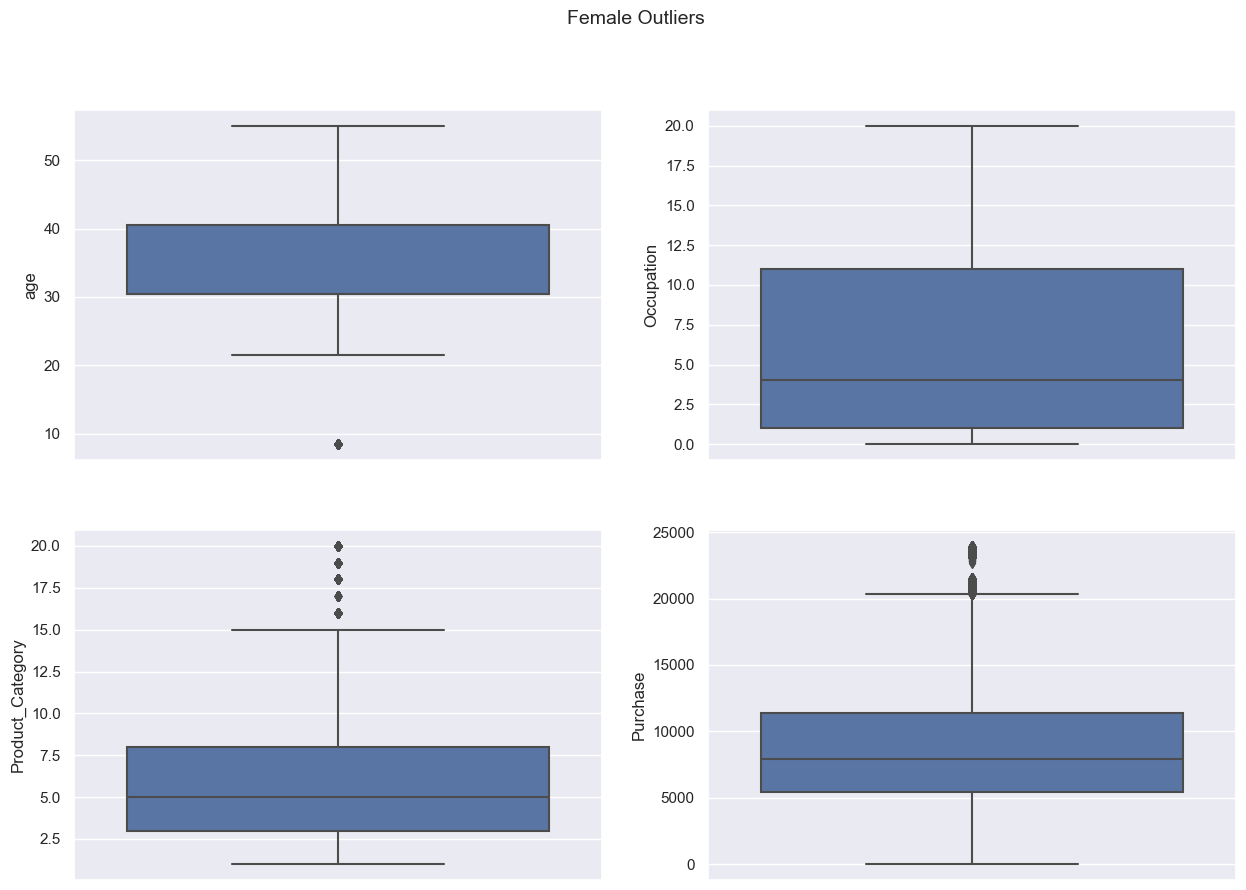

In [194]:
plt.figure(figsize=(15,10)).suptitle("Female Outliers",fontsize=14)

plt.subplot(2, 2, 1)
sns.boxplot(Female, y='age')
plt.subplot(2, 2, 2)
sns.boxplot(Female, y='Occupation')

plt.subplot(2, 2, 3)
sns.boxplot(Female, y="Product_Category")
plt.subplot(2, 2, 4)
sns.boxplot(Female, y="Purchase")

plt.show()

#### **<span style="color: #b05abc;">Plot the Graph</span>**

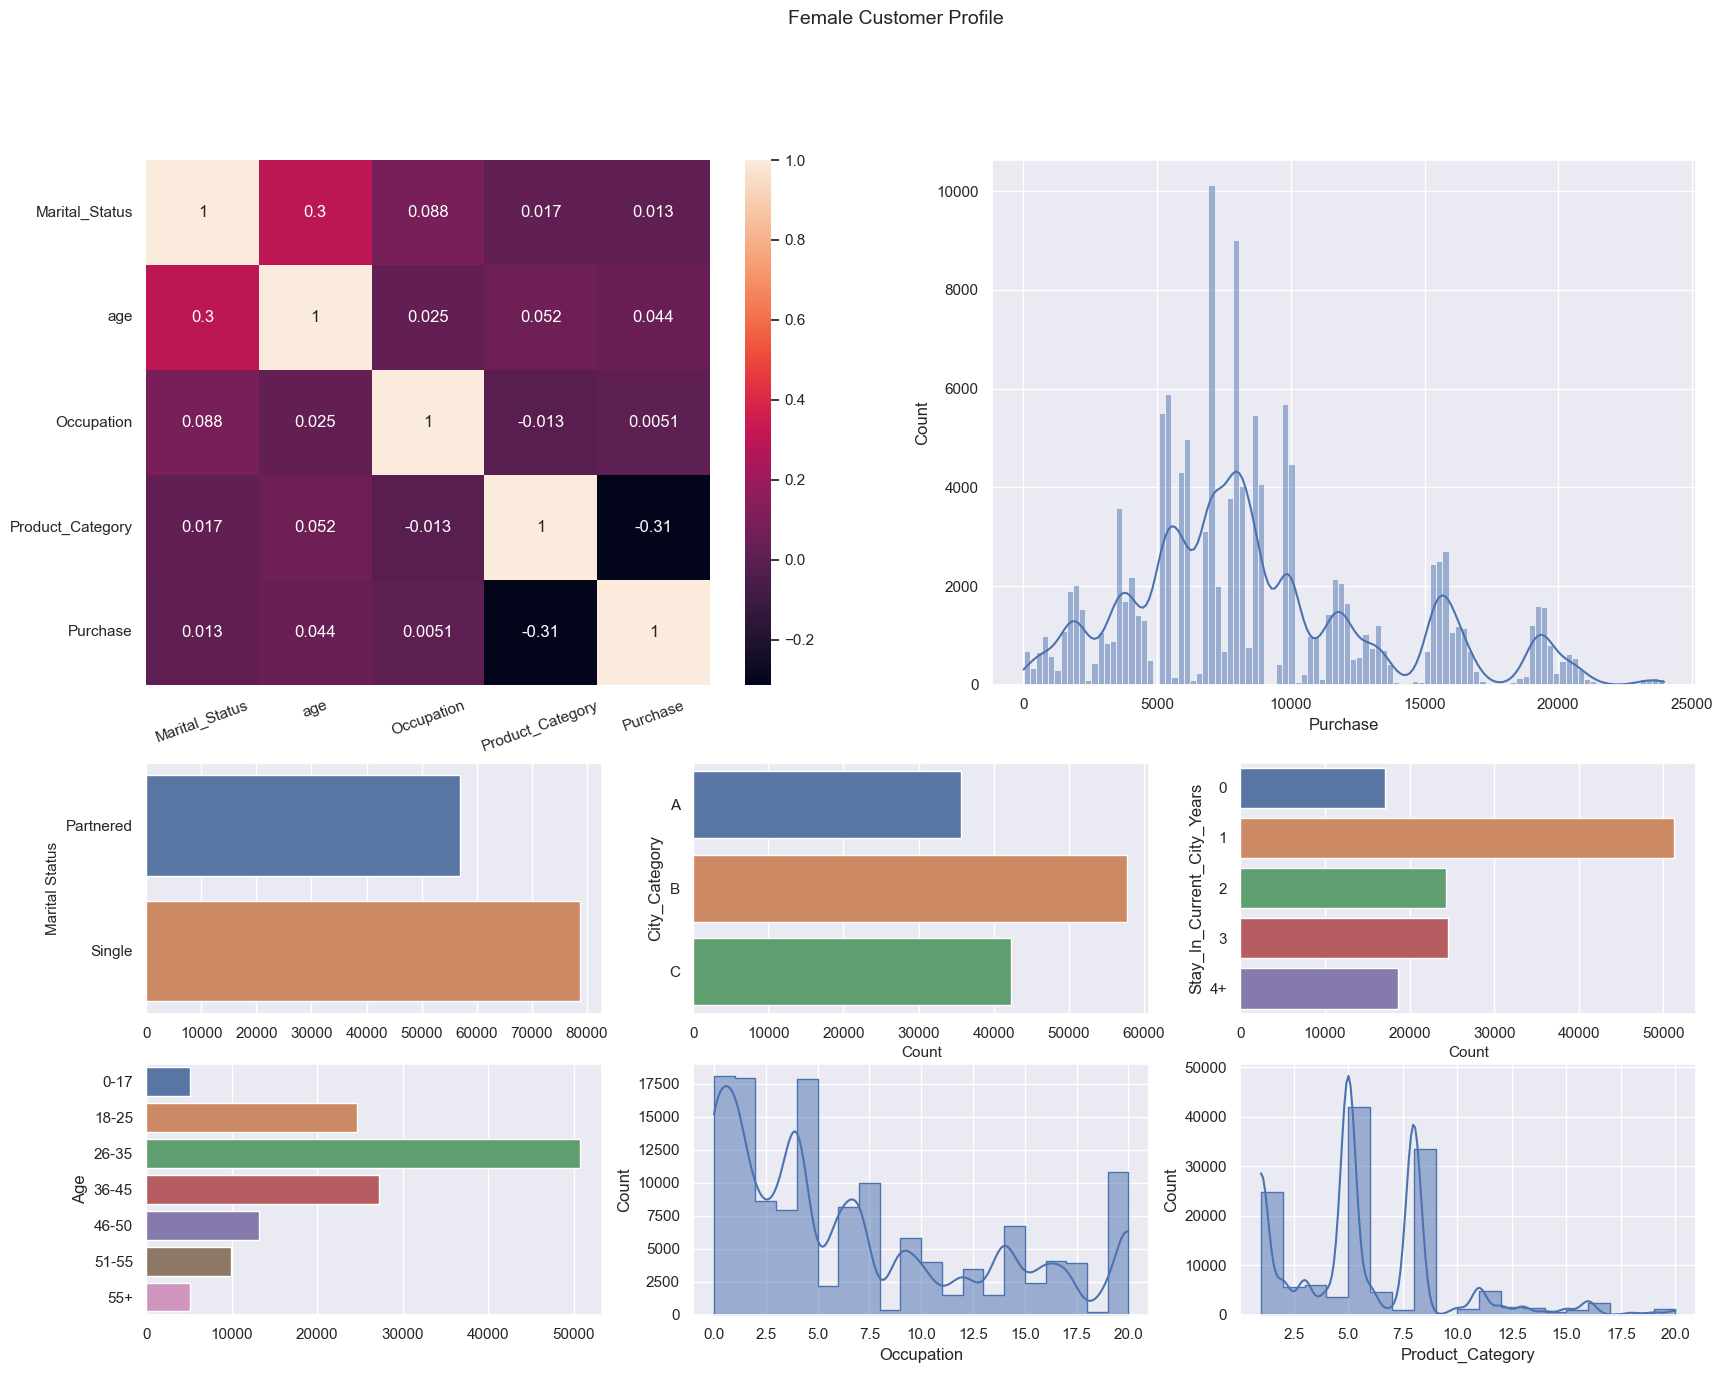

In [195]:
plt.figure(figsize=(20,15)).suptitle("Female Customer Profile",fontsize=14)

plt.subplot(2, 2, 1)
sns.heatmap(Female[['Marital_Status', 'age', 'Occupation', 'Product_Category', 'Purchase']].corr(), annot=True)
plt.yticks(rotation= 0, fontsize=11)
plt.xticks(rotation= 20, fontsize=11)

plt.subplot(2, 2, 2)
sns.histplot(Female, x="Purchase", kde=True)
# sns.histplot(Female, x="Purchase", binwidth=300, kde=True, element="step")

plt.subplot(4, 3, 7)
sns.countplot(Female, y='marital_status')
plt.xlabel("", fontsize=11)
plt.ylabel("Marital Status", fontsize=11)
plt.subplot(4, 3, 8)
sns.countplot(Female, y='City_Category')
plt.xlabel("Count", fontsize=11)
plt.subplot(4, 3, 9)
sns.countplot(Female, y='Stay_In_Current_City_Years')
plt.xlabel("Count", fontsize=11)

plt.subplot(4, 3, 10)
sns.countplot(Female, y='Age')
plt.xlabel("", fontsize=11)
plt.subplot(4, 3, 11)
sns.histplot(Female, x="Occupation", binwidth=1, kde=True, element="step")
plt.subplot(4, 3, 12)
sns.histplot(Female, x="Product_Category", binwidth=1, kde=True, element="step")

plt.show()

## **<span style="color: #33ffbb;">Bootstraping:</span>**

In [196]:
def filter_col_as_array(df, col, match, result_col, inverse=False):
    if inverse:
        return df[df[col]!=match][result_col]
    else :
        return df[df[col]==match][result_col]

In [197]:
class CLT_Interval:
    def __init__(self, mean, std_error, z_critical, margin_of_error, confidance_interval_lower, confidance_interval_upper, sample_df, significance_level, samples_size):
        self.mean = mean
        self.std_error = std_error
        self.z_critical = z_critical
        self.margin_of_error = margin_of_error
        self.confidance_interval_lower = confidance_interval_lower
        self.confidance_interval_upper = confidance_interval_upper
        self.sample_df = sample_df
        self.significance_level = significance_level
        self.samples_size = samples_size


In [198]:
def bootstraping(df, samples, cl, plot=True):
    bootstrap_sample_means = []

    for _ in range(samples):
        bootstrap_sample = df.sample(n=len(df), replace=True)
        bootstrap_sample_mean = bootstrap_sample.mean()
        bootstrap_sample_means.append(bootstrap_sample_mean)
    
    bootstrap_mean = np.mean(bootstrap_sample_means)
    bootstrap_std_error = np.std(bootstrap_sample_means)

    z_critical = norm.ppf((1 + cl) / 2)

    # Calculate the margin of error
    margin_of_error = z_critical * bootstrap_std_error

    # Calculate the confidence interval
    confidence_interval_lower = bootstrap_mean - margin_of_error
    confidence_interval_upper = bootstrap_mean + margin_of_error

    if(plot):
        plt.figure(figsize=(8, 4))
        sns.histplot(data=bootstrap_sample_means, bins=20, color='#66a3ff', label='Sample Mean', kde=True)
        plt.axvline(bootstrap_mean, color='#ff0066', linestyle='dashed', linewidth=2, label='Mean')
        plt.axvline(confidence_interval_lower, color='#ff8533', linestyle='dotted', linewidth=2, label='CI Lower')
        plt.axvline(confidence_interval_upper, color='#ff8533', linestyle='dotted', linewidth=2, label='CI Upper')
        plt.annotate(f'Mean: {bootstrap_mean:.2f}', rotation='vertical', xy=(bootstrap_mean, 0), xytext=(-20, 30), textcoords='offset points', color='blacK', fontsize=15)
        plt.annotate(f'{confidence_interval_lower:.2f}', rotation='vertical', xy=(confidence_interval_lower, 0), xytext=(-20, 80), textcoords='offset points', color='blacK', fontsize=14)
        plt.annotate(f'{confidence_interval_upper:.2f}', rotation='vertical', xy=(confidence_interval_upper, 0), xytext=(10, 80), textcoords='offset points', color='blacK', fontsize=14)
        plt.legend()

    return CLT_Interval(bootstrap_mean, bootstrap_std_error, z_critical, margin_of_error, confidence_interval_lower, confidence_interval_upper, bootstrap_sample_means, cl, samples)

Bootstrap Mean: 9263.472707727045
Bootstrap Standard Error: 6.804071836180344
Z-Critical Value: 1.6448536269514722
Margin of Error: 11.191702237779602
Bootstrap Confidence Interval: (9252.281005489265, 9274.664409964826)


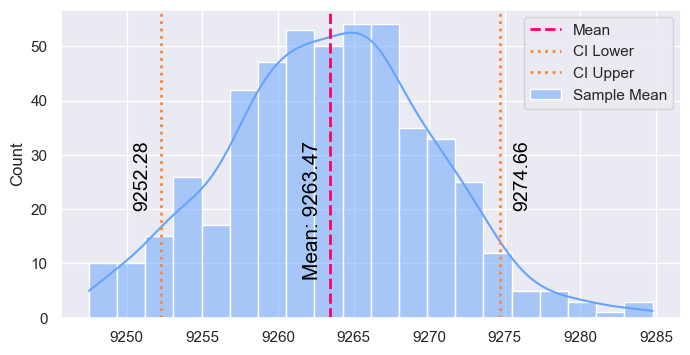

In [199]:
df = walmart_raw['Purchase']
samples=500
confidence_level = 0.9
clt_interval = bootstraping(df, samples, cl=confidence_level, plot=True)

print("Bootstrap Mean:", clt_interval.mean)
print("Bootstrap Standard Error:", clt_interval.std_error)
print("Z-Critical Value:", clt_interval.z_critical)
print("Margin of Error:", clt_interval.margin_of_error)
print("Bootstrap Confidence Interval:", (clt_interval.confidance_interval_lower, clt_interval.confidance_interval_upper))

## **<span style="color: #66ff66;">Data Exploration:</span>**

 * Tracking the amount spent per transaction of all the 50 million female customers, and all the 50 million male customers, calculate the average, and conclude the results.
 * Inference after computing the average female and male expenses.
 * Use the sample average to find out an interval within which the population average will lie. Using the sample of female customers you will calculate the interval within which the average spending of 50 million male and female customers may lie.

## **<span style="color: #66ff66;">Use the Central limit theorem to compute the interval.</span>**
 * Change the sample size to observe the distribution of the mean of the expenses by female and male customers.
 * The interval that you calculated is called Confidence Interval. The width of the interval is mostly decided by the business: Typically 90%, 95%, or 99%. Play around with the width parameter and report the observations.

## **<span style="color: #ff3333;">Using above check if different Groups are overlapping or not overlapping</span>**

*  Male and Female spend's CI are overlapping or not overlapping.
*  Married vs Unmarried
*  Age: 0-17, 18-25, 26-35, 36-50, 51+ years.

 > Conclude the results 
 > How can Walmart leverage this conclusion to make changes or improvements?

## **<span style="color: #cc0000;">Questions</span>**

### **<span style="color: #cc0066;">Q1. Are women spending more money per transaction than men? Why or Why not?</span>**

In [200]:
average_spending_by_gender = walmart_raw.groupby('Gender')['Purchase'].mean().reset_index()
average_spending_by_gender

Gender     Purchase
0  Female  8734.565765
1    Male  9437.526040

<Axes: xlabel='Gender', ylabel='Purchase'>

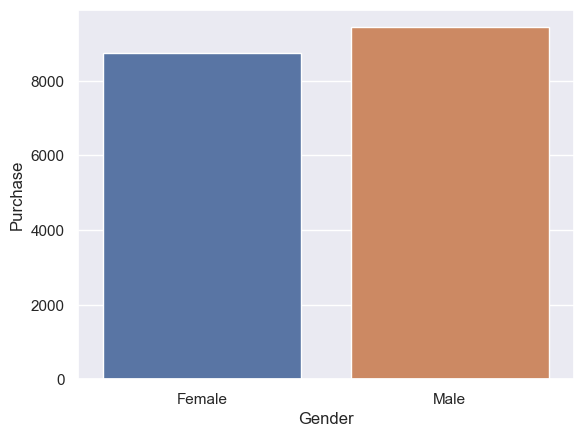

In [201]:
sns.barplot(x=average_spending_by_gender.Gender, y=average_spending_by_gender.Purchase)

Here, we found that mean Purchase by Man's Purchase are higher then Women's Purchase.

In [202]:

#@ Ho -> Man Spend more than Women on Black Friday
## Ha -> Women Spend more than Man on Black Friday

# % We will use 500 Sample
samples=500

In [203]:
male_df = filter_col_as_array(df=walmart_raw, col='Gender', match='Male', result_col='Purchase')
female_df = filter_col_as_array(df=walmart_raw, col='Gender', match='Female', result_col='Purchase')

In [204]:
t_statistic, p_value = ttest_ind(female_df, male_df, alternative="greater")
t_statistic, p_value

(-44.837957934353966, 1.0)

#### When Confidance Interval is 90%

In [205]:
confidence_level = 0.90
sigma = 1-confidence_level #$ Significance Level

In [206]:
if p_value < sigma:
    print("Women Spend more than Man on Black Friday")
else:
    print("Man Spend more than Women on Black Friday")

Man Spend more than Women on Black Friday


##### Use the Central limit theorem to compute the interval

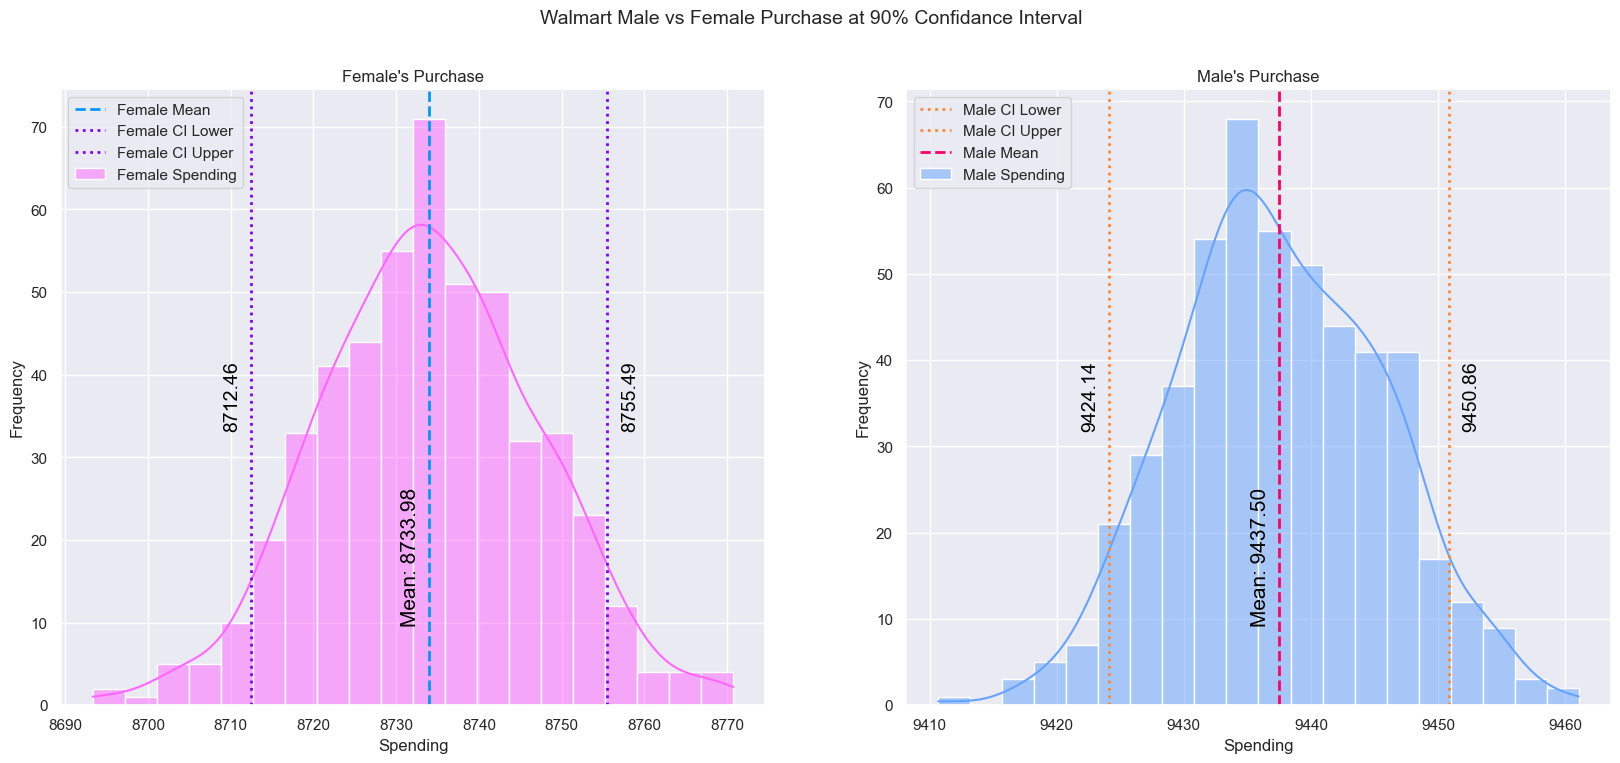

In [207]:
male_clt_interval = bootstraping(male_df, samples, cl=confidence_level, plot=False)
female_clt_interval = bootstraping(female_df, samples, cl=confidence_level, plot=False)
# mean, std_error, z_critical, margin_of_error, confidance_interval_lower, confidance_interval_upper, sample_df, significance_level, samples_size

plt.figure(figsize=(20,8)).suptitle("Walmart Male vs Female Purchase at 90% Confidance Interval",fontsize=14)

plt.subplot(1, 2, 1)
sns.histplot(data=female_clt_interval.sample_df, bins=20, color='#ff66ff', label='Female Spending', kde=True)
plt.axvline(female_clt_interval.mean, color='#0099ff', linestyle='dashed', linewidth=2, label='Female Mean')
plt.axvline(female_clt_interval.confidance_interval_lower, color='#8000ff', linestyle='dotted', linewidth=2, label='Female CI Lower')
plt.axvline(female_clt_interval.confidance_interval_upper, color='#8000ff', linestyle='dotted', linewidth=2, label='Female CI Upper')
plt.annotate(f'Mean: {female_clt_interval.mean:.2f}', rotation='vertical', xy=(female_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{female_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(female_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{female_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(female_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('Female\'s Purchase')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=male_clt_interval.sample_df, bins=20, color='#66a3ff', label='Male Spending', kde=True)
plt.axvline(male_clt_interval.confidance_interval_lower, color='#ff8533', linestyle='dotted', linewidth=2, label='Male CI Lower')
plt.axvline(male_clt_interval.confidance_interval_upper, color='#ff8533', linestyle='dotted', linewidth=2, label='Male CI Upper')
plt.axvline(male_clt_interval.mean, color='#ff0066', linestyle='dashed', linewidth=2, label='Male Mean')
plt.annotate(f'Mean: {male_clt_interval.mean:.2f}', rotation='vertical', xy=(male_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{male_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(male_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{male_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(male_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('Male\'s Purchase')
plt.legend()

plt.show()

#### When Confidance Interval is 95%

In [208]:
confidence_level = 0.95
sigma = 1-confidence_level #$ Significance Level

In [209]:
if p_value < sigma:
    print("Women Spend more than Man on Black Friday")
else:
    print("Man Spend more than Women on Black Friday")

Man Spend more than Women on Black Friday


##### Use the Central limit theorem to compute the interval

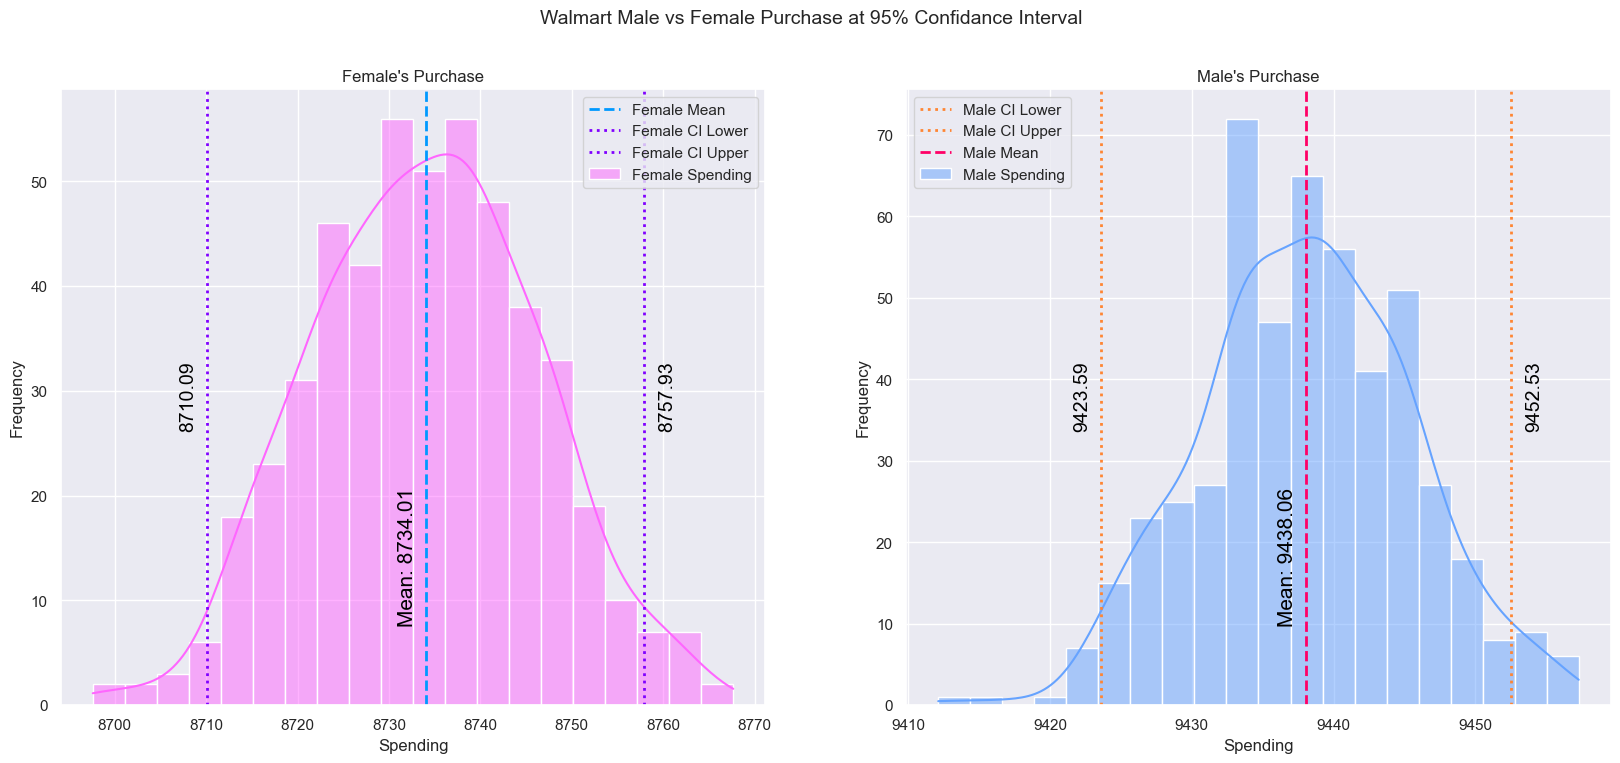

In [210]:
male_clt_interval = bootstraping(male_df, samples, cl=confidence_level, plot=False)
female_clt_interval = bootstraping(female_df, samples, cl=confidence_level, plot=False)
# mean, std_error, z_critical, margin_of_error, confidance_interval_lower, confidance_interval_upper, sample_df, significance_level, samples_size

plt.figure(figsize=(20,8)).suptitle("Walmart Male vs Female Purchase at 95% Confidance Interval",fontsize=14)

plt.subplot(1, 2, 1)
sns.histplot(data=female_clt_interval.sample_df, bins=20, color='#ff66ff', label='Female Spending', kde=True)
plt.axvline(female_clt_interval.mean, color='#0099ff', linestyle='dashed', linewidth=2, label='Female Mean')
plt.axvline(female_clt_interval.confidance_interval_lower, color='#8000ff', linestyle='dotted', linewidth=2, label='Female CI Lower')
plt.axvline(female_clt_interval.confidance_interval_upper, color='#8000ff', linestyle='dotted', linewidth=2, label='Female CI Upper')
plt.annotate(f'Mean: {female_clt_interval.mean:.2f}', rotation='vertical', xy=(female_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{female_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(female_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{female_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(female_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('Female\'s Purchase')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=male_clt_interval.sample_df, bins=20, color='#66a3ff', label='Male Spending', kde=True)
plt.axvline(male_clt_interval.confidance_interval_lower, color='#ff8533', linestyle='dotted', linewidth=2, label='Male CI Lower')
plt.axvline(male_clt_interval.confidance_interval_upper, color='#ff8533', linestyle='dotted', linewidth=2, label='Male CI Upper')
plt.axvline(male_clt_interval.mean, color='#ff0066', linestyle='dashed', linewidth=2, label='Male Mean')
plt.annotate(f'Mean: {male_clt_interval.mean:.2f}', rotation='vertical', xy=(male_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{male_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(male_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{male_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(male_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('Male\'s Purchase')
plt.legend()

plt.show()


#### When Confidance Interval is 99%

In [211]:
confidence_level = 0.99
sigma = 1-confidence_level #$ Significance Level

In [212]:
if p_value < sigma:
    print("Women Spend more than Man on Black Friday")
else:
    print("Man Spend more than Women on Black Friday")

Man Spend more than Women on Black Friday


##### Use the Central limit theorem to compute the interval

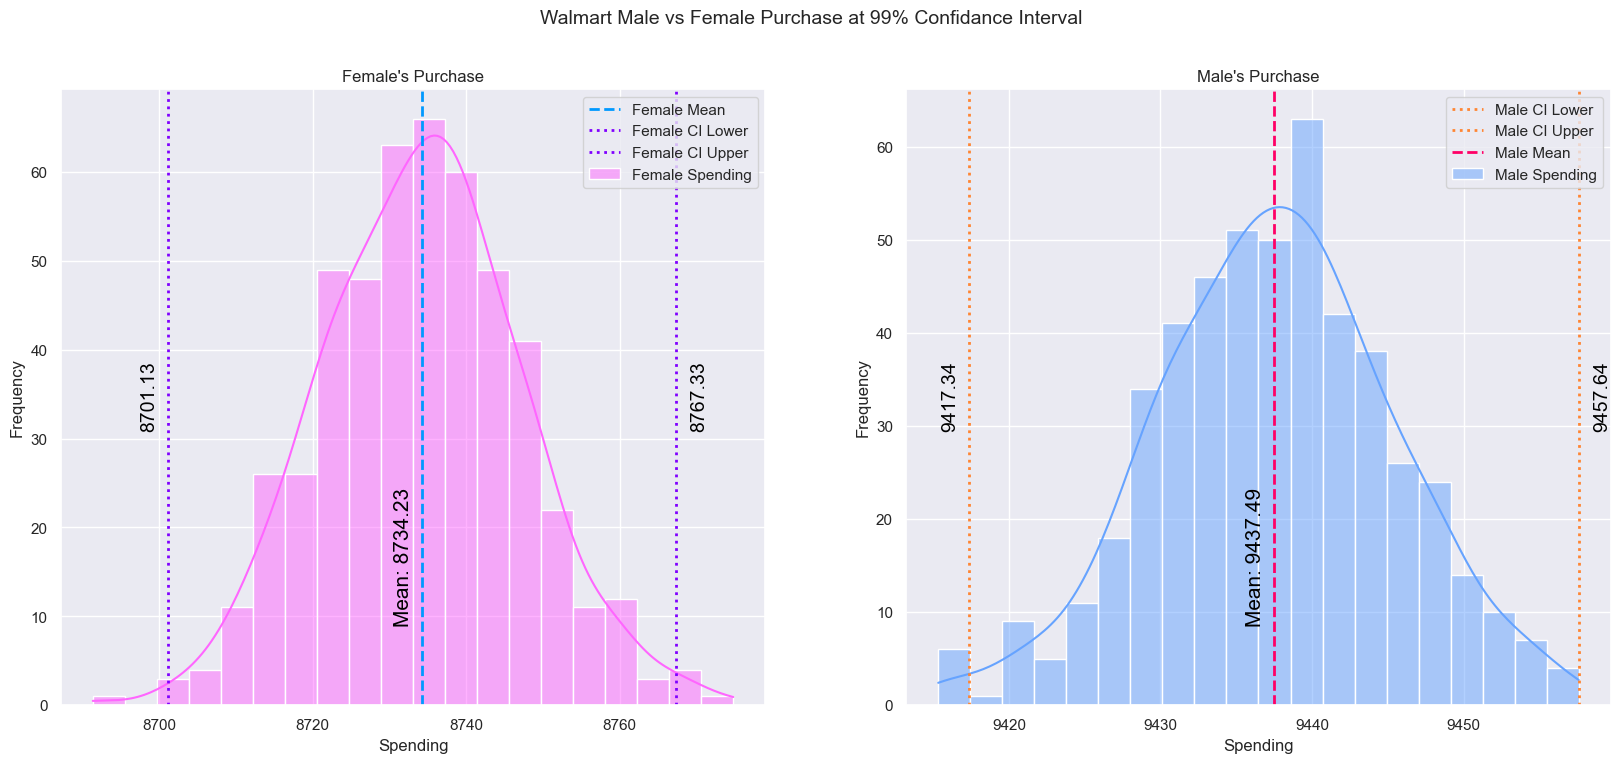

In [213]:
male_clt_interval = bootstraping(male_df, samples, cl=confidence_level, plot=False)
female_clt_interval = bootstraping(female_df, samples, cl=confidence_level, plot=False)
# mean, std_error, z_critical, margin_of_error, confidance_interval_lower, confidance_interval_upper, sample_df, significance_level, samples_size

plt.figure(figsize=(20,8)).suptitle("Walmart Male vs Female Purchase at 99% Confidance Interval",fontsize=14)

plt.subplot(1, 2, 1)
sns.histplot(data=female_clt_interval.sample_df, bins=20, color='#ff66ff', label='Female Spending', kde=True)
plt.axvline(female_clt_interval.mean, color='#0099ff', linestyle='dashed', linewidth=2, label='Female Mean')
plt.axvline(female_clt_interval.confidance_interval_lower, color='#8000ff', linestyle='dotted', linewidth=2, label='Female CI Lower')
plt.axvline(female_clt_interval.confidance_interval_upper, color='#8000ff', linestyle='dotted', linewidth=2, label='Female CI Upper')
plt.annotate(f'Mean: {female_clt_interval.mean:.2f}', rotation='vertical', xy=(female_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{female_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(female_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{female_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(female_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('Female\'s Purchase')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=male_clt_interval.sample_df, bins=20, color='#66a3ff', label='Male Spending', kde=True)
plt.axvline(male_clt_interval.confidance_interval_lower, color='#ff8533', linestyle='dotted', linewidth=2, label='Male CI Lower')
plt.axvline(male_clt_interval.confidance_interval_upper, color='#ff8533', linestyle='dotted', linewidth=2, label='Male CI Upper')
plt.axvline(male_clt_interval.mean, color='#ff0066', linestyle='dashed', linewidth=2, label='Male Mean')
plt.annotate(f'Mean: {male_clt_interval.mean:.2f}', rotation='vertical', xy=(male_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{male_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(male_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{male_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(male_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('Male\'s Purchase')
plt.legend()

plt.show()


#### 
> Insight
Men Spend More than Women on Black Friday Sale.

        Ho -> Man Spend more than Women on Black Friday
        Ha -> Women Spend more than Man on Black Friday

    Using T-Test p_value of Women Spend more than Man on Black Friday found as 100%.

* With Confidance interval of 90% & Sample Size of 500
    * Mean Purchase by Female is 8735.71 with a Intervals of (8714.39 - 8757.04).
    * Mean Purchase by Male is 9437.51 with a Intervals of (9424.52 - 9450.50)
    * As 100% > 10% Thus Failed to Rejecting Ho.

* With Confidance interval of 95% & Sample Size of 500
    * Mean Purchase by Female is 8734.93 with a Intervals of (8710.22 - 8759.65).
    * Mean Purchase by Male is 9437.05 with a Intervals of (9421.23 - 9452.87)
    * As 100% > 5% Thus Failed to Rejecting Ho.

* With Confidance interval of 99% & Sample Size of 500
    * Mean Purchase by Female is 8733.73 with a Intervals of (8700.89 - 8766.57).
    * Mean Purchase by Male is 9437.61 with a Intervals of (9417.41 - 9457.81)
    * As 100% > 1% Thus Failed to Rejecting Ho.

As per T-Test we can Conclude woman are not spending more money per transation than man.

### **<span style="color: #cc0066;">Q2. Confidence intervals and distribution of the mean of the expenses by female and male customers?</span>**

 
While Answering Q1. we have calculated Confidance Interval and Distribution of Means for Male& Female. And found

* With Confidance interval of 90% & Sample Size of 500
    * Mean Purchase by Female is 8735.71 with a Intervals of (8714.39 - 8757.04).
    * Mean Purchase by Male is 9437.51 with a Intervals of (9424.52 - 9450.50).

* With Confidance interval of 95% & Sample Size of 500
    * Mean Purchase by Female is 8734.93 with a Intervals of (8710.22 - 8759.65).
    * Mean Purchase by Male is 9437.05 with a Intervals of (9421.23 - 9452.87).

* With Confidance interval of 99% & Sample Size of 500
    * Mean Purchase by Female is 8733.73 with a Intervals of (8700.89 - 8766.57).
    * Mean Purchase by Male is 9437.61 with a Intervals of (9417.41 - 9457.81).
 

### **<span style="color: #cc0066;">Q3. Using Confidence intervals check if spending for Male vs Female are overlapping or not overlapping?</span>**

While Answering Q1. we have calculated Confidance Interval and Distribution of Means for Male& Female.

And Found that there is no Overlapping in Man & Women's Purchase.

To Increase Purchase by Women or Sales to Women we need to provide Women's Centric Discount & Add more Women Centric Products.
 

### **<span style="color: #cc0066;">Q4. Using Confidence intervals check if spending for Married vs Unmarried are overlapping or not overlapping?</span>**

In [214]:
average_spending_by_marital_status = walmart_raw.groupby('marital_status')['Purchase'].mean().reset_index()
average_spending_by_marital_status

marital_status     Purchase
0      Partnered  9261.174574
1         Single  9265.907619

<Axes: xlabel='marital_status', ylabel='Purchase'>

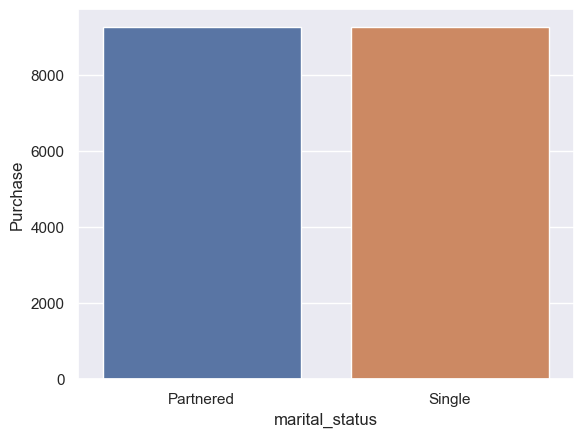

In [215]:
sns.barplot(x=average_spending_by_marital_status.marital_status, y=average_spending_by_marital_status.Purchase)

Here, we found that mean Purchase by Single persons's Purchase are nearly equal to Partnered persons's Purchase.

In [216]:

#@ Ho -> Single & Partnered peoples are Spend significantly equal on Black Friday
## Ha -> Single & Partnered peoples are Spend significantly different on Black Friday

# % We will use 500 Sample
samples=500

In [217]:
single_df = filter_col_as_array(df=walmart_raw, col='marital_status', match='Single', result_col='Purchase')
partnered_df = filter_col_as_array(df=walmart_raw, col='marital_status', match='Partnered', result_col='Purchase')

In [218]:
t_statistic, p_value = ttest_ind(single_df, partnered_df)
t_statistic, p_value

(0.3436698055440526, 0.7310947525758316)

#### When Confidance Interval is 90%

In [219]:
confidence_level = 0.90
sigma = 1-confidence_level #$ Significance Level

In [220]:
if p_value < sigma:
    print("Single & Partnered peoples are Spend significantly different on Black Friday")
else:
    print("Single & Partnered peoples are Spend significantly equal on Black Friday")


Single & Partnered peoples are Spend significantly equal on Black Friday


##### Use the Central limit theorem to compute the interval

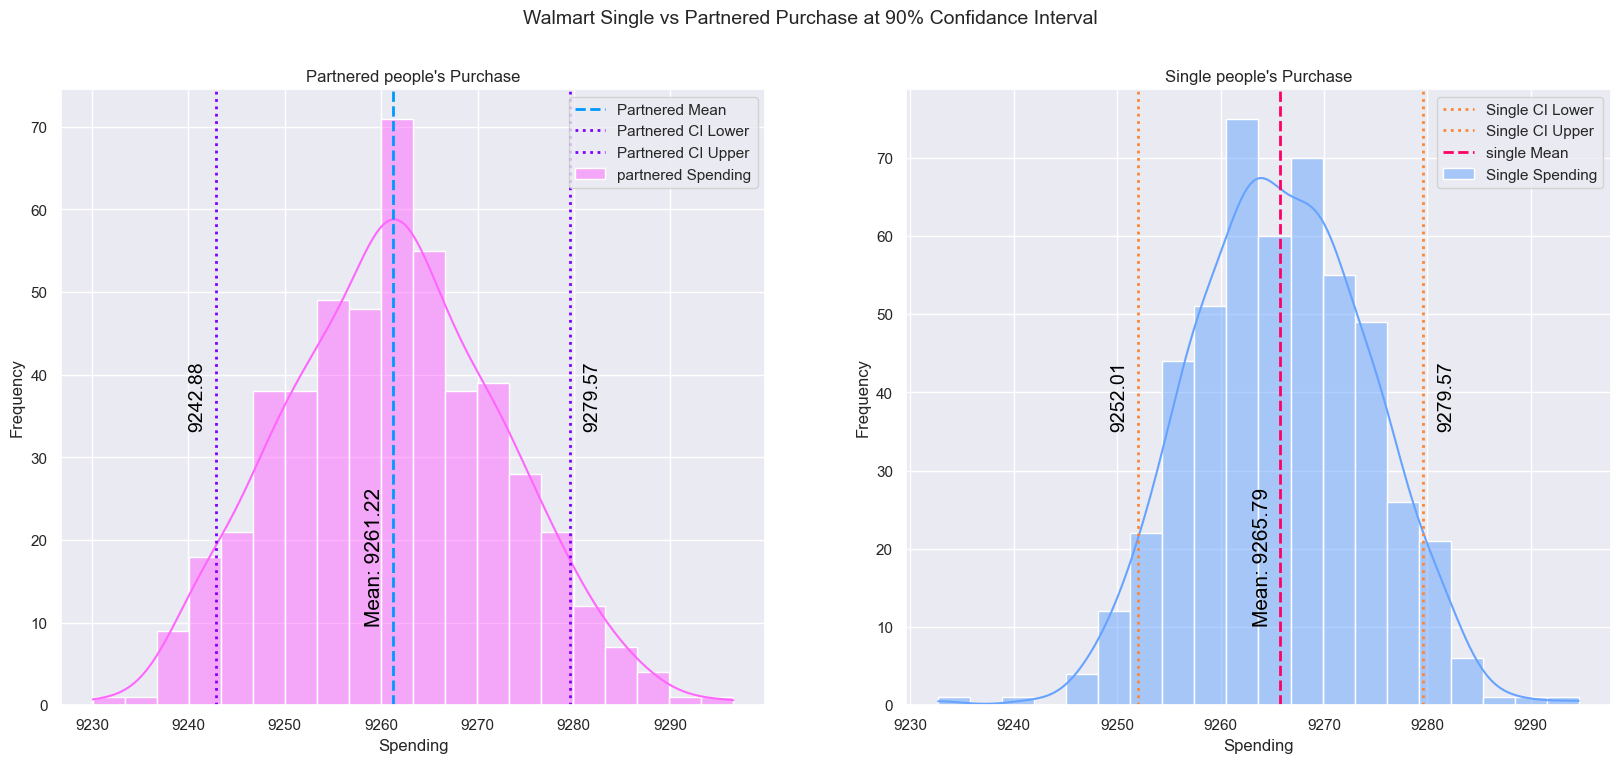

In [221]:
single_clt_interval = bootstraping(single_df, samples, cl=confidence_level, plot=False)
partnered_clt_interval = bootstraping(partnered_df, samples, cl=confidence_level, plot=False)
# mean, std_error, z_critical, margin_of_error, confidance_interval_lower, confidance_interval_upper, sample_df, significance_level, samples_size

plt.figure(figsize=(20,8)).suptitle("Walmart Single vs Partnered Purchase at 90% Confidance Interval",fontsize=14)

plt.subplot(1, 2, 1)
sns.histplot(data=partnered_clt_interval.sample_df, bins=20, color='#ff66ff', label='partnered Spending', kde=True)
plt.axvline(partnered_clt_interval.mean, color='#0099ff', linestyle='dashed', linewidth=2, label='Partnered Mean')
plt.axvline(partnered_clt_interval.confidance_interval_lower, color='#8000ff', linestyle='dotted', linewidth=2, label='Partnered CI Lower')
plt.axvline(partnered_clt_interval.confidance_interval_upper, color='#8000ff', linestyle='dotted', linewidth=2, label='Partnered CI Upper')
plt.annotate(f'Mean: {partnered_clt_interval.mean:.2f}', rotation='vertical', xy=(partnered_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{partnered_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(partnered_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{partnered_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(partnered_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('Partnered people\'s Purchase')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=single_clt_interval.sample_df, bins=20, color='#66a3ff', label='Single Spending', kde=True)
plt.axvline(single_clt_interval.confidance_interval_lower, color='#ff8533', linestyle='dotted', linewidth=2, label='Single CI Lower')
plt.axvline(single_clt_interval.confidance_interval_upper, color='#ff8533', linestyle='dotted', linewidth=2, label='Single CI Upper')
plt.axvline(single_clt_interval.mean, color='#ff0066', linestyle='dashed', linewidth=2, label='single Mean')
plt.annotate(f'Mean: {single_clt_interval.mean:.2f}', rotation='vertical', xy=(single_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{single_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(single_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{single_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(single_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('Single people\'s Purchase')
plt.legend()

plt.show()

#### When Confidance Interval is 95%

In [222]:
confidence_level = 0.95
sigma = 1-confidence_level #$ Significance Level

In [223]:
if p_value < sigma:
    print("Single & Partnered peoples are Spend significantly different on Black Friday")
else:
    print("Single & Partnered peoples are Spend significantly equal on Black Friday")


Single & Partnered peoples are Spend significantly equal on Black Friday


##### Use the Central limit theorem to compute the interval

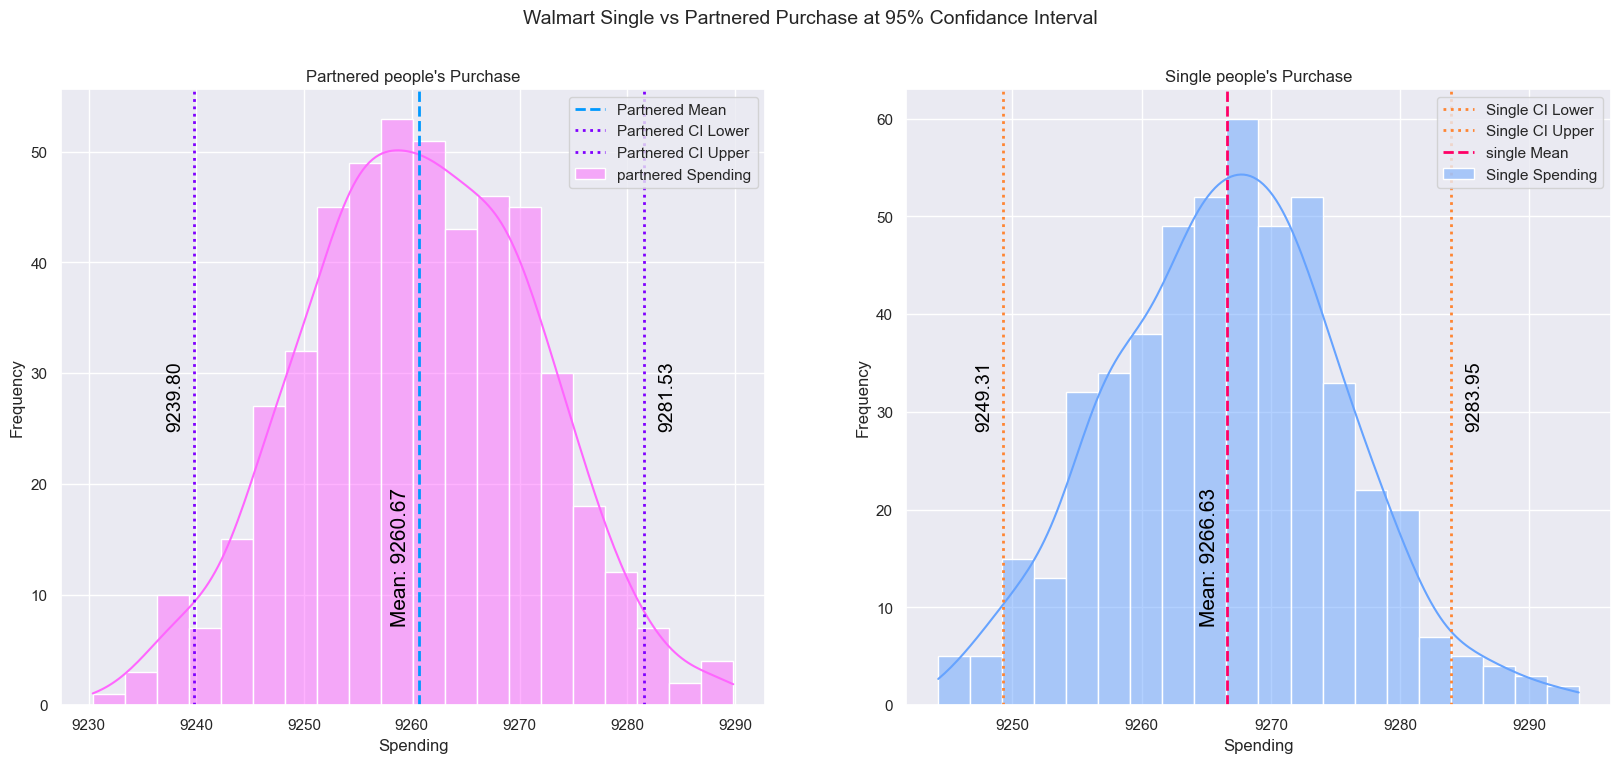

In [224]:
single_clt_interval = bootstraping(single_df, samples, cl=confidence_level, plot=False)
partnered_clt_interval = bootstraping(partnered_df, samples, cl=confidence_level, plot=False)
# mean, std_error, z_critical, margin_of_error, confidance_interval_lower, confidance_interval_upper, sample_df, significance_level, samples_size

plt.figure(figsize=(20,8)).suptitle("Walmart Single vs Partnered Purchase at 95% Confidance Interval",fontsize=14)

plt.subplot(1, 2, 1)
sns.histplot(data=partnered_clt_interval.sample_df, bins=20, color='#ff66ff', label='partnered Spending', kde=True)
plt.axvline(partnered_clt_interval.mean, color='#0099ff', linestyle='dashed', linewidth=2, label='Partnered Mean')
plt.axvline(partnered_clt_interval.confidance_interval_lower, color='#8000ff', linestyle='dotted', linewidth=2, label='Partnered CI Lower')
plt.axvline(partnered_clt_interval.confidance_interval_upper, color='#8000ff', linestyle='dotted', linewidth=2, label='Partnered CI Upper')
plt.annotate(f'Mean: {partnered_clt_interval.mean:.2f}', rotation='vertical', xy=(partnered_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{partnered_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(partnered_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{partnered_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(partnered_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('Partnered people\'s Purchase')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=single_clt_interval.sample_df, bins=20, color='#66a3ff', label='Single Spending', kde=True)
plt.axvline(single_clt_interval.confidance_interval_lower, color='#ff8533', linestyle='dotted', linewidth=2, label='Single CI Lower')
plt.axvline(single_clt_interval.confidance_interval_upper, color='#ff8533', linestyle='dotted', linewidth=2, label='Single CI Upper')
plt.axvline(single_clt_interval.mean, color='#ff0066', linestyle='dashed', linewidth=2, label='single Mean')
plt.annotate(f'Mean: {single_clt_interval.mean:.2f}', rotation='vertical', xy=(single_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{single_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(single_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{single_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(single_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('Single people\'s Purchase')
plt.legend()

plt.show()

#### When Confidance Interval is 99%

In [225]:
confidence_level = 0.99
sigma = 1-confidence_level #$ Significance Level

In [226]:
if p_value < sigma:
    print("Single & Partnered peoples are Spend significantly different on Black Friday")
else:
    print("Single & Partnered peoples are Spend significantly equal on Black Friday")


Single & Partnered peoples are Spend significantly equal on Black Friday


##### Use the Central limit theorem to compute the interval

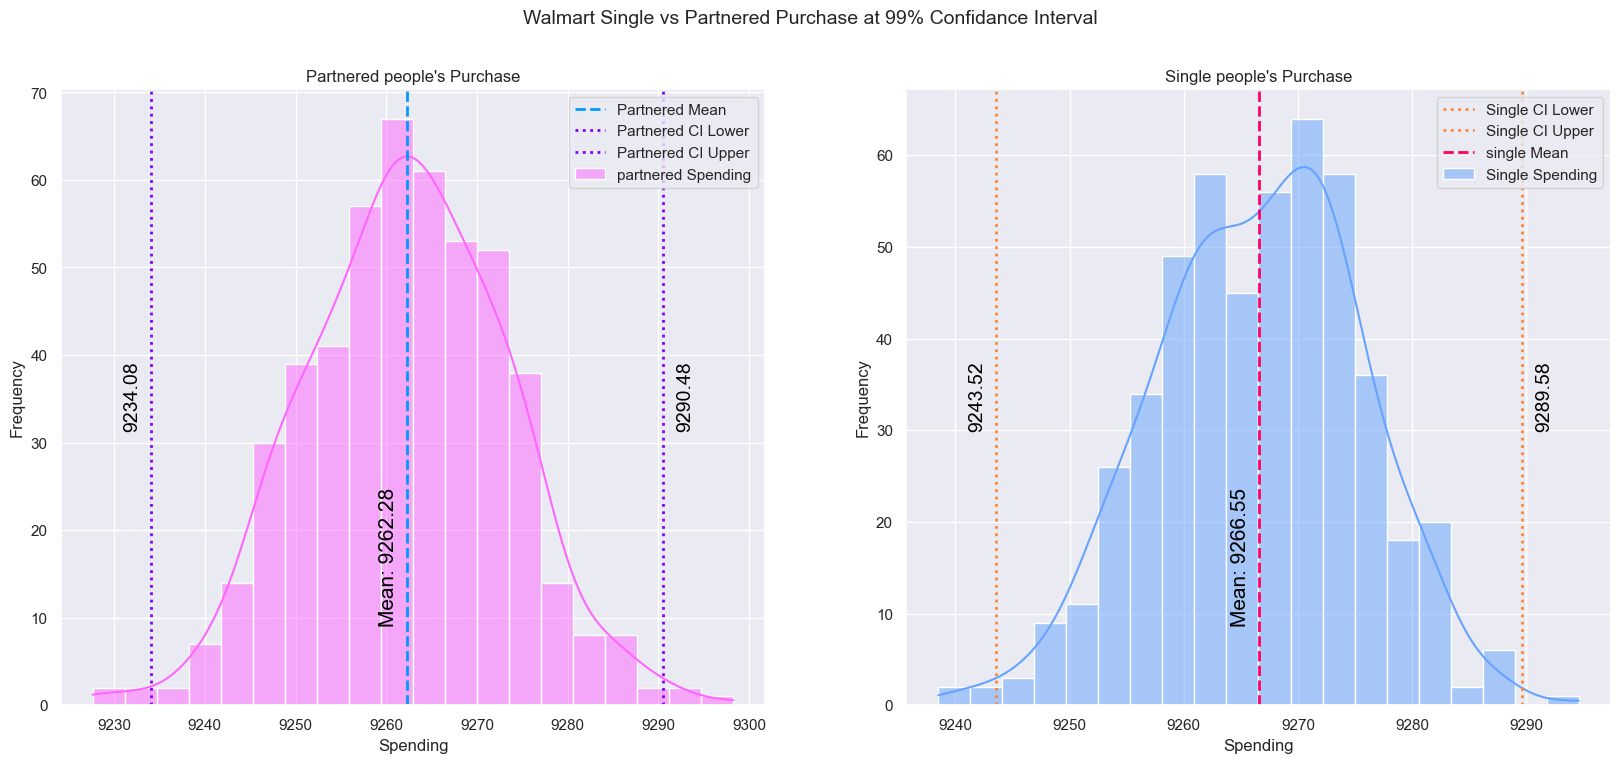

In [227]:
single_clt_interval = bootstraping(single_df, samples, cl=confidence_level, plot=False)
partnered_clt_interval = bootstraping(partnered_df, samples, cl=confidence_level, plot=False)
# mean, std_error, z_critical, margin_of_error, confidance_interval_lower, confidance_interval_upper, sample_df, significance_level, samples_size

plt.figure(figsize=(20,8)).suptitle("Walmart Single vs Partnered Purchase at 99% Confidance Interval",fontsize=14)

plt.subplot(1, 2, 1)
sns.histplot(data=partnered_clt_interval.sample_df, bins=20, color='#ff66ff', label='partnered Spending', kde=True)
plt.axvline(partnered_clt_interval.mean, color='#0099ff', linestyle='dashed', linewidth=2, label='Partnered Mean')
plt.axvline(partnered_clt_interval.confidance_interval_lower, color='#8000ff', linestyle='dotted', linewidth=2, label='Partnered CI Lower')
plt.axvline(partnered_clt_interval.confidance_interval_upper, color='#8000ff', linestyle='dotted', linewidth=2, label='Partnered CI Upper')
plt.annotate(f'Mean: {partnered_clt_interval.mean:.2f}', rotation='vertical', xy=(partnered_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{partnered_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(partnered_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{partnered_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(partnered_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('Partnered people\'s Purchase')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=single_clt_interval.sample_df, bins=20, color='#66a3ff', label='Single Spending', kde=True)
plt.axvline(single_clt_interval.confidance_interval_lower, color='#ff8533', linestyle='dotted', linewidth=2, label='Single CI Lower')
plt.axvline(single_clt_interval.confidance_interval_upper, color='#ff8533', linestyle='dotted', linewidth=2, label='Single CI Upper')
plt.axvline(single_clt_interval.mean, color='#ff0066', linestyle='dashed', linewidth=2, label='single Mean')
plt.annotate(f'Mean: {single_clt_interval.mean:.2f}', rotation='vertical', xy=(single_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{single_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(single_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{single_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(single_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('Single people\'s Purchase')
plt.legend()

plt.show()

#### 
> Insight

Single & Partnered peoples are Spend significantly equal on Black Friday.
`Marital Status` doesn't effect Purchase.

        Ho -> Single & Partnered peoples are Spend significantly equal on Black Friday
        Ha -> Single & Partnered peoples are Spend significantly different on Black Friday

      Using T-Test p_value of Partnered & Single Purchase different than each other found as 73.1094%.
      
* With Confidance interval of 90% & Sample Size of 500
    * Mean Purchase by Partnered is 9261.22 with a Intervals of (9242.88 - 9279.57).
    * Mean Purchase by Single is 9265.79 with a Intervals of (9252.01 - 9279.57)
    * As 73.10% > 10% Thus Failed to Rejecting Ho.
 
* With Confidance interval of 95% & Sample Size of 500
    * Mean Purchase by Partnered is 9260.71 with a Intervals of (9240.36 - 9281.06).
    * Mean Purchase by Single is 9265.94 with a Intervals of (9248.55 - 9283.32)
    * As 73.10% > 5% Thus Failed to Rejecting Ho.

* With Confidance interval of 99% & Sample Size of 500
    * Mean Purchase by Partnered is 9261.62 with a Intervals of (9234.07 - 9289.17).
    * Mean Purchase by Single is 9266.31 with a Intervals of (9243.13 - 9289.49)
    * As 73.10% > 1% Thus Failed to Rejecting Ho.
  
Yes, Married & Unmarried Peoples Purchase are Overlapping.

### **<span style="color: #cc0066;">Q5.Using Confidence intervals check if spending for different Age Group are overlapping or not overlapping?</span>**

In [228]:
average_spending_by_age = walmart_raw.groupby('Age')['Purchase'].mean().reset_index().sort_values('Purchase', ascending=False)
average_spending_by_age

Age     Purchase
5  51-55  9534.808031
6    55+  9336.280459
3  36-45  9331.350695
2  26-35  9252.690633
4  46-50  9208.625697
1  18-25  9169.663606
0   0-17  8933.464640

<Axes: xlabel='Age', ylabel='Purchase'>

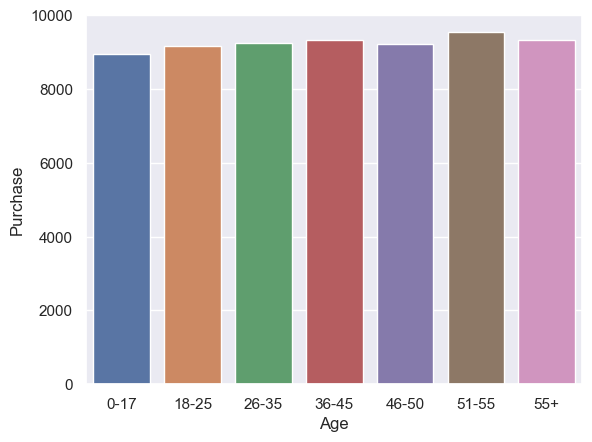

In [229]:
sns.barplot(x=average_spending_by_age.Age, y=average_spending_by_age.Purchase)

Here, we found that mean Purchase by 51-55 Aged peoples are Significantly Higher then All other's.

In [230]:

#@ Ho -> Mean Purchase for All Age group are Same.
## Ha -> Differance exists in Mean Purchase for All Age group.

# % We will use 500 Sample
samples=500

In [231]:
df_0_17 = filter_col_as_array(df=walmart_raw, col='Age', match='0-17', result_col='Purchase')
df_18_25 = filter_col_as_array(df=walmart_raw, col='Age', match='18-25', result_col='Purchase')
df_26_35 = filter_col_as_array(df=walmart_raw, col='Age', match='26-35', result_col='Purchase')
df_36_45 = filter_col_as_array(df=walmart_raw, col='Age', match='36-45', result_col='Purchase')
df_46_50 = filter_col_as_array(df=walmart_raw, col='Age', match='46-50', result_col='Purchase')
df_51_55 = filter_col_as_array(df=walmart_raw, col='Age', match='51-55', result_col='Purchase')
df_55 = filter_col_as_array(df=walmart_raw, col='Age', match='55+', result_col='Purchase')

In [232]:
t_statistic, p_value = f_oneway(df_0_17, df_18_25, df_26_35, df_36_45, df_46_50, df_51_55, df_55)
t_statistic, p_value

(40.57579909450407, 1.053563939251671e-49)

#### When Confidance Interval is 90%

In [233]:
confidence_level = 0.90
sigma = 1-confidence_level #$ Significance Level

In [234]:
if p_value < sigma:
    print("Differance exists in Mean Purchase for All Age group.")
else:
    print("Mean Purchase for All Age group are Same.")


Differance exists in Mean Purchase for All Age group.


##### Use the Central limit theorem to compute the interval

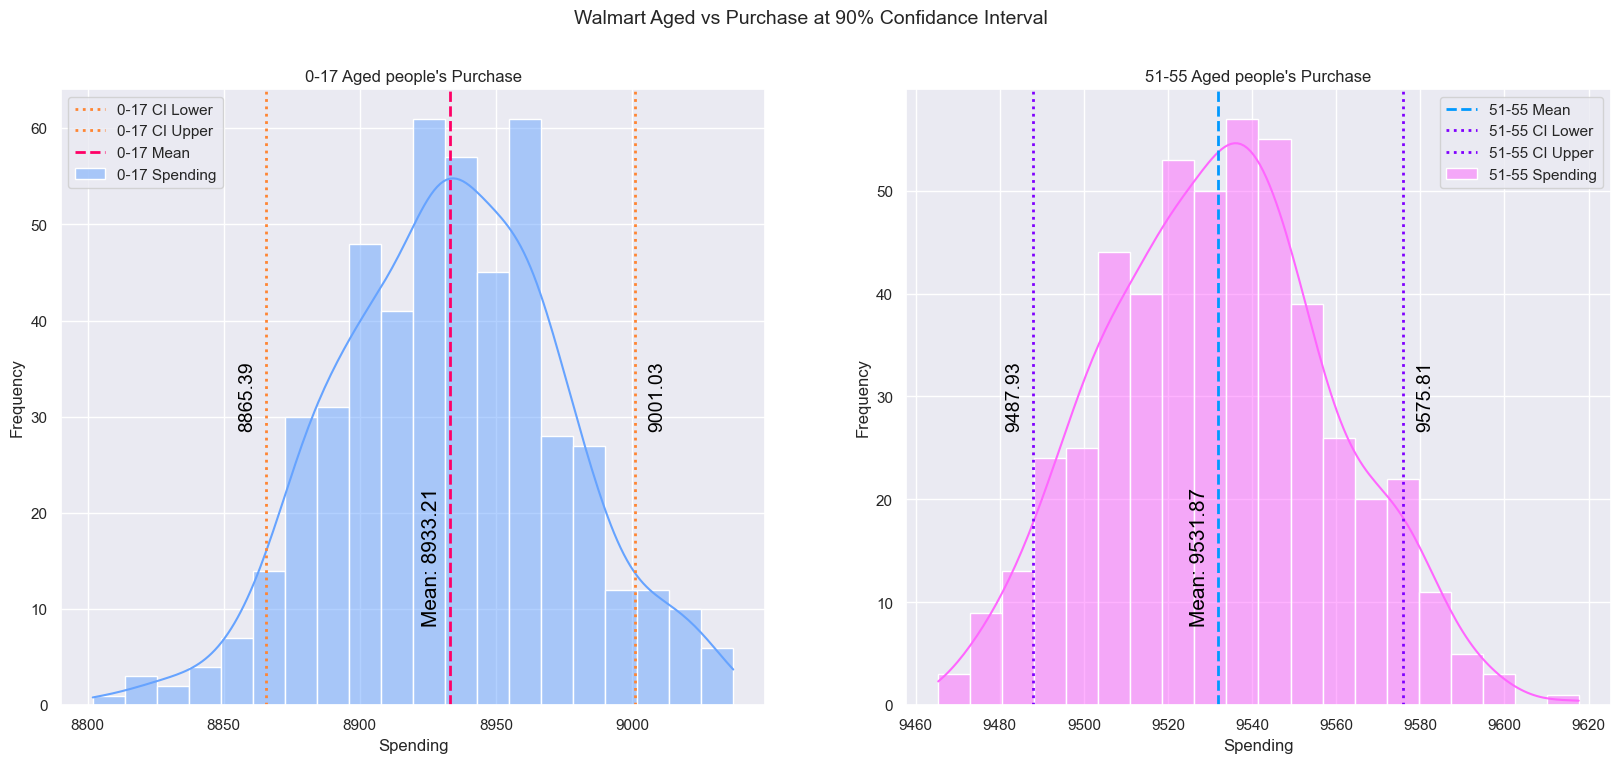

In [235]:
df_0_17_clt_interval = bootstraping(df_0_17, samples, cl=confidence_level, plot=False)
df_51_55_clt_interval = bootstraping(df_51_55, samples, cl=confidence_level, plot=False)
# mean, std_error, z_critical, margin_of_error, confidance_interval_lower, confidance_interval_upper, sample_df, significance_level, samples_size

plt.figure(figsize=(20,8)).suptitle("Walmart Aged vs Purchase at 90% Confidance Interval",fontsize=14)

plt.subplot(1, 2, 1)
sns.histplot(data=df_0_17_clt_interval.sample_df, bins=20, color='#66a3ff', label='0-17 Spending', kde=True)
plt.axvline(df_0_17_clt_interval.confidance_interval_lower, color='#ff8533', linestyle='dotted', linewidth=2, label='0-17 CI Lower')
plt.axvline(df_0_17_clt_interval.confidance_interval_upper, color='#ff8533', linestyle='dotted', linewidth=2, label='0-17 CI Upper')
plt.axvline(df_0_17_clt_interval.mean, color='#ff0066', linestyle='dashed', linewidth=2, label='0-17 Mean')
plt.annotate(f'Mean: {df_0_17_clt_interval.mean:.2f}', rotation='vertical', xy=(df_0_17_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{df_0_17_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(df_0_17_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{df_0_17_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(df_0_17_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('0-17 Aged people\'s Purchase')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=df_51_55_clt_interval.sample_df, bins=20, color='#ff66ff', label='51-55 Spending', kde=True)
plt.axvline(df_51_55_clt_interval.mean, color='#0099ff', linestyle='dashed', linewidth=2, label='51-55 Mean')
plt.axvline(df_51_55_clt_interval.confidance_interval_lower, color='#8000ff', linestyle='dotted', linewidth=2, label='51-55 CI Lower')
plt.axvline(df_51_55_clt_interval.confidance_interval_upper, color='#8000ff', linestyle='dotted', linewidth=2, label='51-55 CI Upper')
plt.annotate(f'Mean: {df_51_55_clt_interval.mean:.2f}', rotation='vertical', xy=(df_51_55_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{df_51_55_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(df_51_55_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{df_51_55_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(df_51_55_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('51-55 Aged people\'s Purchase')
plt.legend()

plt.show()

#### When Confidance Interval is 95%

In [236]:
confidence_level = 0.95
sigma = 1-confidence_level #$ Significance Level

In [237]:
if p_value < sigma:
    print("Differance exists in Mean Purchase for All Age group.")
else:
    print("Mean Purchase for All Age group are Same.")


Differance exists in Mean Purchase for All Age group.


##### Use the Central limit theorem to compute the interval

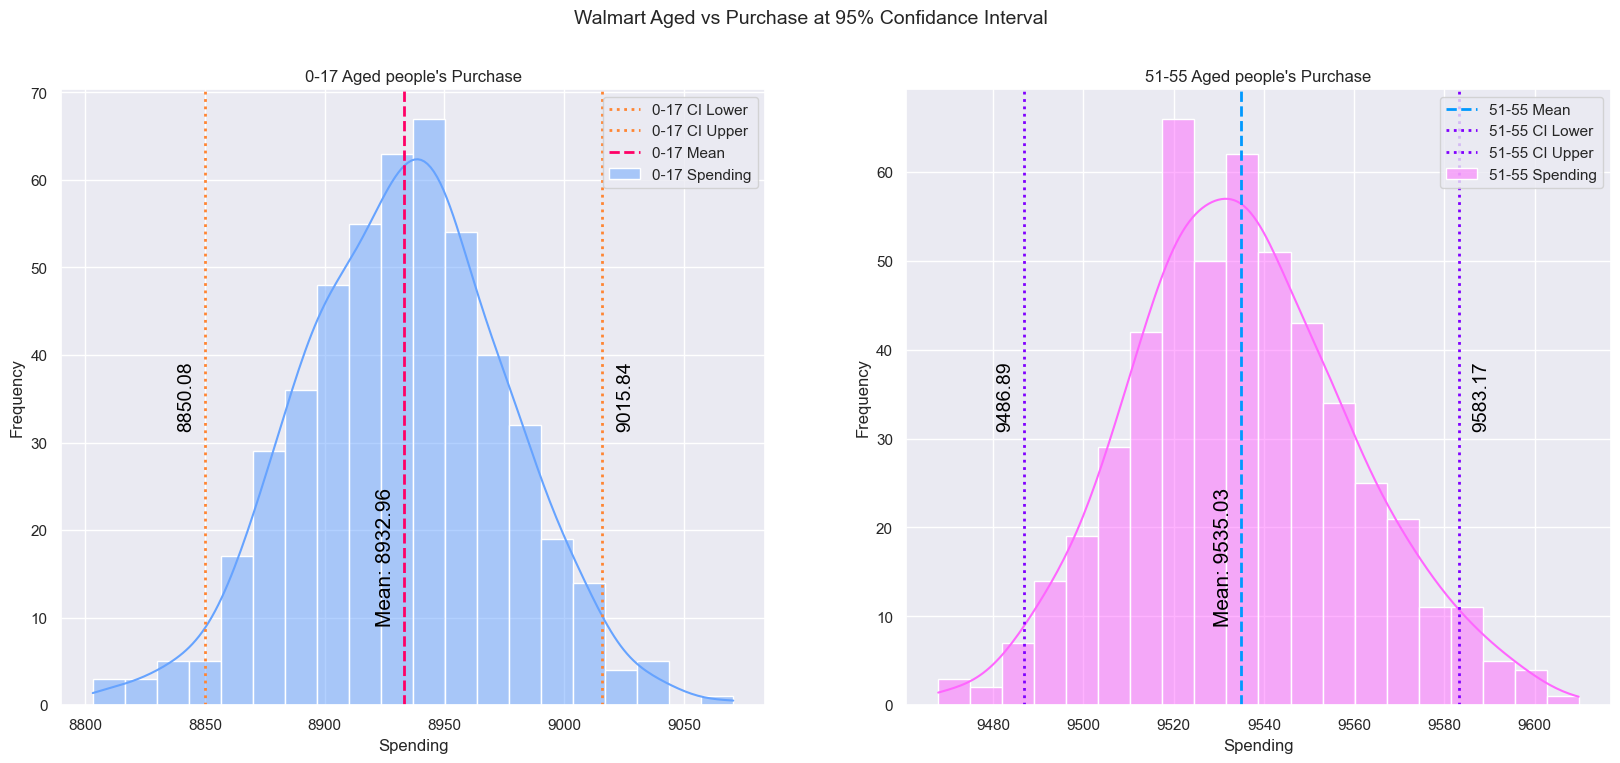

In [238]:
df_0_17_clt_interval = bootstraping(df_0_17, samples, cl=confidence_level, plot=False)
df_51_55_clt_interval = bootstraping(df_51_55, samples, cl=confidence_level, plot=False)
# mean, std_error, z_critical, margin_of_error, confidance_interval_lower, confidance_interval_upper, sample_df, significance_level, samples_size

plt.figure(figsize=(20,8)).suptitle("Walmart Aged vs Purchase at 95% Confidance Interval",fontsize=14)

plt.subplot(1, 2, 1)
sns.histplot(data=df_0_17_clt_interval.sample_df, bins=20, color='#66a3ff', label='0-17 Spending', kde=True)
plt.axvline(df_0_17_clt_interval.confidance_interval_lower, color='#ff8533', linestyle='dotted', linewidth=2, label='0-17 CI Lower')
plt.axvline(df_0_17_clt_interval.confidance_interval_upper, color='#ff8533', linestyle='dotted', linewidth=2, label='0-17 CI Upper')
plt.axvline(df_0_17_clt_interval.mean, color='#ff0066', linestyle='dashed', linewidth=2, label='0-17 Mean')
plt.annotate(f'Mean: {df_0_17_clt_interval.mean:.2f}', rotation='vertical', xy=(df_0_17_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{df_0_17_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(df_0_17_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{df_0_17_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(df_0_17_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('0-17 Aged people\'s Purchase')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=df_51_55_clt_interval.sample_df, bins=20, color='#ff66ff', label='51-55 Spending', kde=True)
plt.axvline(df_51_55_clt_interval.mean, color='#0099ff', linestyle='dashed', linewidth=2, label='51-55 Mean')
plt.axvline(df_51_55_clt_interval.confidance_interval_lower, color='#8000ff', linestyle='dotted', linewidth=2, label='51-55 CI Lower')
plt.axvline(df_51_55_clt_interval.confidance_interval_upper, color='#8000ff', linestyle='dotted', linewidth=2, label='51-55 CI Upper')
plt.annotate(f'Mean: {df_51_55_clt_interval.mean:.2f}', rotation='vertical', xy=(df_51_55_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{df_51_55_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(df_51_55_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{df_51_55_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(df_51_55_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('51-55 Aged people\'s Purchase')
plt.legend()

plt.show()

#### When Confidance Interval is 99%

In [239]:
confidence_level = 0.99
sigma = 1-confidence_level #$ Significance Level

In [240]:
if p_value < sigma:
    print("Differance exists in Mean Purchase for All Age group.")
else:
    print("Mean Purchase for All Age group are Same.")


Differance exists in Mean Purchase for All Age group.


##### Use the Central limit theorem to compute the interval

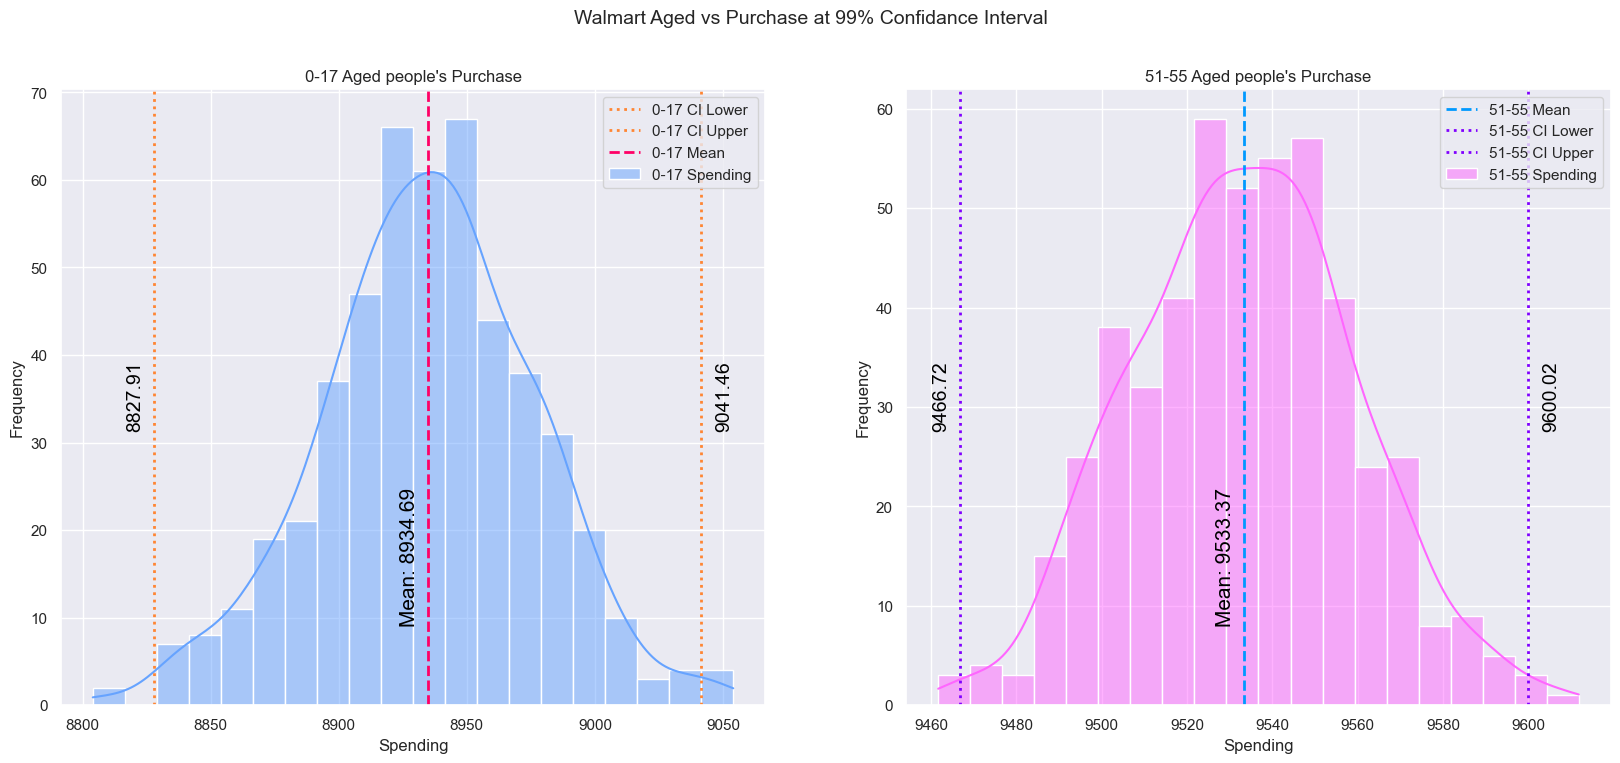

In [241]:
df_0_17_clt_interval = bootstraping(df_0_17, samples, cl=confidence_level, plot=False)
df_51_55_clt_interval = bootstraping(df_51_55, samples, cl=confidence_level, plot=False)
# mean, std_error, z_critical, margin_of_error, confidance_interval_lower, confidance_interval_upper, sample_df, significance_level, samples_size

plt.figure(figsize=(20,8)).suptitle("Walmart Aged vs Purchase at 99% Confidance Interval",fontsize=14)

plt.subplot(1, 2, 1)
sns.histplot(data=df_0_17_clt_interval.sample_df, bins=20, color='#66a3ff', label='0-17 Spending', kde=True)
plt.axvline(df_0_17_clt_interval.confidance_interval_lower, color='#ff8533', linestyle='dotted', linewidth=2, label='0-17 CI Lower')
plt.axvline(df_0_17_clt_interval.confidance_interval_upper, color='#ff8533', linestyle='dotted', linewidth=2, label='0-17 CI Upper')
plt.axvline(df_0_17_clt_interval.mean, color='#ff0066', linestyle='dashed', linewidth=2, label='0-17 Mean')
plt.annotate(f'Mean: {df_0_17_clt_interval.mean:.2f}', rotation='vertical', xy=(df_0_17_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{df_0_17_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(df_0_17_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{df_0_17_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(df_0_17_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('0-17 Aged people\'s Purchase')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(data=df_51_55_clt_interval.sample_df, bins=20, color='#ff66ff', label='51-55 Spending', kde=True)
plt.axvline(df_51_55_clt_interval.mean, color='#0099ff', linestyle='dashed', linewidth=2, label='51-55 Mean')
plt.axvline(df_51_55_clt_interval.confidance_interval_lower, color='#8000ff', linestyle='dotted', linewidth=2, label='51-55 CI Lower')
plt.axvline(df_51_55_clt_interval.confidance_interval_upper, color='#8000ff', linestyle='dotted', linewidth=2, label='51-55 CI Upper')
plt.annotate(f'Mean: {df_51_55_clt_interval.mean:.2f}', rotation='vertical', xy=(df_51_55_clt_interval.mean, 0), xytext=(-20, 60), textcoords='offset points', color='blacK', fontsize=15)
plt.annotate(f'{df_51_55_clt_interval.confidance_interval_lower:.2f}', rotation='vertical', xy=(df_51_55_clt_interval.confidance_interval_lower, 0), xytext=(-20, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.annotate(f'{df_51_55_clt_interval.confidance_interval_upper:.2f}', rotation='vertical', xy=(df_51_55_clt_interval.confidance_interval_upper, 0), xytext=(10, 200), textcoords='offset points', color='blacK', fontsize=14)
plt.xlabel('Spending')
plt.ylabel('Frequency')
plt.title('51-55 Aged people\'s Purchase')
plt.legend()

plt.show()

#### 
> Insight

        Ho -> Mean Purchase for All Age group are Same.
        Ha -> Differance exists in Mean Purchase for All Age group.

      Using Anov Test p_value for All Age Group found as 1.053563939251671e-47%.
      
* With Confidance interval of 90% & Sample Size of 500
    * Mean Purchase by 0-17 Aged People is 8934.92 with a Intervals of (8868.91 - 9000.92).
    * Mean Purchase by 51-55 Aged People is 9534.35 with a Intervals of (9491.49 - 9577.22).
    * As 1.053563939251671e-47% < 10% Thus Rejecting Ho and Accepting Ha.
 
* With Confidance interval of 95% & Sample Size of 500
    * Mean Purchase by 0-17 Aged People is 9532.25 with a Intervals of (8848.87 - 9015.63).
    * Mean Purchase by 51-55 Aged People is 9534.85 with a Intervals of (9483.29 - 9586.40).
    * As 1.053563939251671e-47% < 5% Thus Rejecting Ho and Accepting Ha.

* With Confidance interval of 99% & Sample Size of 500
    * Mean Purchase by 0-17 Aged People is 8933.75 with a Intervals of (8827.73 - 9039.77).
    * Mean Purchase by 51-55 Aged People is 9535.59 with a Intervals of (9469.34 - 9601.84).
    * As 1.053563939251671e-47% < 1% Thus Rejecting Ho and Accepting Ha.
  
No, there is no Overlaping between 0-17 & 51-55.
 

# END